# Tests on Trans Atlas data

Trajectories from the TransAtlas MD database are used here as input data. These trajectories reproduce conformational transitions between two different states of proteins. The trajectories are generated using the GOdMD approach. The potential energy function considers only Carbon alpha atoms and both bonding and non-bonding interactions are described with simplified wells. The MD engine to generate samples uses discrete MD (ballistic regime) and enhanced sampling with metadynamics and Maxwell Demon. For additional details see [Orozco et al.](https://doi.org/10.1093/bioinformatics/btt324).

Thus these trajectories represent large conformational changes of proteins. They contain only Carbon alpha atoms and there is a small number of samples. Here we will use the deep cartograph package to analyze these trajectories and find collective variables that describe the transitions.

In [34]:
from sklearn.neighbors import KernelDensity
from IPython.display import Image, display
from typing import Tuple, Dict, List
from decimal import Decimal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import shutil
import yaml
import os

# Set logging level
logging.basicConfig(level=logging.INFO)

def read_column_names(colvars_path: str) -> list:
    '''
    Reads the column names from a COLVARS file. 

    Inputs
    ------

        colvars_path    (str):          COLVARS file path

    Outputs
    -------

        column_names    (list of str):  list with the column names
    '''

    # Read first line of COLVARS file
    with open(colvars_path, 'r') as colvars_file:
        first_line = colvars_file.readline()

    # Separate first line by spaces
    first_line = first_line.split()

    # The first element is "#!" and the second is "FIELDS" - remove them
    column_names = first_line[2:]

    return column_names

def read_as_pandas(colvars_path: str) -> pd.DataFrame:
    '''
    Function that reads a COLVARS file and returns a pandas DataFrame with the same column names as in the COLVARS file.    
    The time column in ps will be converted to ns.

    If the logger level is set to DEBUG, information about the column names will be printed.

    Inputs
    ------

        colvars_path    (str):          COLVARS file path

    Outputs
    -------

        colvars_df      (pandas DataFrame):      COLVARS data
    '''

    # Read column names
    column_names = read_column_names(colvars_path)

    # Read COLVARS file
    colvars_df = pd.read_csv(colvars_path, sep='\s+', dtype=np.float32, comment='#', header=None, names=column_names)

    # Convert time from ps to ns - working with integers to avoid rounding errors
    colvars_df["time"] = colvars_df["time"] * 1000 / 1000000

    return colvars_df

def compute_kde(feature_data: pd.DataFrame, bandwidth: float = 0.1, kernel: str = "gaussian") -> KernelDensity:
    """
    Compute the Kernel Density Estimation for a data frame containing the time series of a single feature.

    Parameters
    ----------

        feature_data    (pandas DataFrame):   data frame with the time series of a single feature
        bandwith        (float):              bandwith for the KDE
        kernel          (str):                kernel for the KDE
    
    Returns
    -------

        kde             (KernelDensity):       KDE object
    """

    # Create the KDE object
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)

    # Convert the data to a numpy array
    data = feature_data.values.reshape(-1, 1)

    # Fit the KDE
    kde.fit(data)

    return kde

def show_filtering_results(colvars_path: str, filter_summary_path: str, N: int = 10, bandwidth: float = 0.1, kernel: str = "gaussian", alpha_level = 0.05):
    """
    Function that shows a summary of the feature analysis. It shows:
     
       - The probability distribution of N randomly selected discarded features and N randomly selected filtered features. 
       - The distribution of the hartigan dip test (hdt) result for all the features
    
    Parameters
    ----------
    
        colvars_path        (str): path to the colvars file with the time series of all features
        filter_summary_path (str): path to the filter summary csv file with the results of the filter for each feature
    """

    font_size = 14
    
    def get_kde_models(colvars_df: pd.DataFrame, names: list, bandwidth: float = 0.1, kernel: str = "gaussian") -> Tuple[Dict, List]:
        
        kde_models = {}
        features_range = [colvars_df[names[0]].min(), colvars_df[names[0]].max()]
        for name in names:
            feature_data = colvars_df[name]
            kde = compute_kde(feature_data, bandwidth = bandwidth, kernel = kernel)
            kde_models[name] = kde
            features_range[0] = min(features_range[0], feature_data.min())
            features_range[1] = max(features_range[1], feature_data.max())
        
        return kde_models, features_range

    def plot_kde(data_df: pd.DataFrame, bandwidth: float = 0.01, kernel: str = "gaussian", x_label: str = "x", title: str = "KDE"):

        # Get the KDE model of the p-values
        hdtp_kde = compute_kde(data_df, bandwidth = bandwidth, kernel = kernel)

        # Generate x values to plot the KDE
        x = np.linspace(data_df.min(), data_df.max(), 1000)

        # Generate samples from the KDE model, compute the log density
        log_dens = hdtp_kde.score_samples(x[:, None])

        # Find the probability density
        dens = np.exp(log_dens)

        # Normalize the probability density
        dens = dens / dens.sum()

        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the KDE
        ax.plot(x, dens)

        # Create a new axis on the right side for the histogram
        ax_hist = ax.twinx()

        # Plot the 1D histogram of the p-values
        ax_hist.hist(data_df, bins=200, density=True, alpha=0.2)

        # Add vertical line at alpha_level
        ax.axvline(x=alpha_level, color='r', linestyle='--')

        # Add text with the alpha level
        ax.text(alpha_level, max(dens) * 0.9, f" alpha = {alpha_level}", color='r', fontsize = font_size)

        # Set size to tick labels
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax_hist.tick_params(axis='both', which='major', labelsize=font_size)
        
        # Add limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, max(dens) + max(dens) * 0.1])

        # Add title
        ax.set_title(title, fontsize = font_size + 4)

        # Add labels
        ax.set_xlabel(x_label, fontsize = font_size)
        ax.set_ylabel("Probability density", fontsize = font_size)
        ax_hist.set_ylabel("Histogram", fontsize = font_size)

        # Show the plot
        plt.show()

    def plot_feature_kdes(features_range: List, sample_df: pd.DataFrame, kde_models: Dict[str, KernelDensity], title: str):
        
        sample_names = sample_df["name"].values

        # Generate x values to plot the KDEs
        x = np.linspace(features_range[0], features_range[1], 1000)

        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the probability distribution of each feature
        max_density = 0
        for name in sample_names:
            
            # Get the p-value of the Hartigan's Dip Test
            p_value = sample_df[sample_df["name"] == name]["hdtp"].values[0]

            # Get the corresponding KDE model
            kde_model = kde_models[name]

            # Generate samples from the KDE model, compute the log density 
            log_dens = kde_model.score_samples(x[:, None])

            # Plot the KDE
            ax.plot(x, np.exp(log_dens), label=f"{name} (p-value: {Decimal(p_value):.2E})")

            # Get the maximum density
            max_density = max(max_density, np.exp(log_dens).max())

        # Set the limits
        plt.xlim(features_range) 
        plt.ylim([0, max_density + max_density * 0.1])
        
        # Add title
        ax.set_title(title, fontsize = font_size + 4)

        # Add labels
        ax.set_xlabel("Feature value", fontsize = font_size)
        ax.set_ylabel("Probability density", fontsize = font_size)

        # Add legend
        ax.legend(fontsize = font_size - 2)

        # Set size to tick labels
        ax.tick_params(axis='both', which='major', labelsize=font_size)

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

    # Try to load the colvars file
    if not os.path.exists(colvars_path):
        raise FileNotFoundError(f"File {colvars_path} not found")
    try:
        colvars_df = read_as_pandas(colvars_path)
    except:
        raise ValueError(f"Could not read file {colvars_path}")

    # Try to load the filter summary file
    if not os.path.exists(filter_summary_path):
        raise FileNotFoundError(f"File {filter_summary_path} not found")
    try:
        filter_summary_df = pd.read_csv(filter_summary_path)
    except:
        raise ValueError(f"Could not read file {filter_summary_path}")

    plot_kde(filter_summary_df['hdtp'], bandwidth = 0.001, kernel = kernel, x_label = 'p-value', title = 'Hartigan Dip Test p-values')

    # Get the discarded features df, those with pass = False in the filter summary
    discarded_features_df = filter_summary_df[filter_summary_df["pass"] == False]

    # Get the filtered features df, those with pass = True in the filter summary
    filtered_features_df = filter_summary_df[filter_summary_df["pass"] == True]

    # Get 10 random discarded features
    discarded_sample_df = discarded_features_df.sample(N)
    discarded_sample_names = discarded_sample_df["name"].values
    
    # Get the KDE models for the discarded features
    discarded_kde_models, discarded_features_range = get_kde_models(colvars_df, discarded_sample_names, bandwidth, kernel)

    # Get 10 random filtered features
    filtered_sample_df = filtered_features_df.sample(N)
    filtered_sample_names = filtered_sample_df["name"].values

    # Get the KDE models for the filtered features
    filtered_kde_models, filtered_features_range = get_kde_models(colvars_df, filtered_sample_names, bandwidth, kernel)

    # Unify features range
    features_range = [min(discarded_features_range[0], filtered_features_range[0]), max(discarded_features_range[1], filtered_features_range[1])]

    # Plot the KDEs for the discarded features
    plot_feature_kdes(features_range, discarded_sample_df, discarded_kde_models, "Discarded features")

    # Plot the KDEs for the filtered features
    plot_feature_kdes(features_range, filtered_sample_df, filtered_kde_models, "Selected features")

def show_results(output_folder: str, model_name: str):

    # Training folder
    training_folder = os.path.join(output_folder, 'train_colvars')

    # Model folder
    model_folder = os.path.join(training_folder, model_name)

    # Paths to images
    trajectory = os.path.join(model_folder, 'trajectory.png')
    trajectory_clustered = os.path.join(model_folder, 'trajectory_clustered.png')
    fes = os.path.join(model_folder, 'fes/fes.png')
    paths = [trajectory, trajectory_clustered, fes]

    # Instantiate the images
    images = [Image(filename=path, width=500) for path in paths if os.path.exists(path)]

    # Display images
    display(*images)
    

## 1rcs_B-3ssx_R-3

The trajectory

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/trajectory.mp4" controls> </video>
</center>

### Computing the features from the trajectory

There are several dictionaries of features available:

- Pairwise distances between two selections of atoms
- Dihedral angles
- Distance to center of mass of a selection of atoms

The features are computed using PLUMED.

This example deals with Carbon-alpha trajectories of large proteins. Pairwise distances between selections scale worse with system size than torsion angles. Here we use virtual torsion angles between consecutive C-alpha atoms as the dictionary of features. 

#### Step 1: Compute virtual torsion angles

In [35]:
from deep_cartograph import compute_features

# Input trajectory and topology
system_name = '1rcs_B-3ssx_R-3'
input_path = f"../../data/calpha_transitions/input/{system_name}"
traj_path = os.path.join(input_path, f'{system_name}.dcd')
top_path = os.path.join(input_path, f'{system_name}.pdb')

# Input configuration
config_path = "../../data/calpha_transitions/input/torsions_config.yml"

with open(config_path) as config_file:
    configuration = yaml.load(config_file, Loader = yaml.FullLoader)

############################
# Step 1: Compute features #
############################

# Output folder for this step
output_path = f"../../data/calpha_transitions/output/{system_name}"
step1_folder = os.path.join(output_path, 'compute_features')

# Clean step folder
if os.path.exists(step1_folder):
    shutil.rmtree(step1_folder)

# Extract configuration for this step
step1_configuration = configuration['compute_features']

# Call API to compute features
colvars_path = compute_features(
        configuration = step1_configuration, 
        trajectory = traj_path, 
        topology = top_path, 
        output_folder = step1_folder)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.w

INFO:deep_cartograph.modules.plumed.utils:Executing PLUMED driver command: ml PLUMED/2.9.0-intel-2021b && unset I_MPI_PMI_LIBRARY && /eb/x86_64/software/PLUMED/2.9.0-intel-2021b/bin/plumed driver --plumed /home/pnavarro/repos/NBDsoftware/CV_learning/deep_cartograph/data/calpha_transitions/output/1rcs_B-3ssx_R-3/compute_features/torsions.dat --mf_dcd /home/pnavarro/repos/NBDsoftware/CV_learning/deep_cartograph/data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd --natoms 104
INFO:deep_cartograph:Elapsed time (Compute features): 00 h 00 min 01 s


### Step 2: Filter the torsion angles

In this example, the trajectory is already showing a transition between two states. If one is interested in deriving collective variables that can describe the conformational change, we can discard those features that are not perturbed during the transition. As they will be less informative and will add noise to the subsequent analysis.

One of the filters that can be applied is the Hartigan's dip test for unimodality. This test can be used to discard features that are unimodal, as they are less likely to be informative.

INFO:deep_cartograph:==================
INFO:deep_cartograph:Filtering features
INFO:deep_cartograph:==================
INFO:deep_cartograph:Finding the features that contains the most information about the transitions or conformational changes.
INFO:deep_cartograph:The following algorithms are available:
INFO:deep_cartograph:- Hartigan's dip test filter. Keeps features that are not unimodal.
INFO:deep_cartograph:- Shannon entropy filter. Keeps features with entropy greater than a threshold.
INFO:deep_cartograph:- Standard deviation filter. Keeps features with standard deviation greater than a threshold.
INFO:deep_cartograph:- Final Mutual information clustering (AMINO). Clusters filtered features according to a mutual information based distance and selects one feature per cluster minimizing the distorsion.
INFO:deep_cartograph:Note that the all features must be in the same units to apply the entropy and standard deviation filters meaningfully.
INFO:deep_cartograph:Initial size of feat

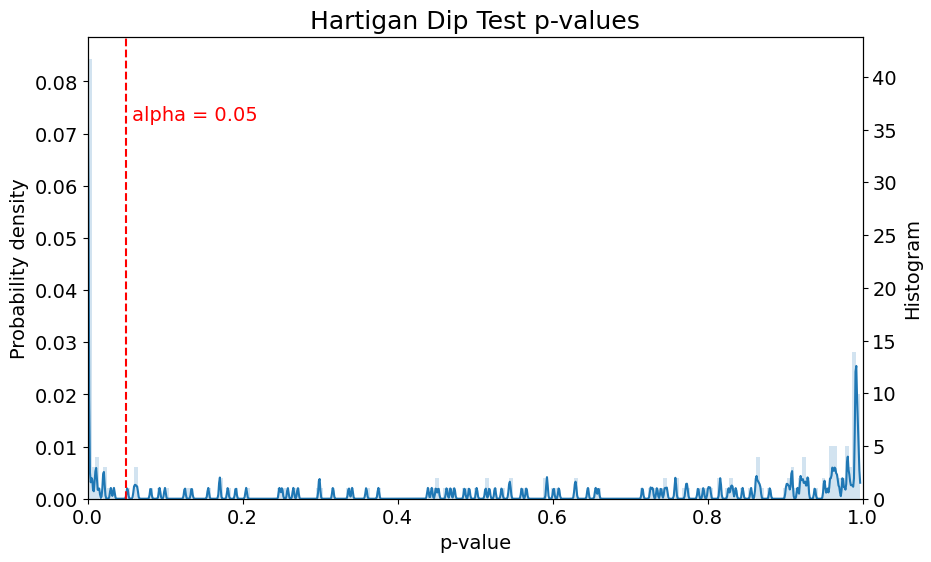

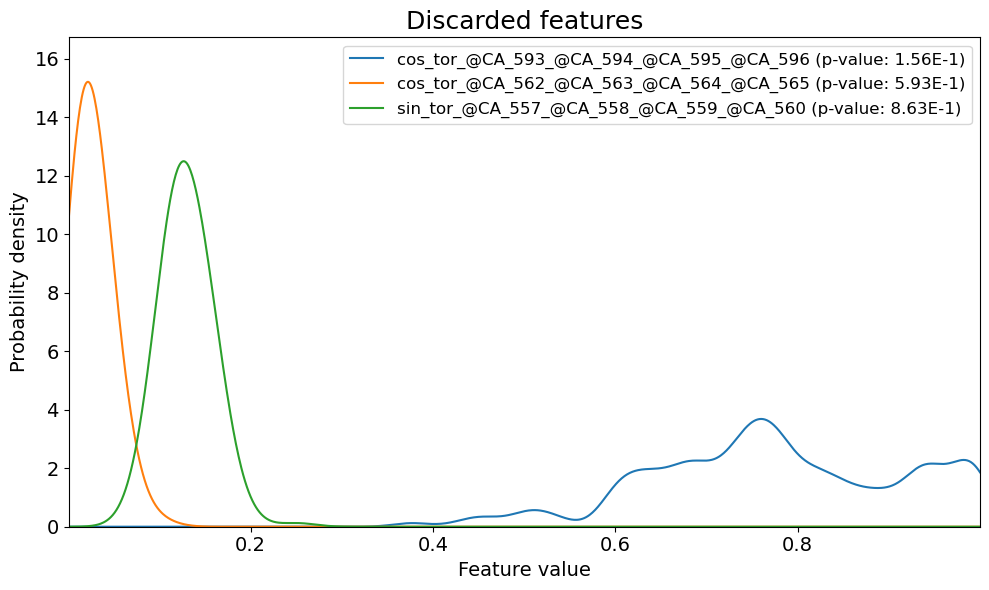

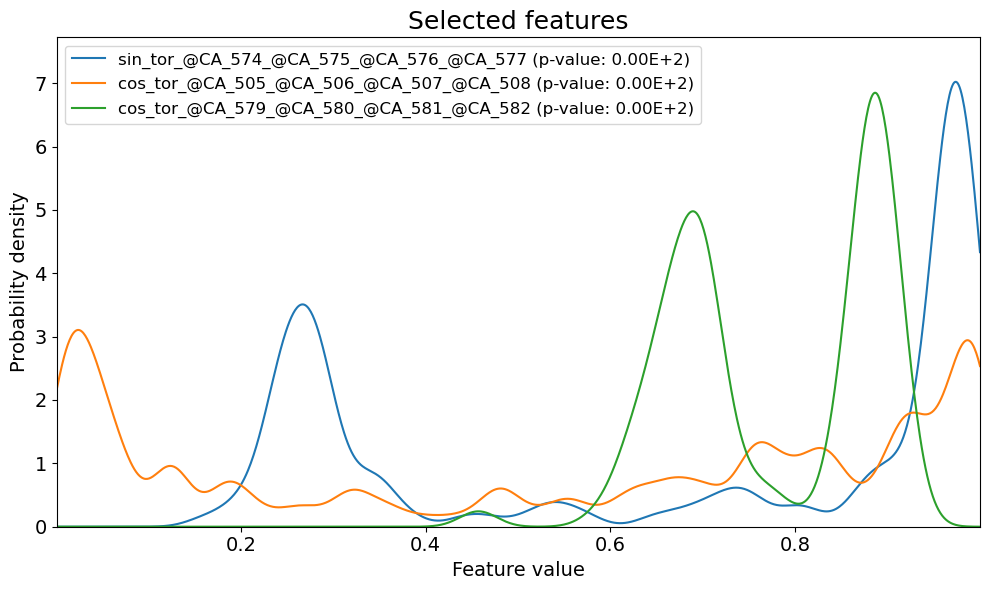

In [36]:
from deep_cartograph import filter_features

###########################
# Step 2: Filter features #
###########################

# Output folder for this step
step2_folder = os.path.join(output_path, 'filter_features')

# Path to filtered features
filtered_features_path = os.path.join(step2_folder, 'filtered_torsions.txt')

# Clean step folder
if os.path.exists(step2_folder):
    shutil.rmtree(step2_folder)

# Extract configuration for this step
step2_configuration = configuration['filter_features']

# Call API to filter features
filtered_features = filter_features(
    configuration = step2_configuration,
    colvars_path = colvars_path,
    csv_summary = True,
    filtered_features_path = filtered_features_path,
    output_folder = step2_folder)

filter_summary_path = os.path.join(step2_folder, 'filter_summary.csv')
show_filtering_results(colvars_path, filter_summary_path, N = 3, bandwidth = 0.05, kernel = "gaussian")

#### Step 3: Compute Collective Variables

One can use the filtered features to train or compute collective variables that can describe the transition. In this example, we compute a 2 dimensional collective variable using 4 different methods:

- PCA
- tICA
- Autoencoder
- Deep tICA or State free reversible VAMPnets (SRV)

In [37]:
from deep_cartograph import train_colvars

#########################
# Step 3: Train colvars #
#########################

# Output folder for this step
step3_folder = os.path.join(output_path, 'train_colvars')

# Clean step folder
if os.path.exists(step3_folder):
    shutil.rmtree(step3_folder)

# Extract configuration for this step
step3_configuration = configuration['train_colvars']

# Call API to train colvars
train_colvars(
    configuration = step3_configuration,
    colvars_path = colvars_path,
    feature_constraints = filtered_features,  
    output_folder = step3_folder) 

INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of Collective Variables
INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of collective variables using the mlcolvar library.
INFO:deep_cartograph:Creating datasets from colvars...
INFO:deep_cartograph:Number of samples: 164
INFO:deep_cartograph:Number of features: 54
INFO:deep_cartograph.tools.train_colvars.utils:Calculating PCA...
INFO:deep_cartograph.modules.figures.figures:Computing FES(PC 1, PC 2)...
/home/pnavarro/repos/NBDsoftware/CV_learning/deep_cartograph/deep_cartograph/modules/figures/figures.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize = font_size)
INFO:deep_cartograph.tools.train_colvars.utils:Projecting trajectory...
INFO:deep_cartograph.modules.statistics.statistics:Best number of clusters: 8
/home/pnav

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Results

The output folder will contain a subfolder for each method used to compute the collective variables.

#### PCA

The projection of the trajectory onto the first two principal components is shown below. We can see three plots:
- The time evolution of the trajectory in the collective variable space. 
- The clustered trajectory in the collective variable space. 
- The free energy surface.

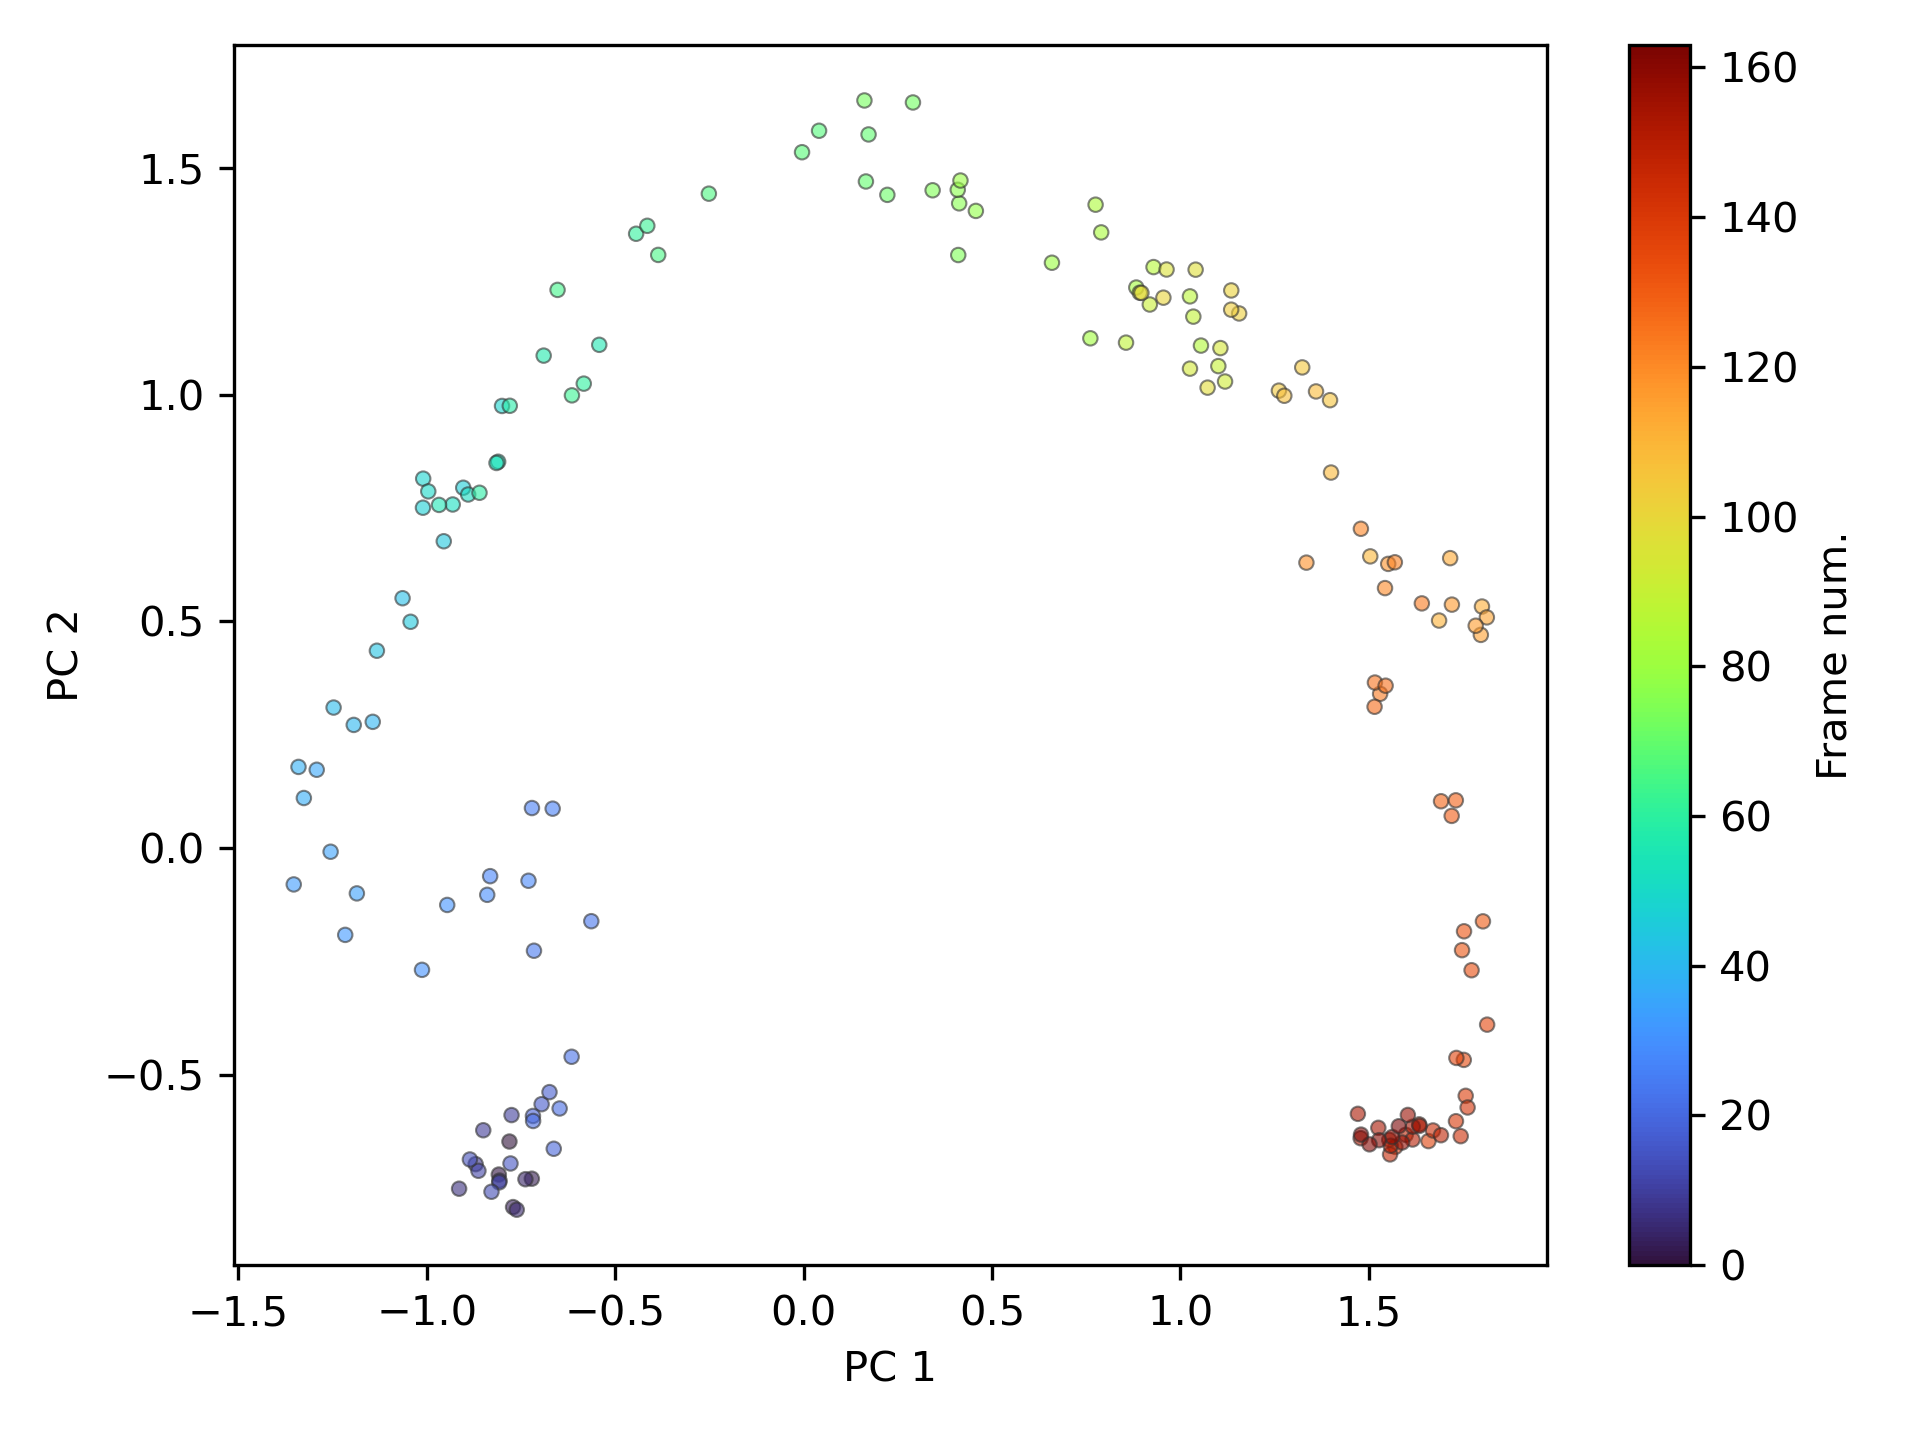

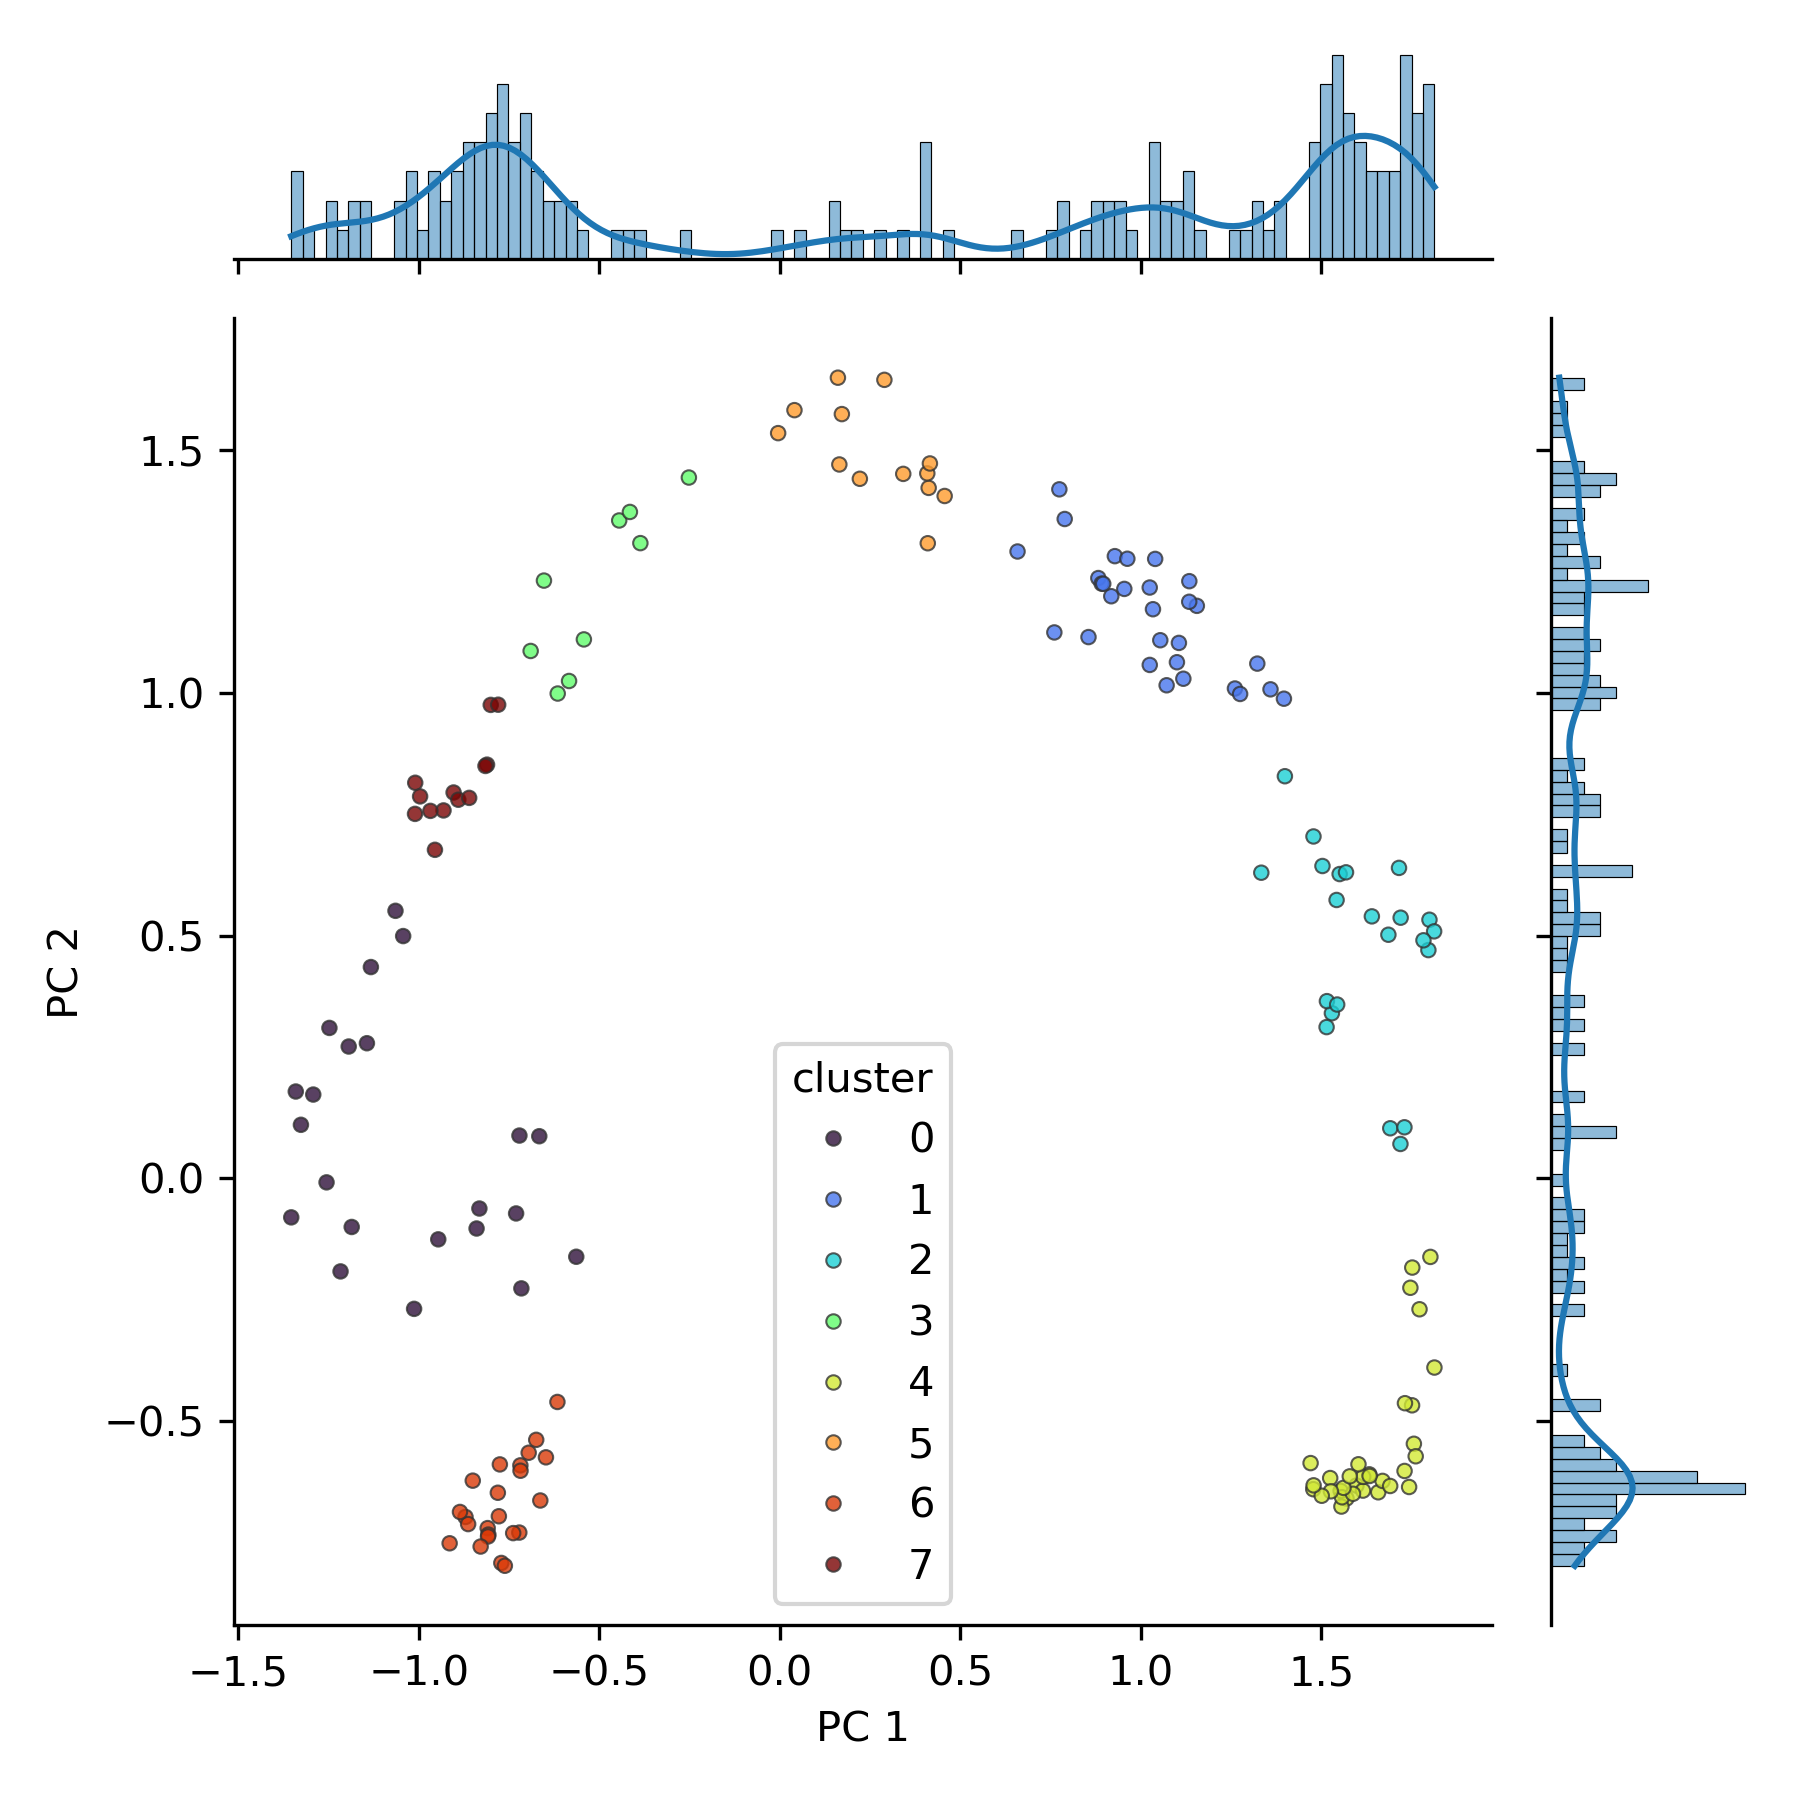

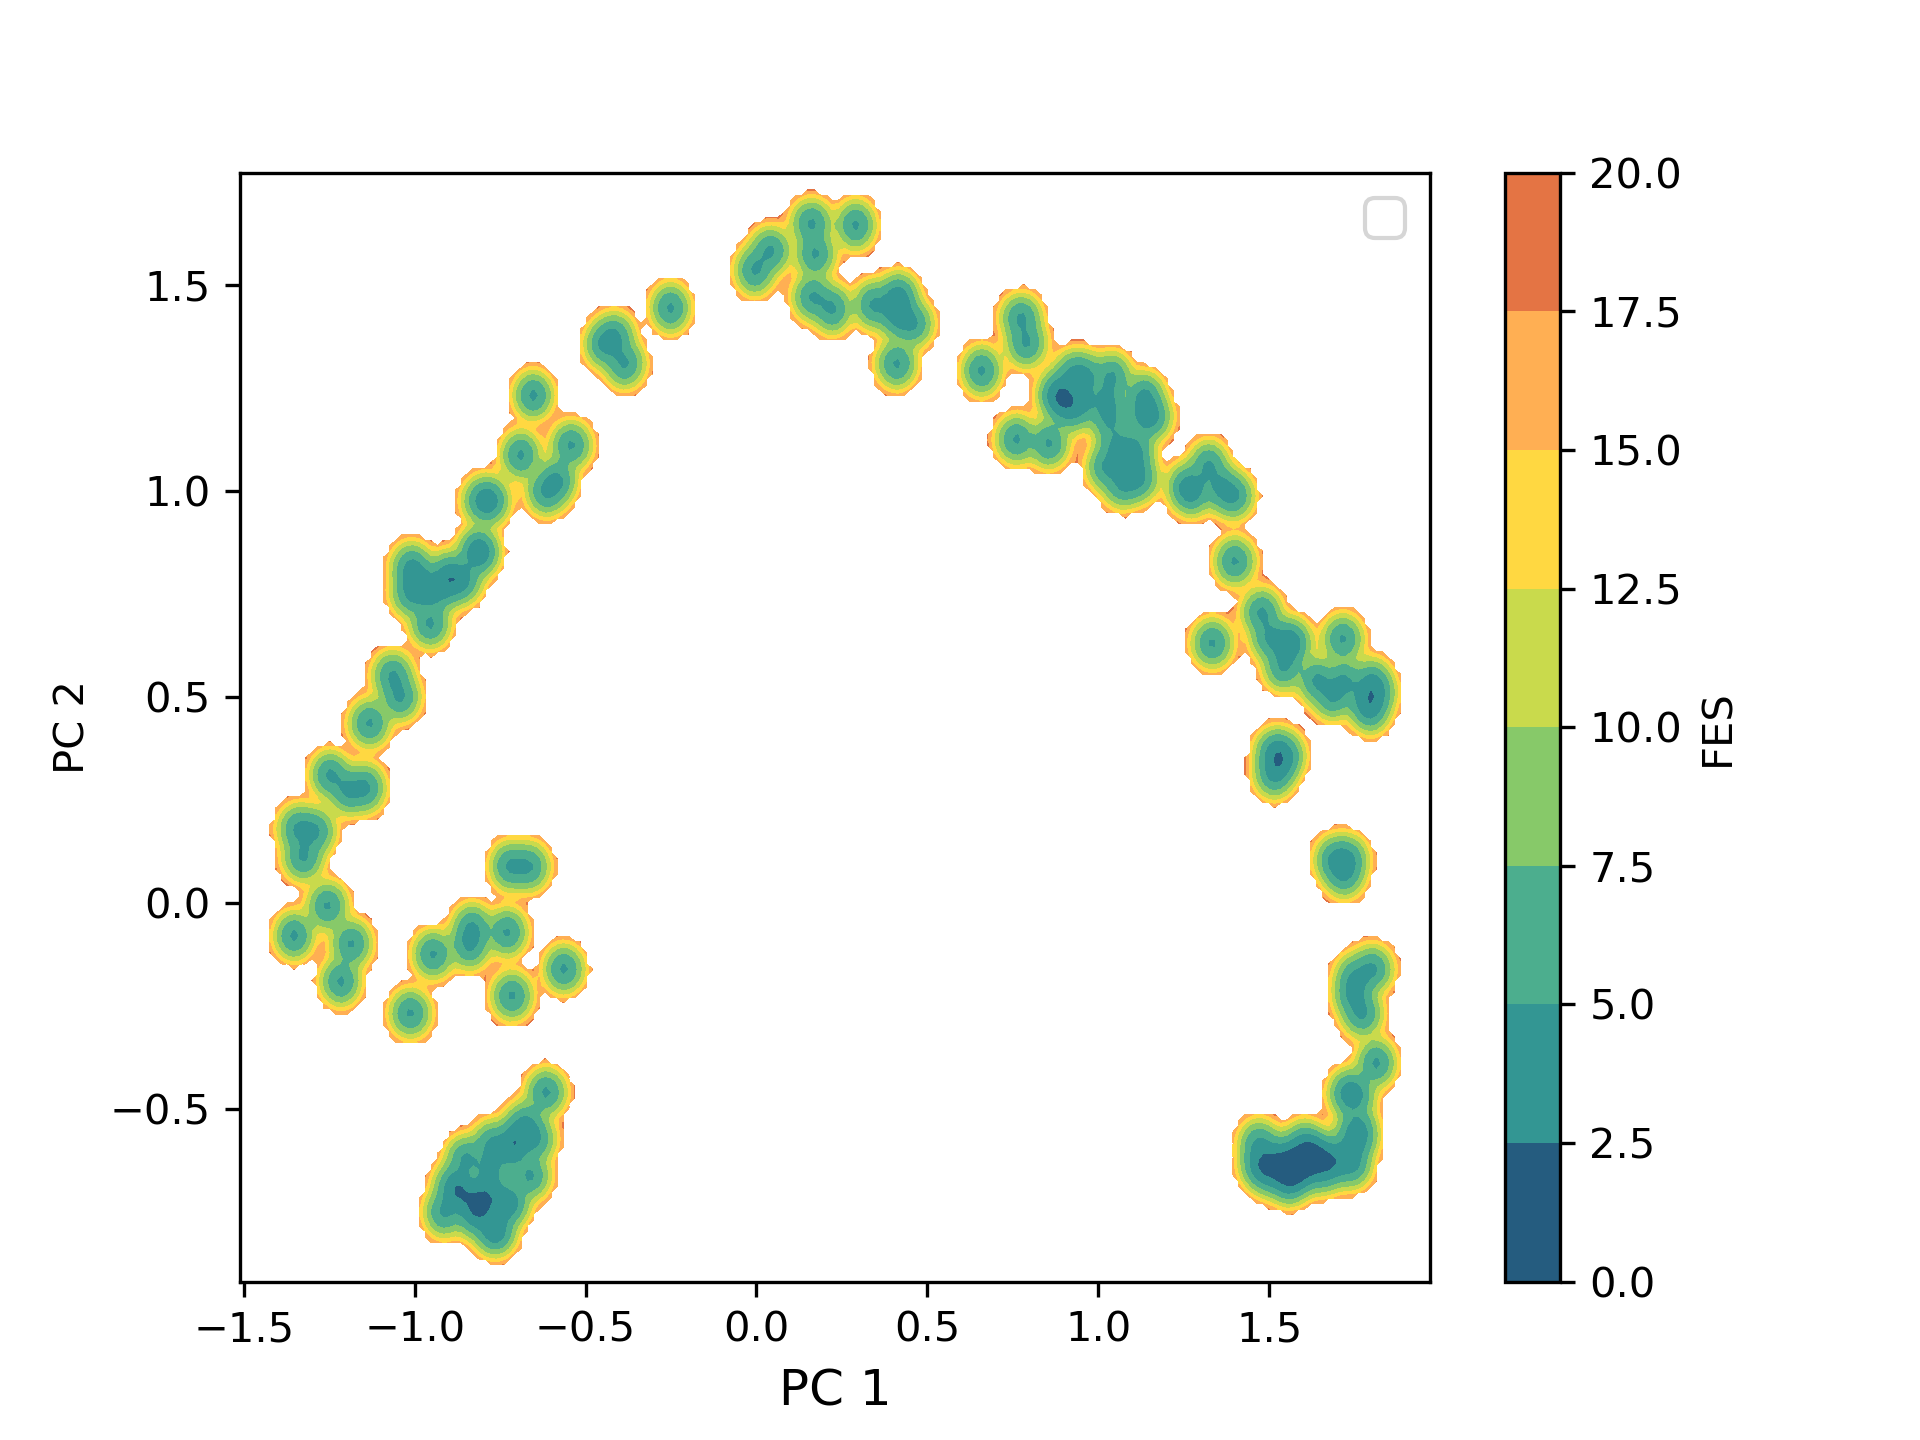

In [38]:
show_results(output_path, model_name = 'pca')

#### AE

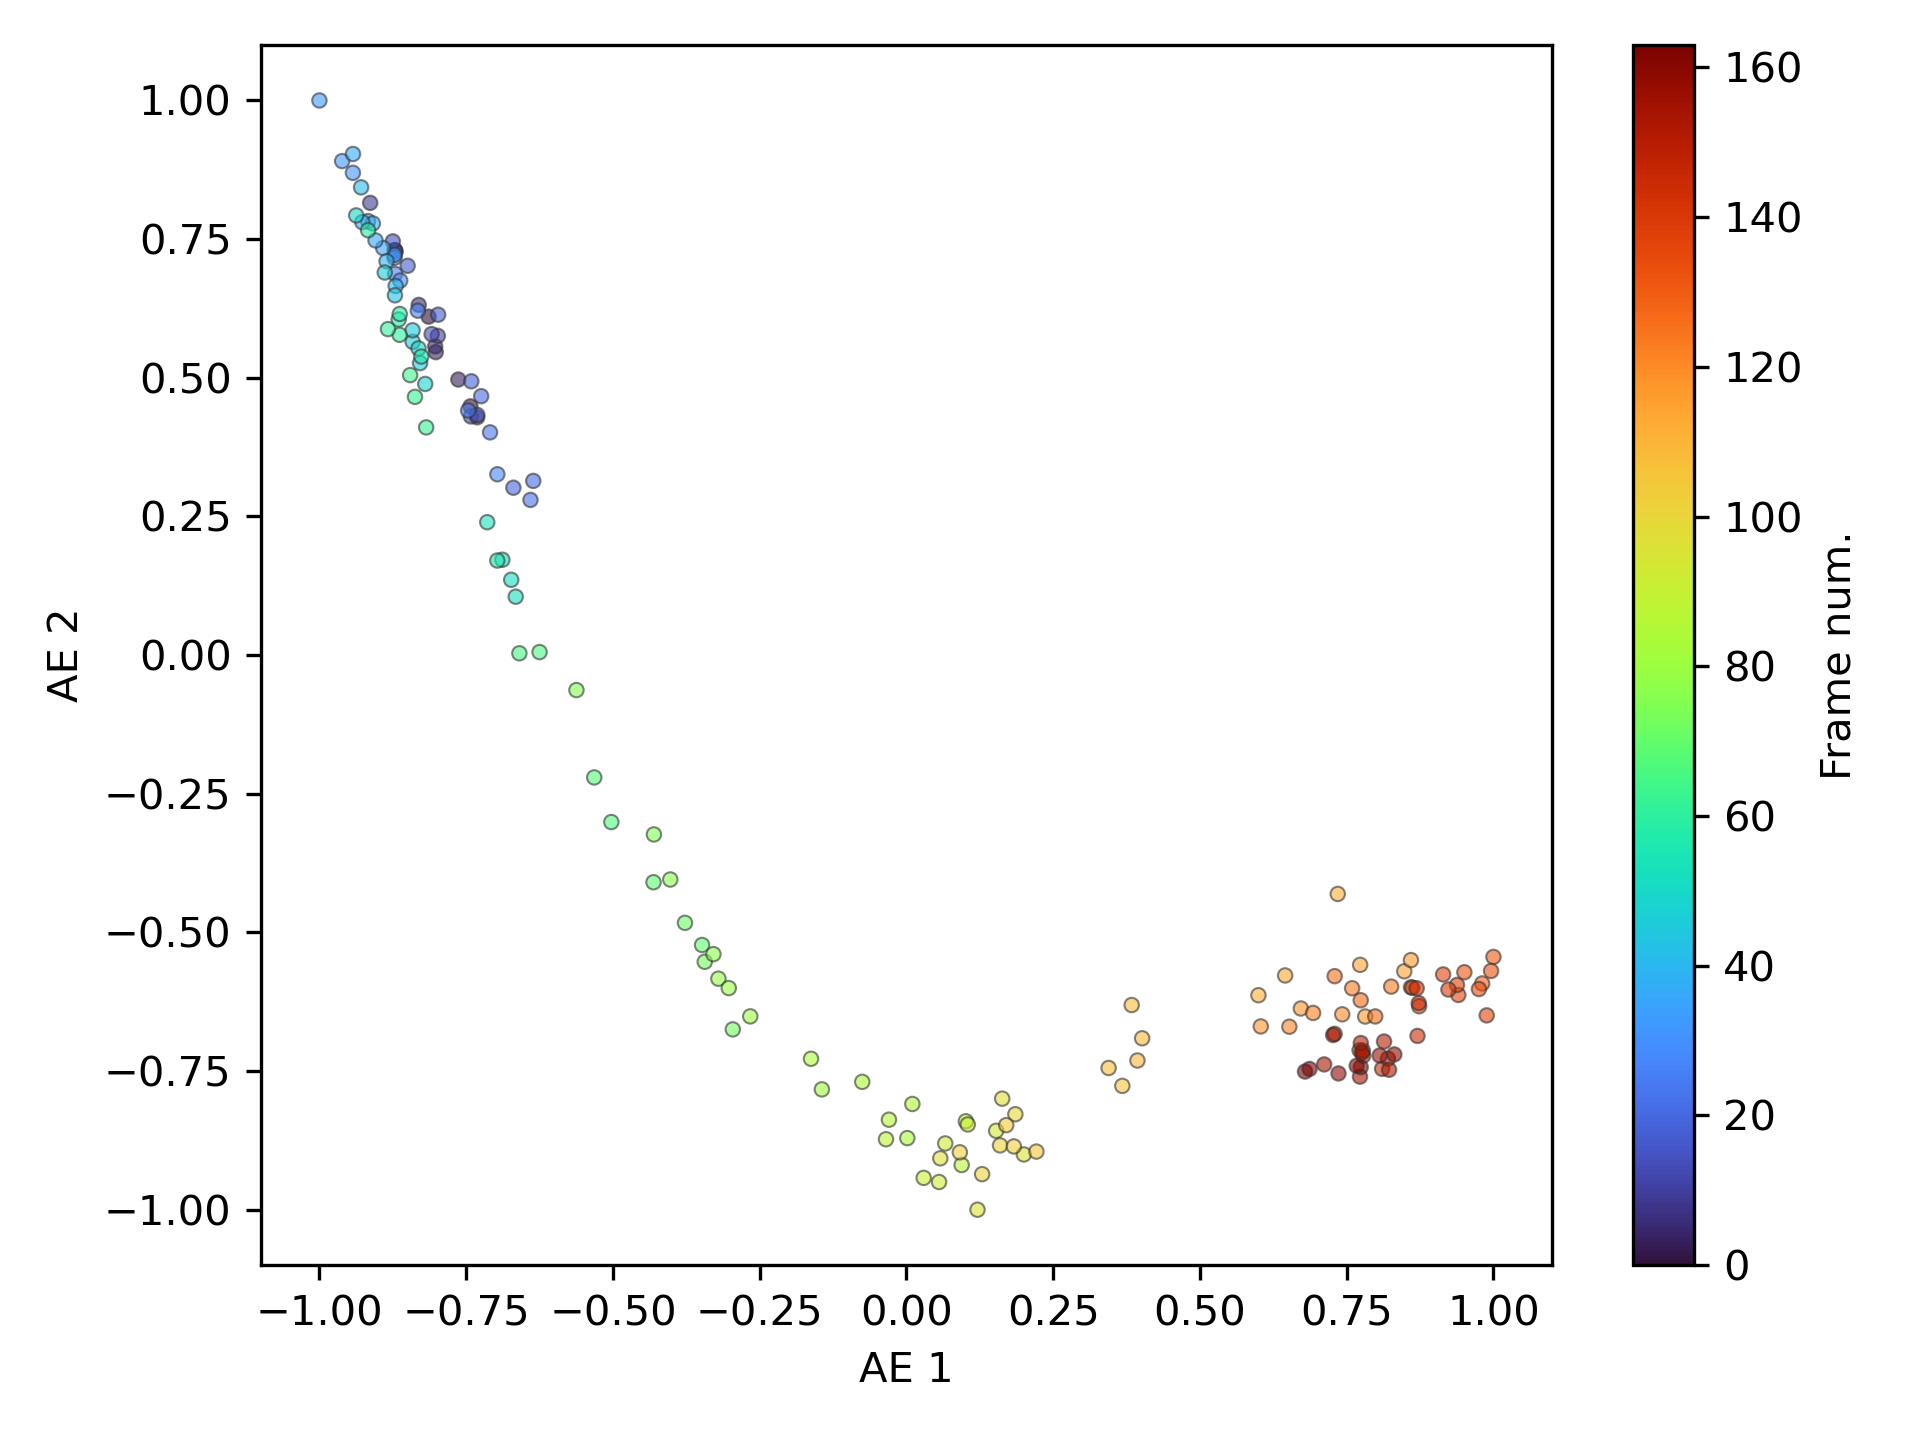

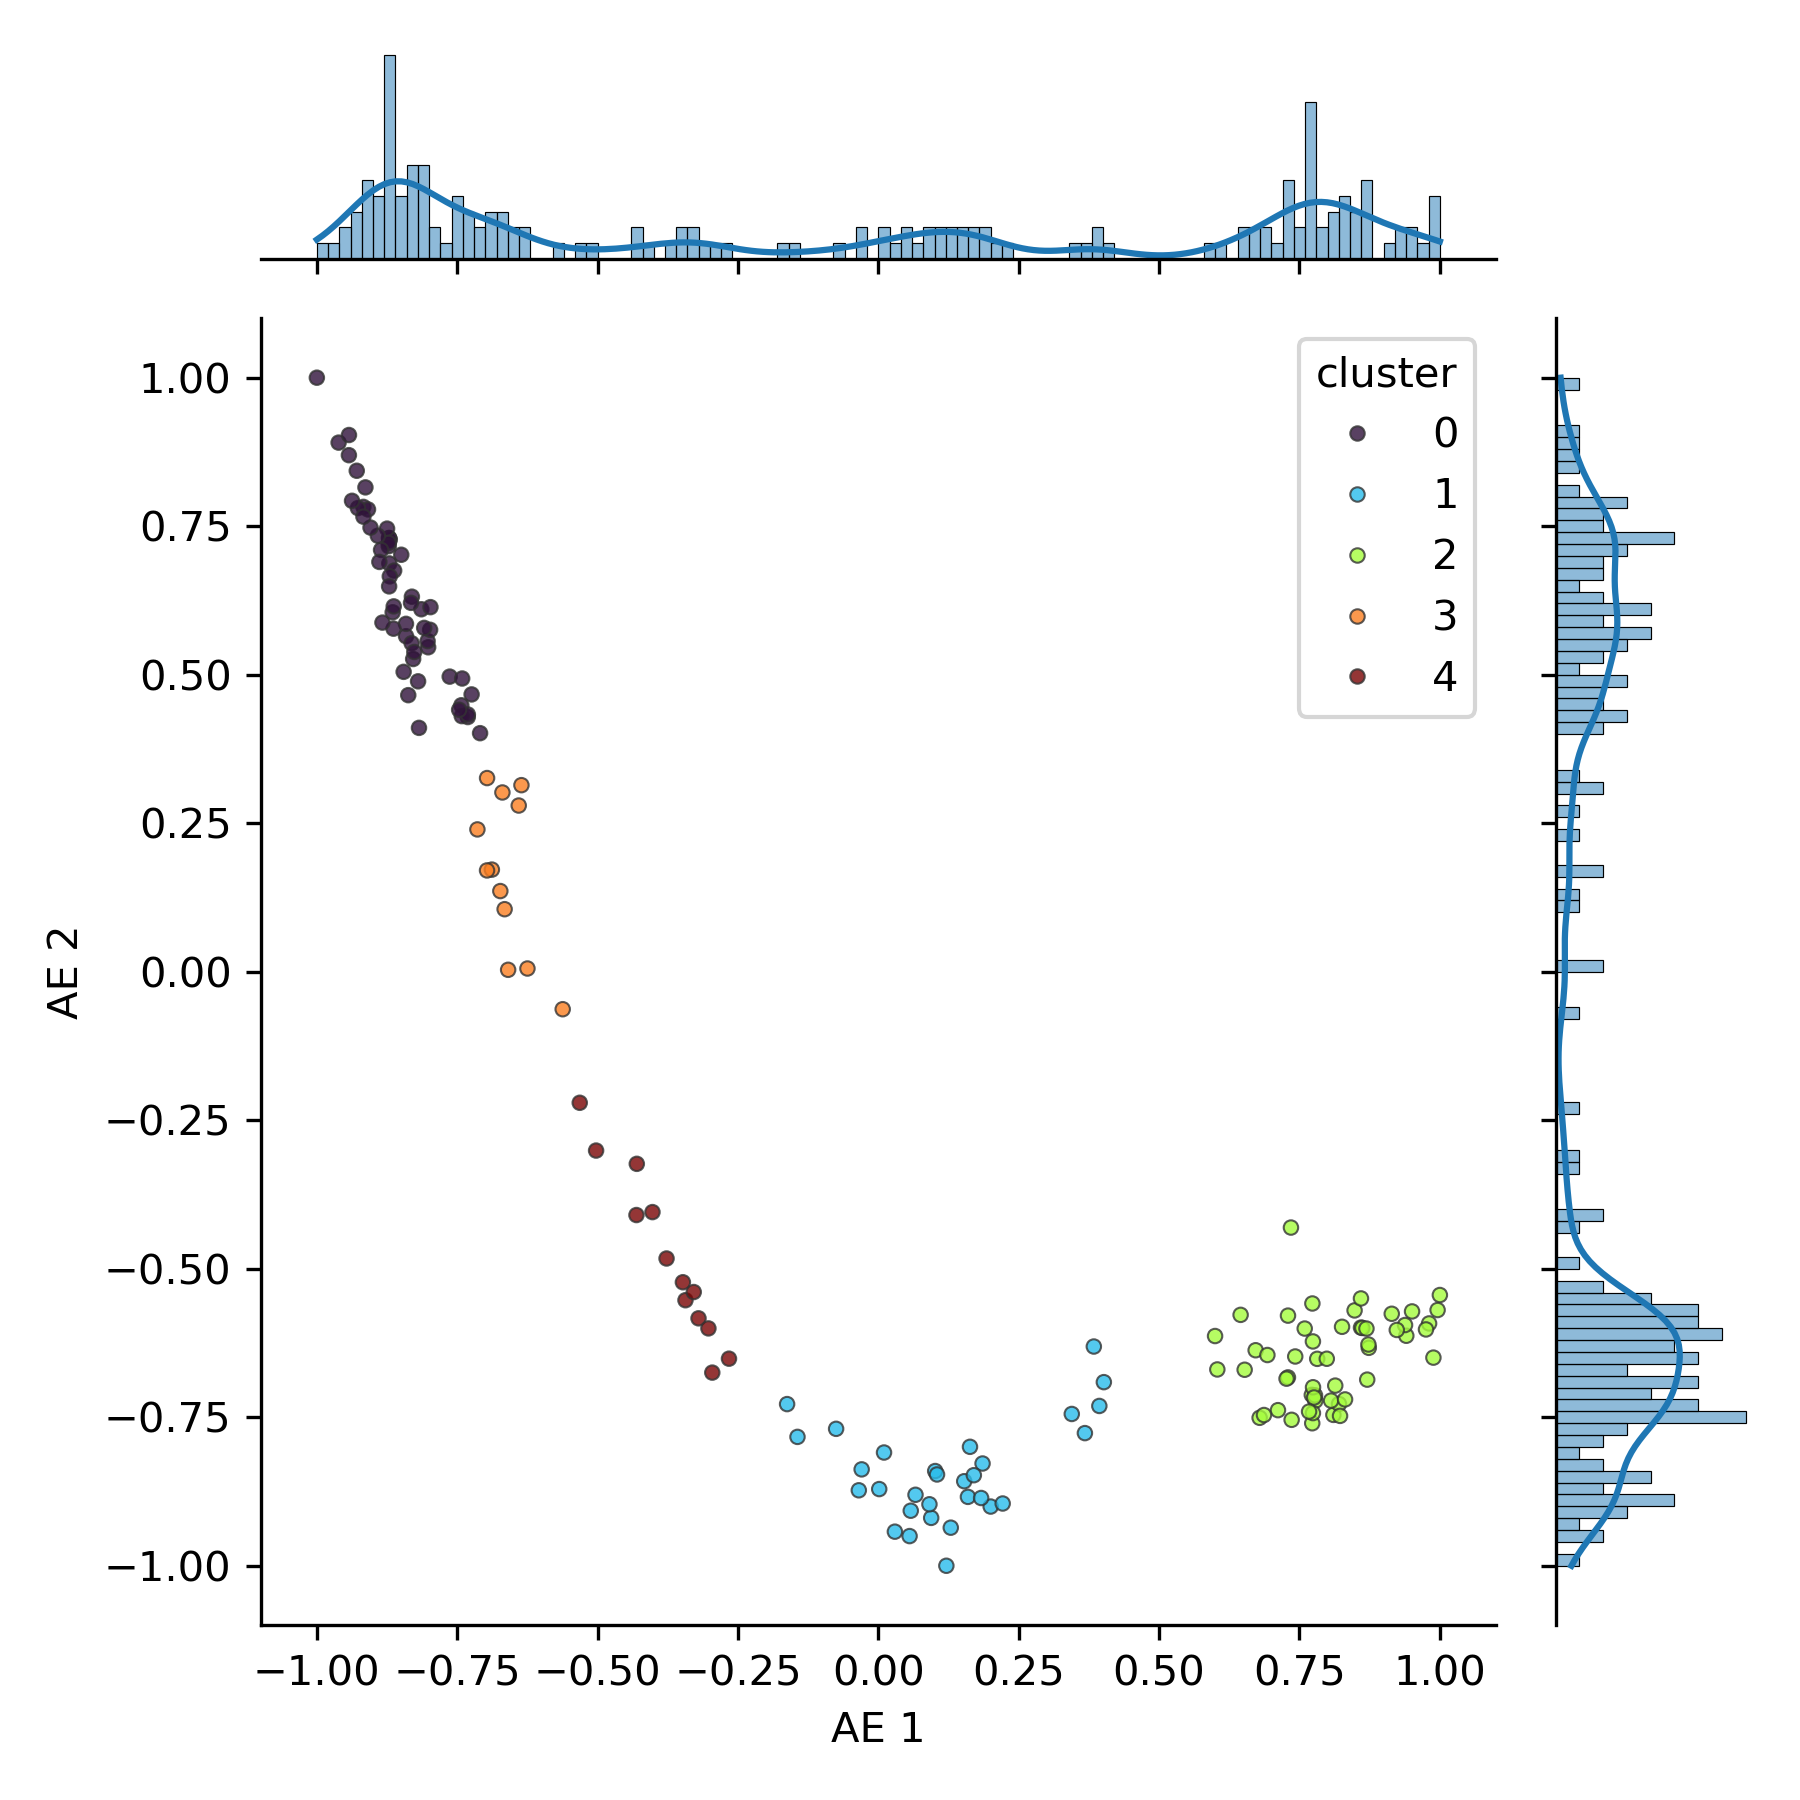

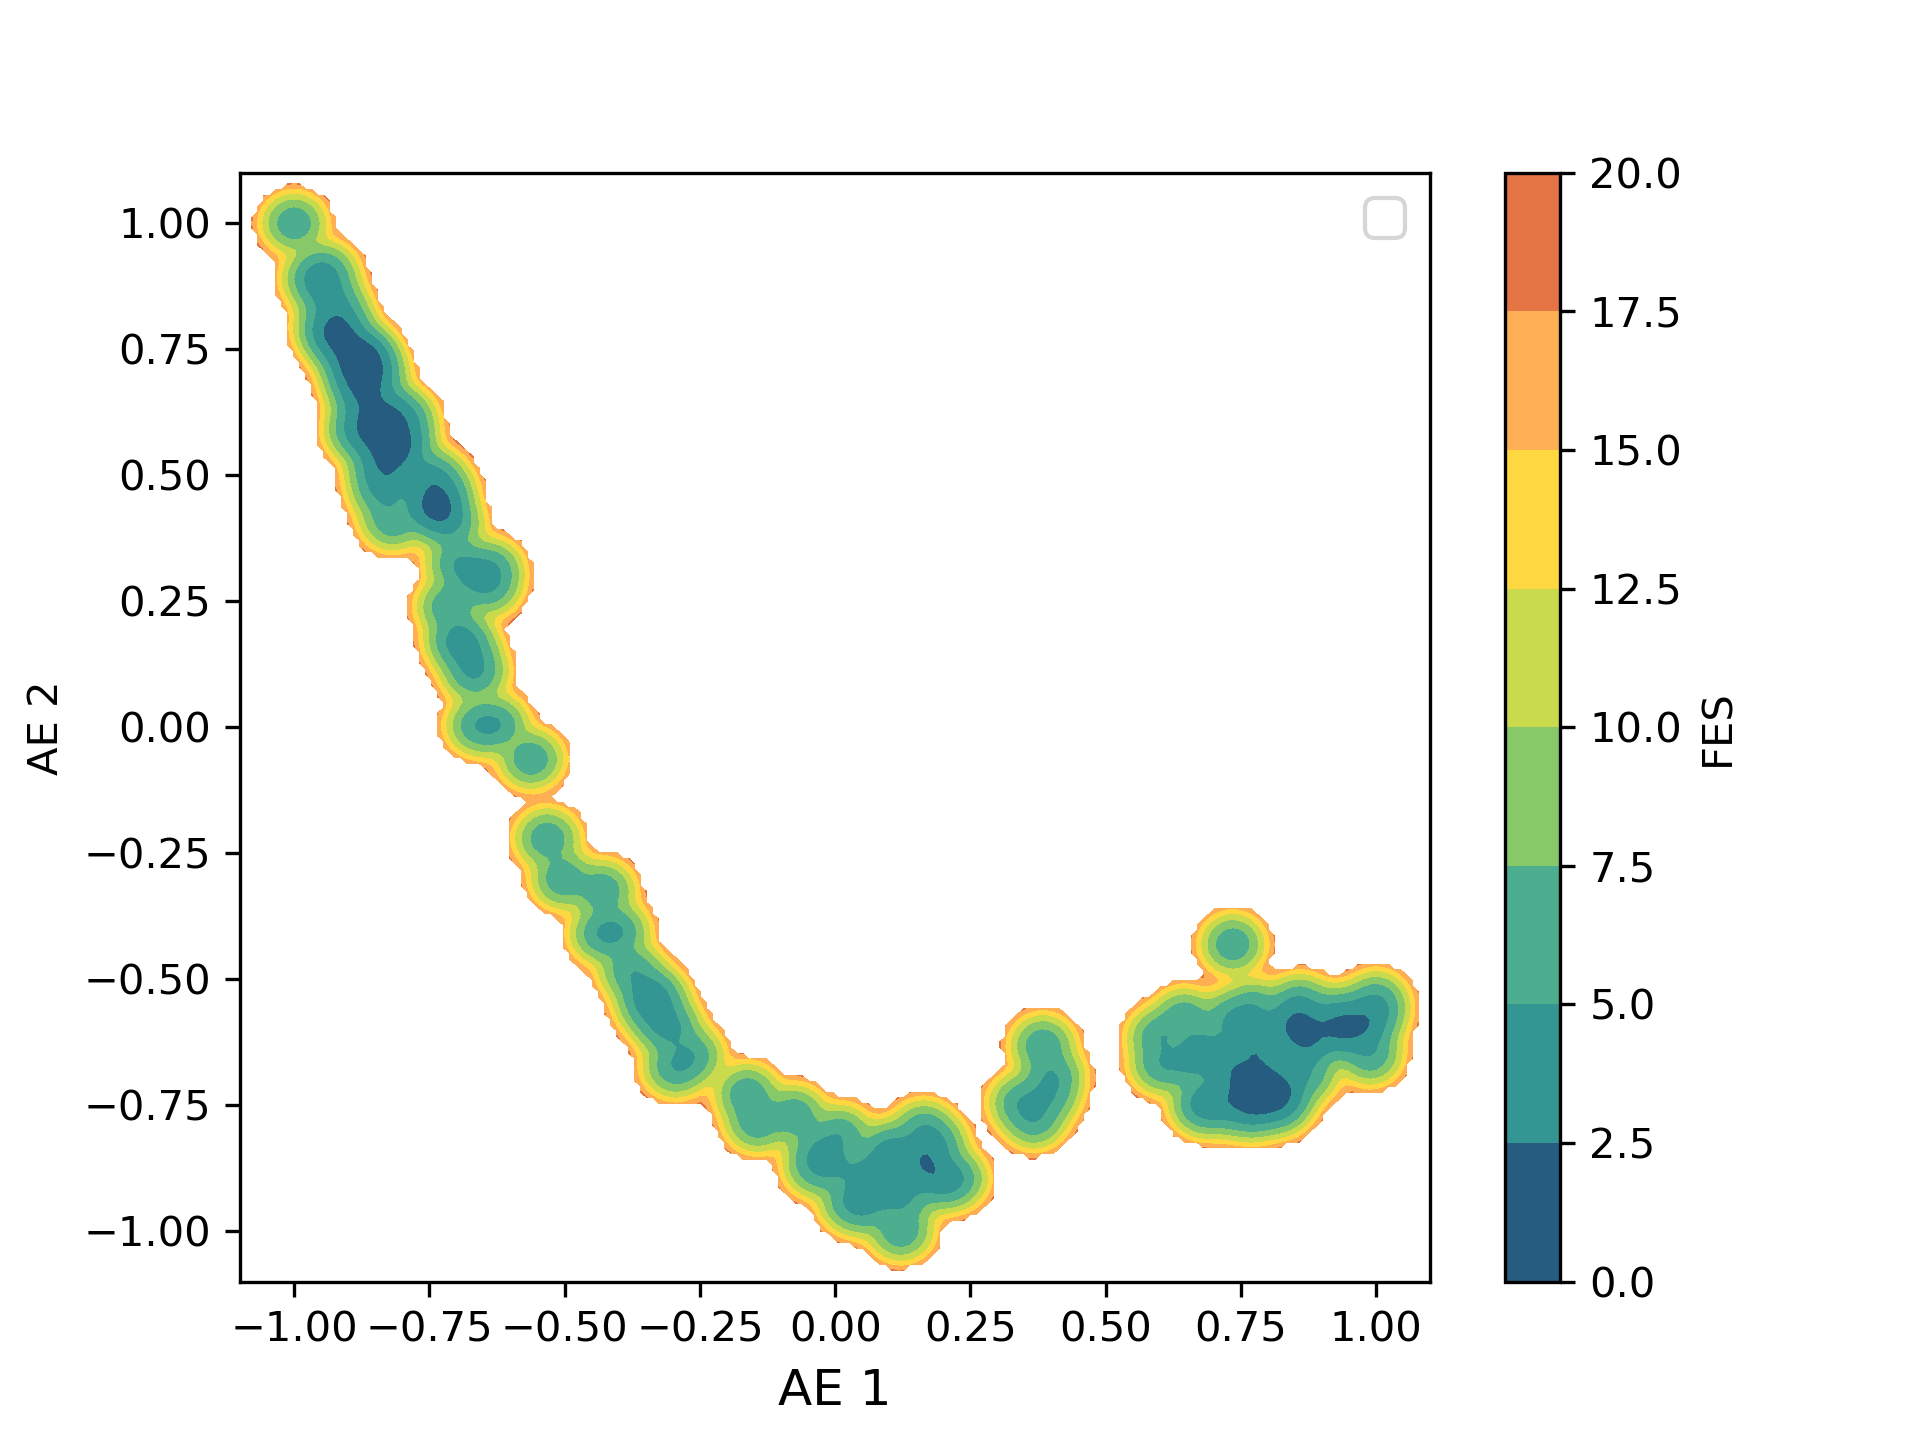

In [39]:
show_results(output_path, model_name = 'ae')

#### TICA

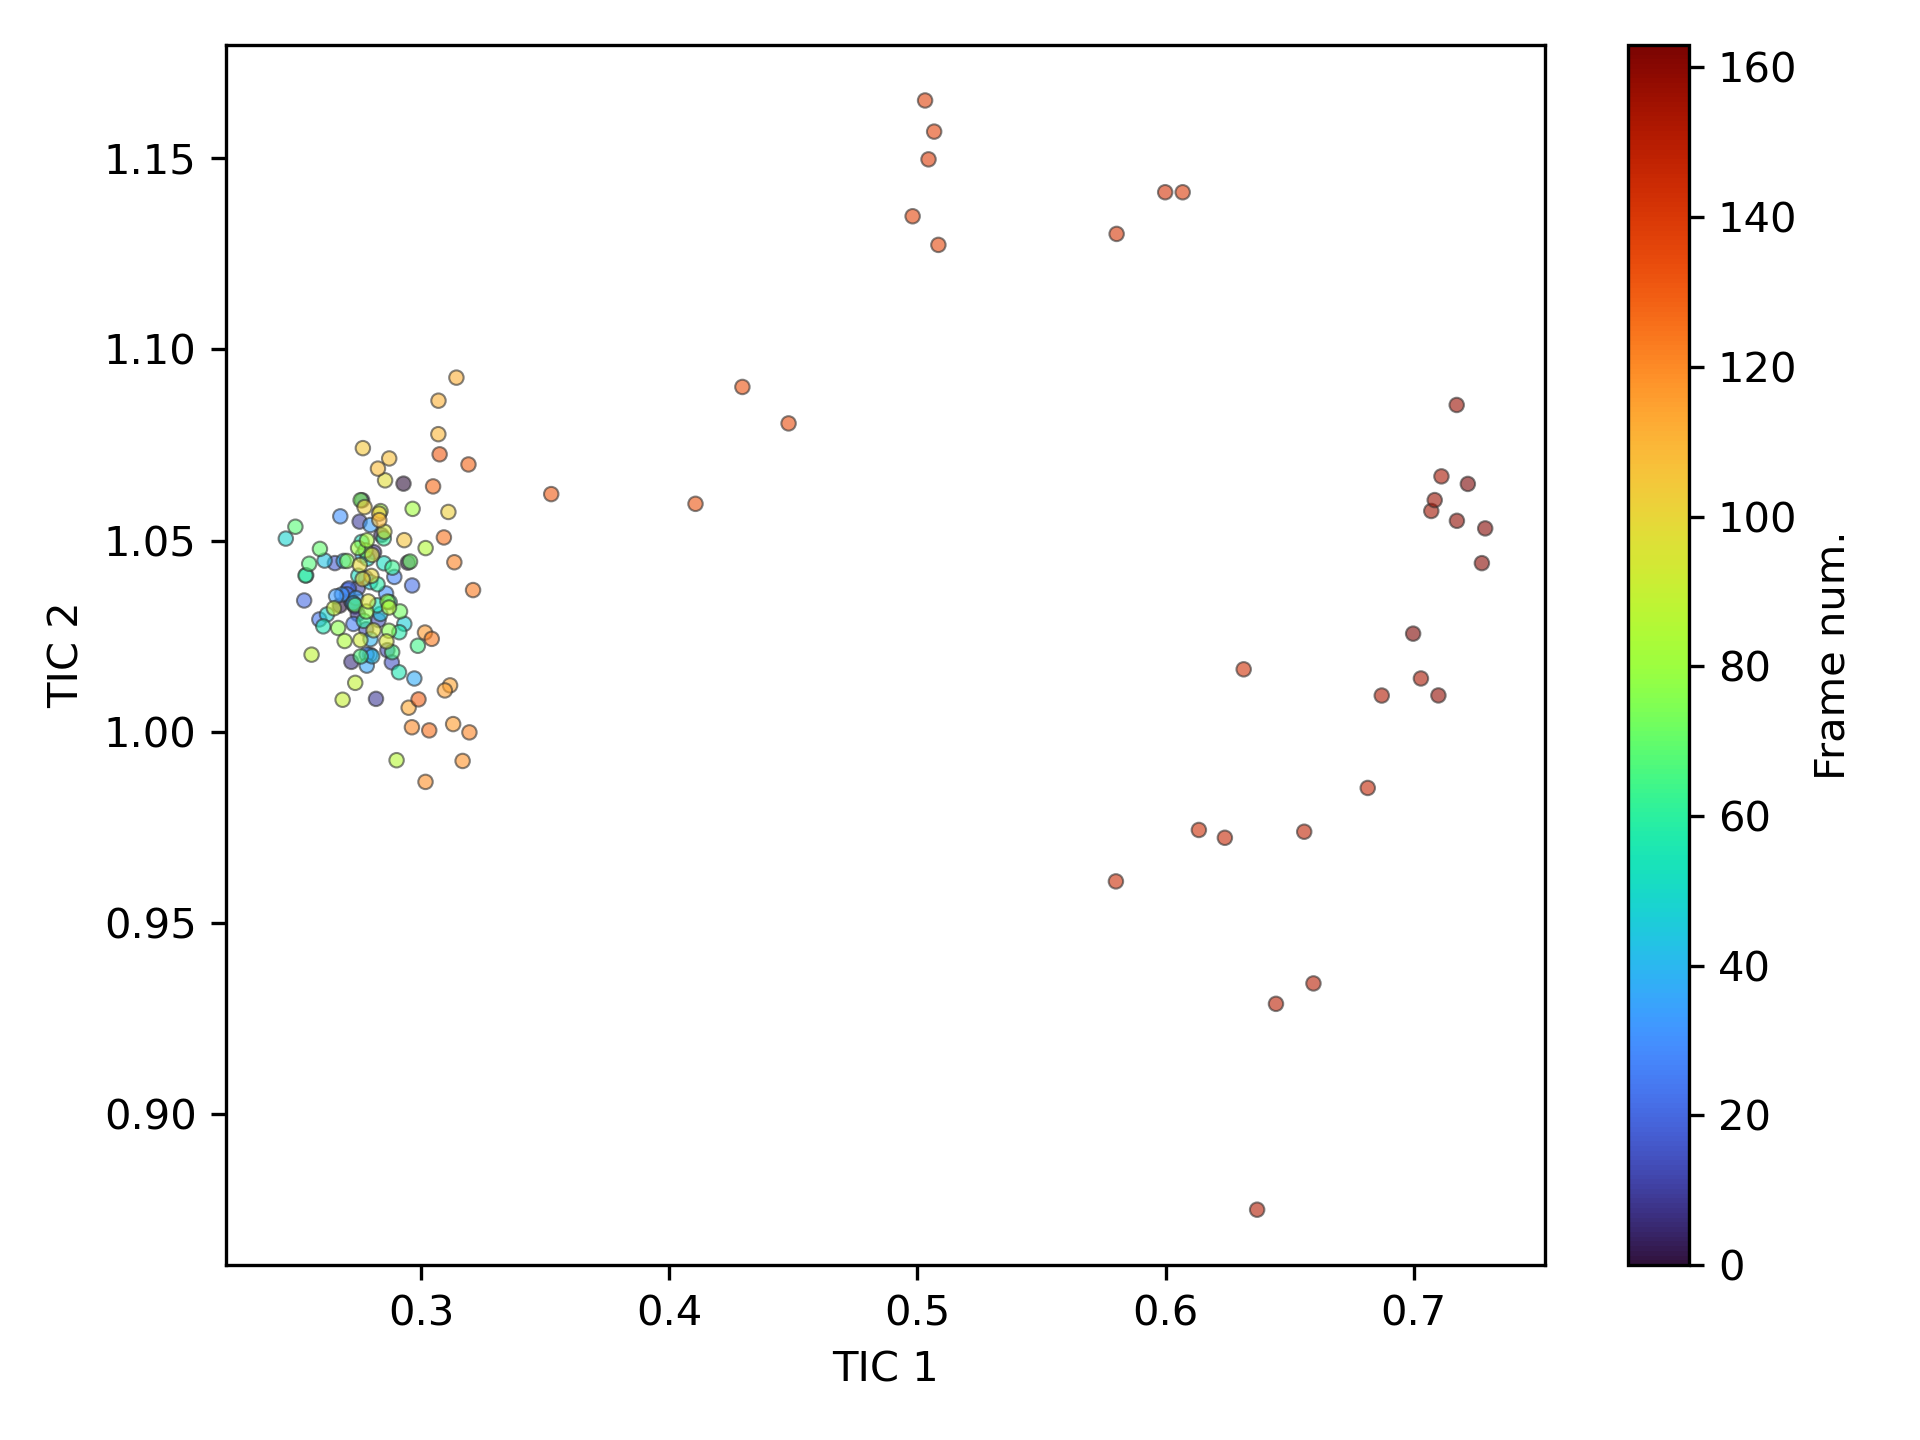

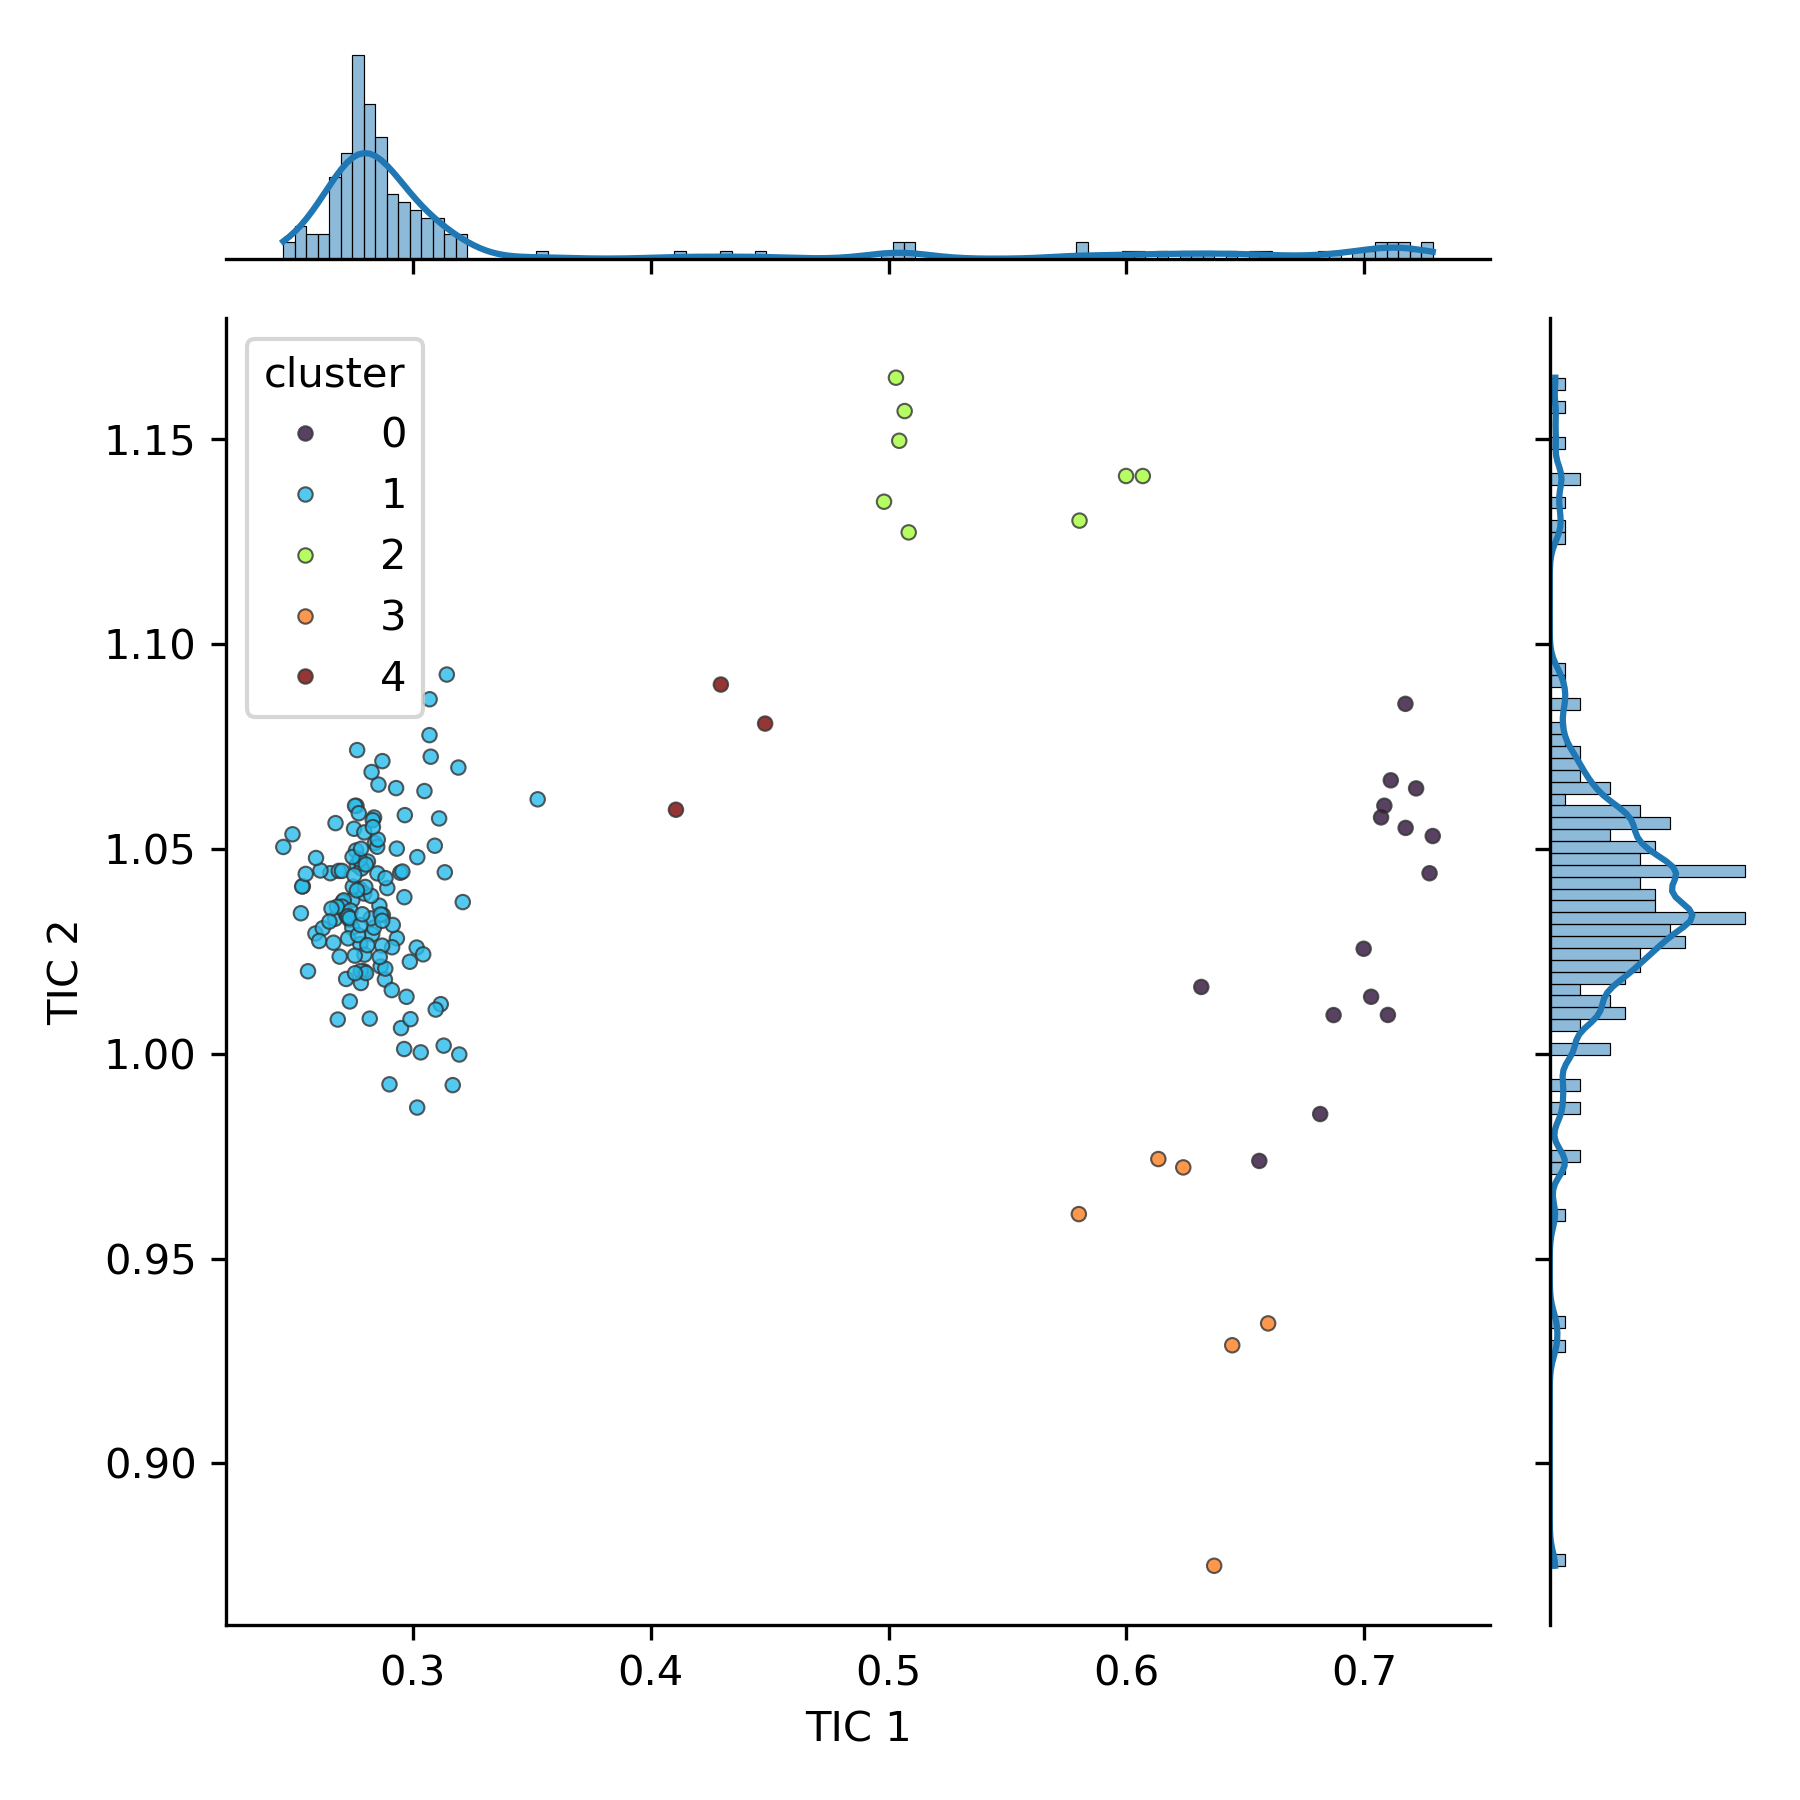

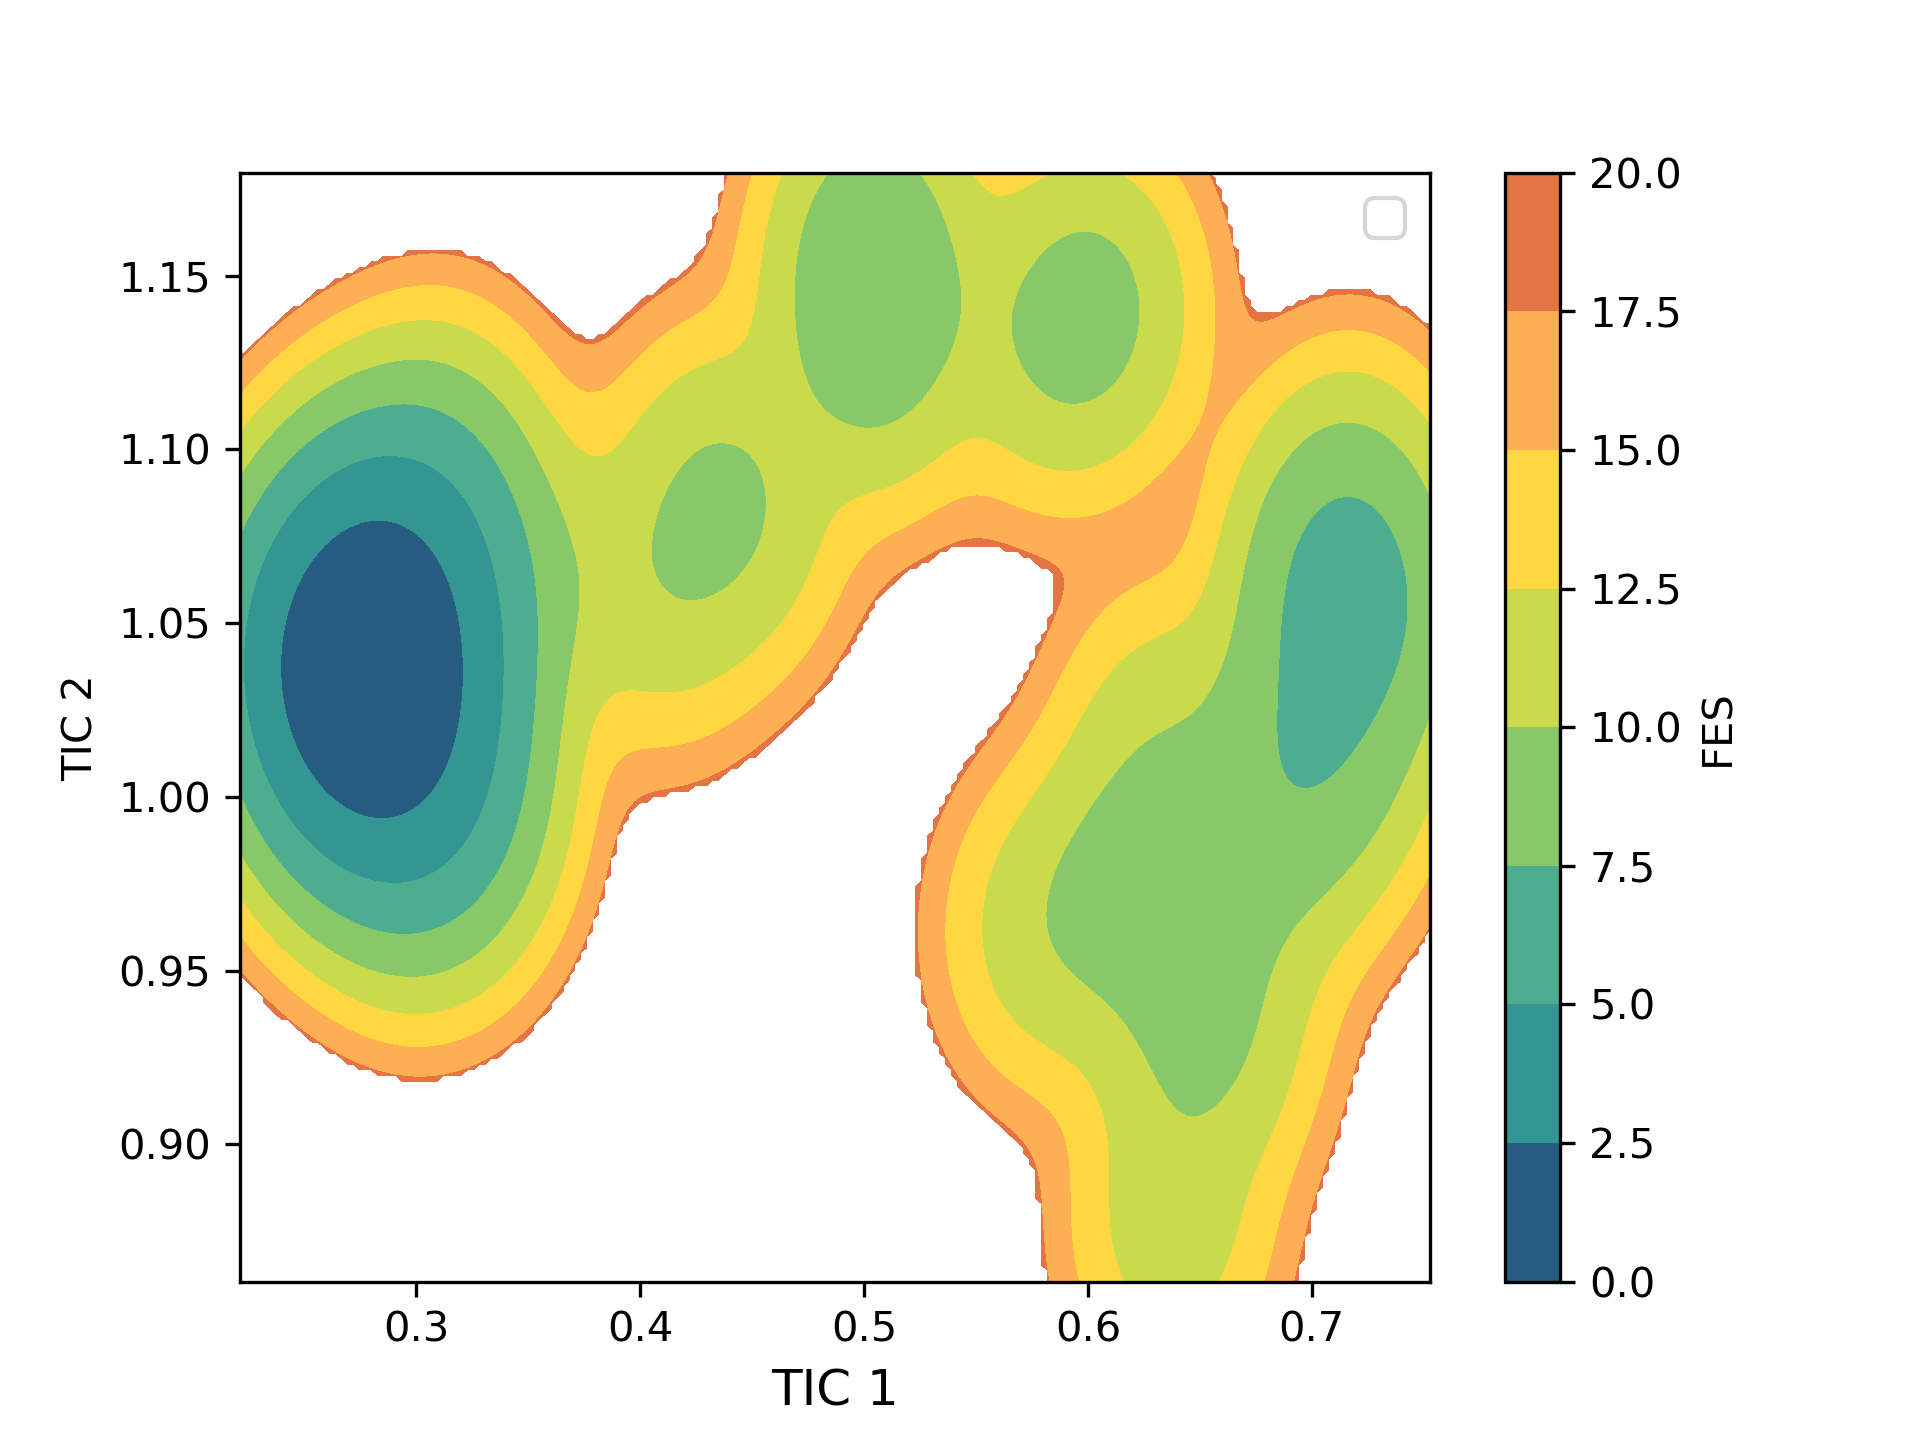

In [40]:
show_results(output_path, model_name = 'tica')

#### Deep TICA

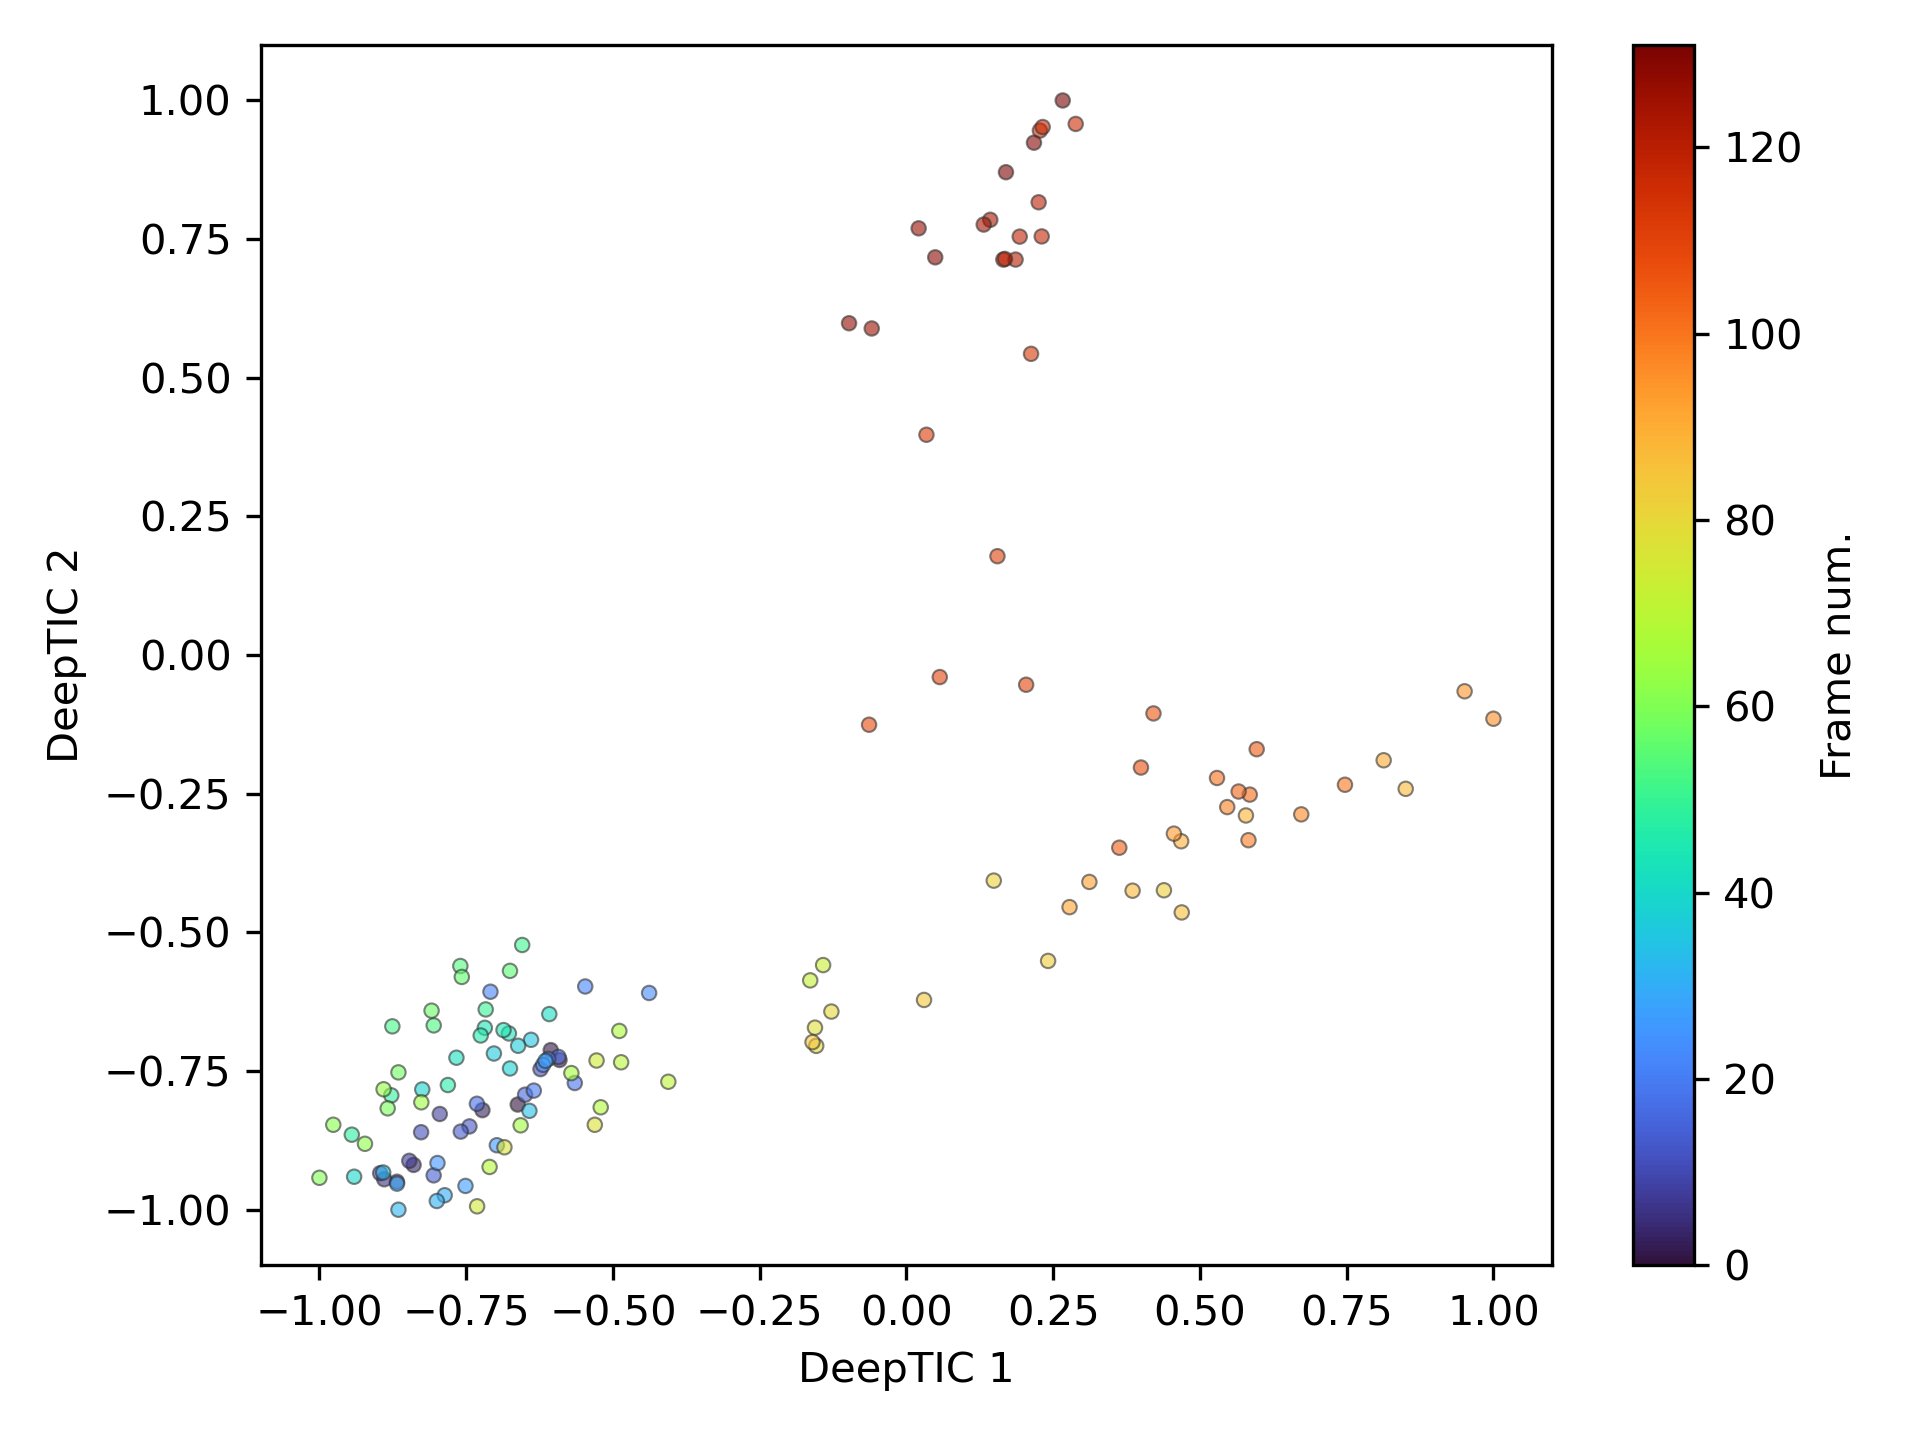

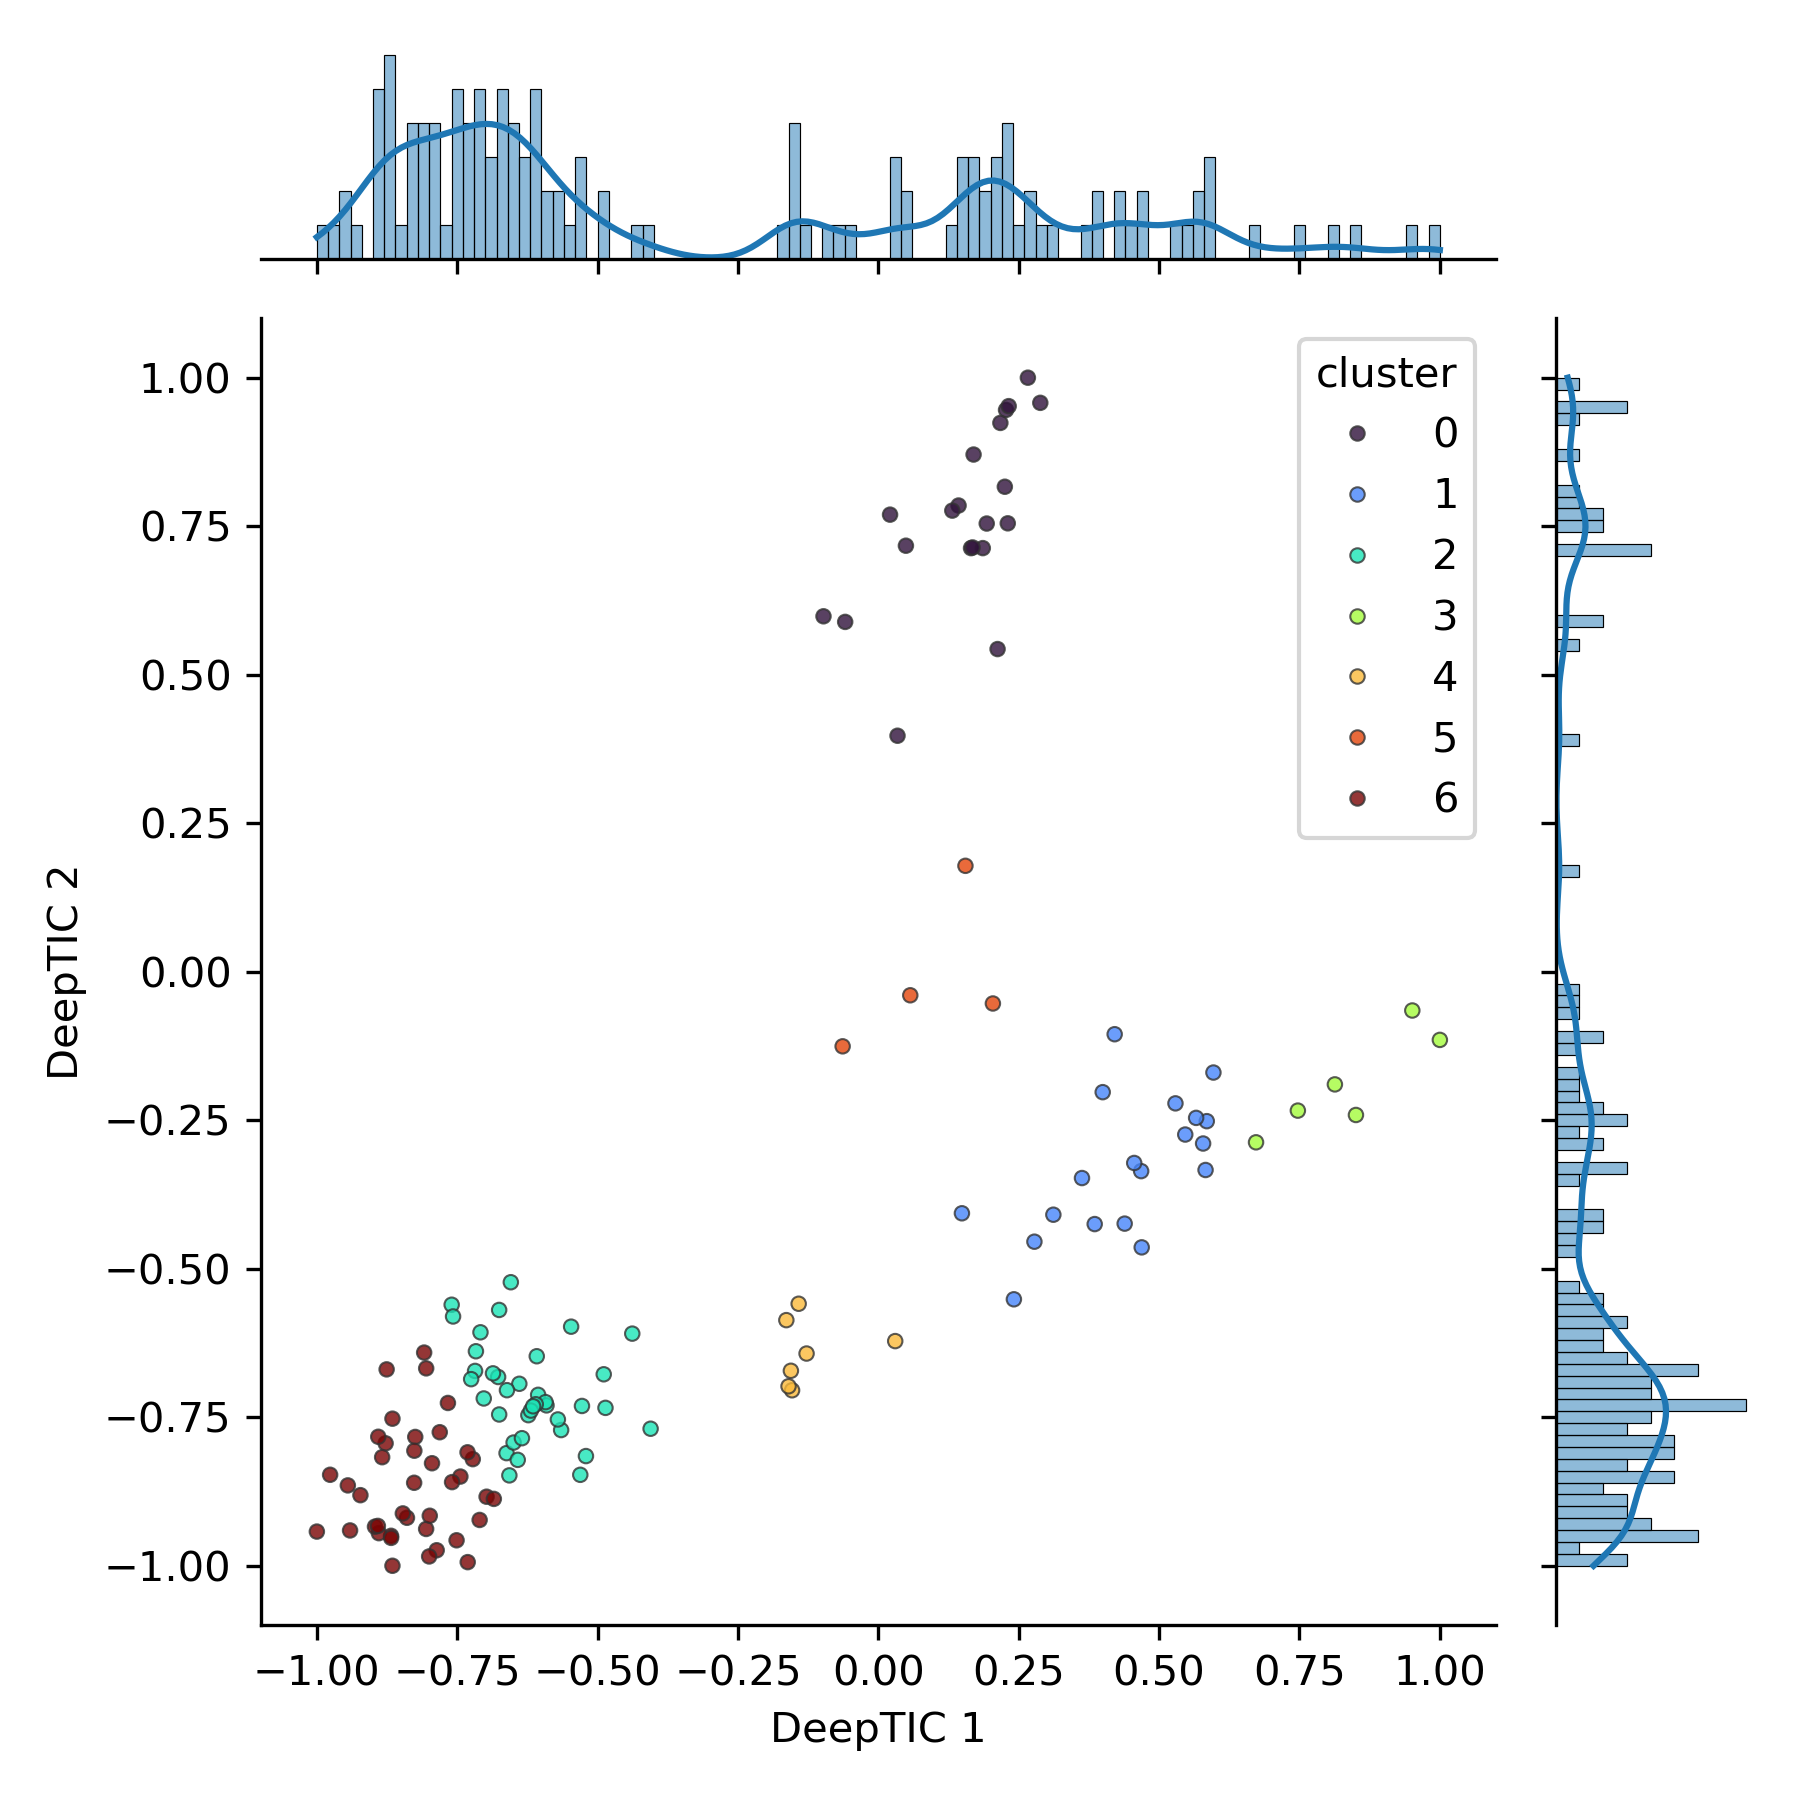

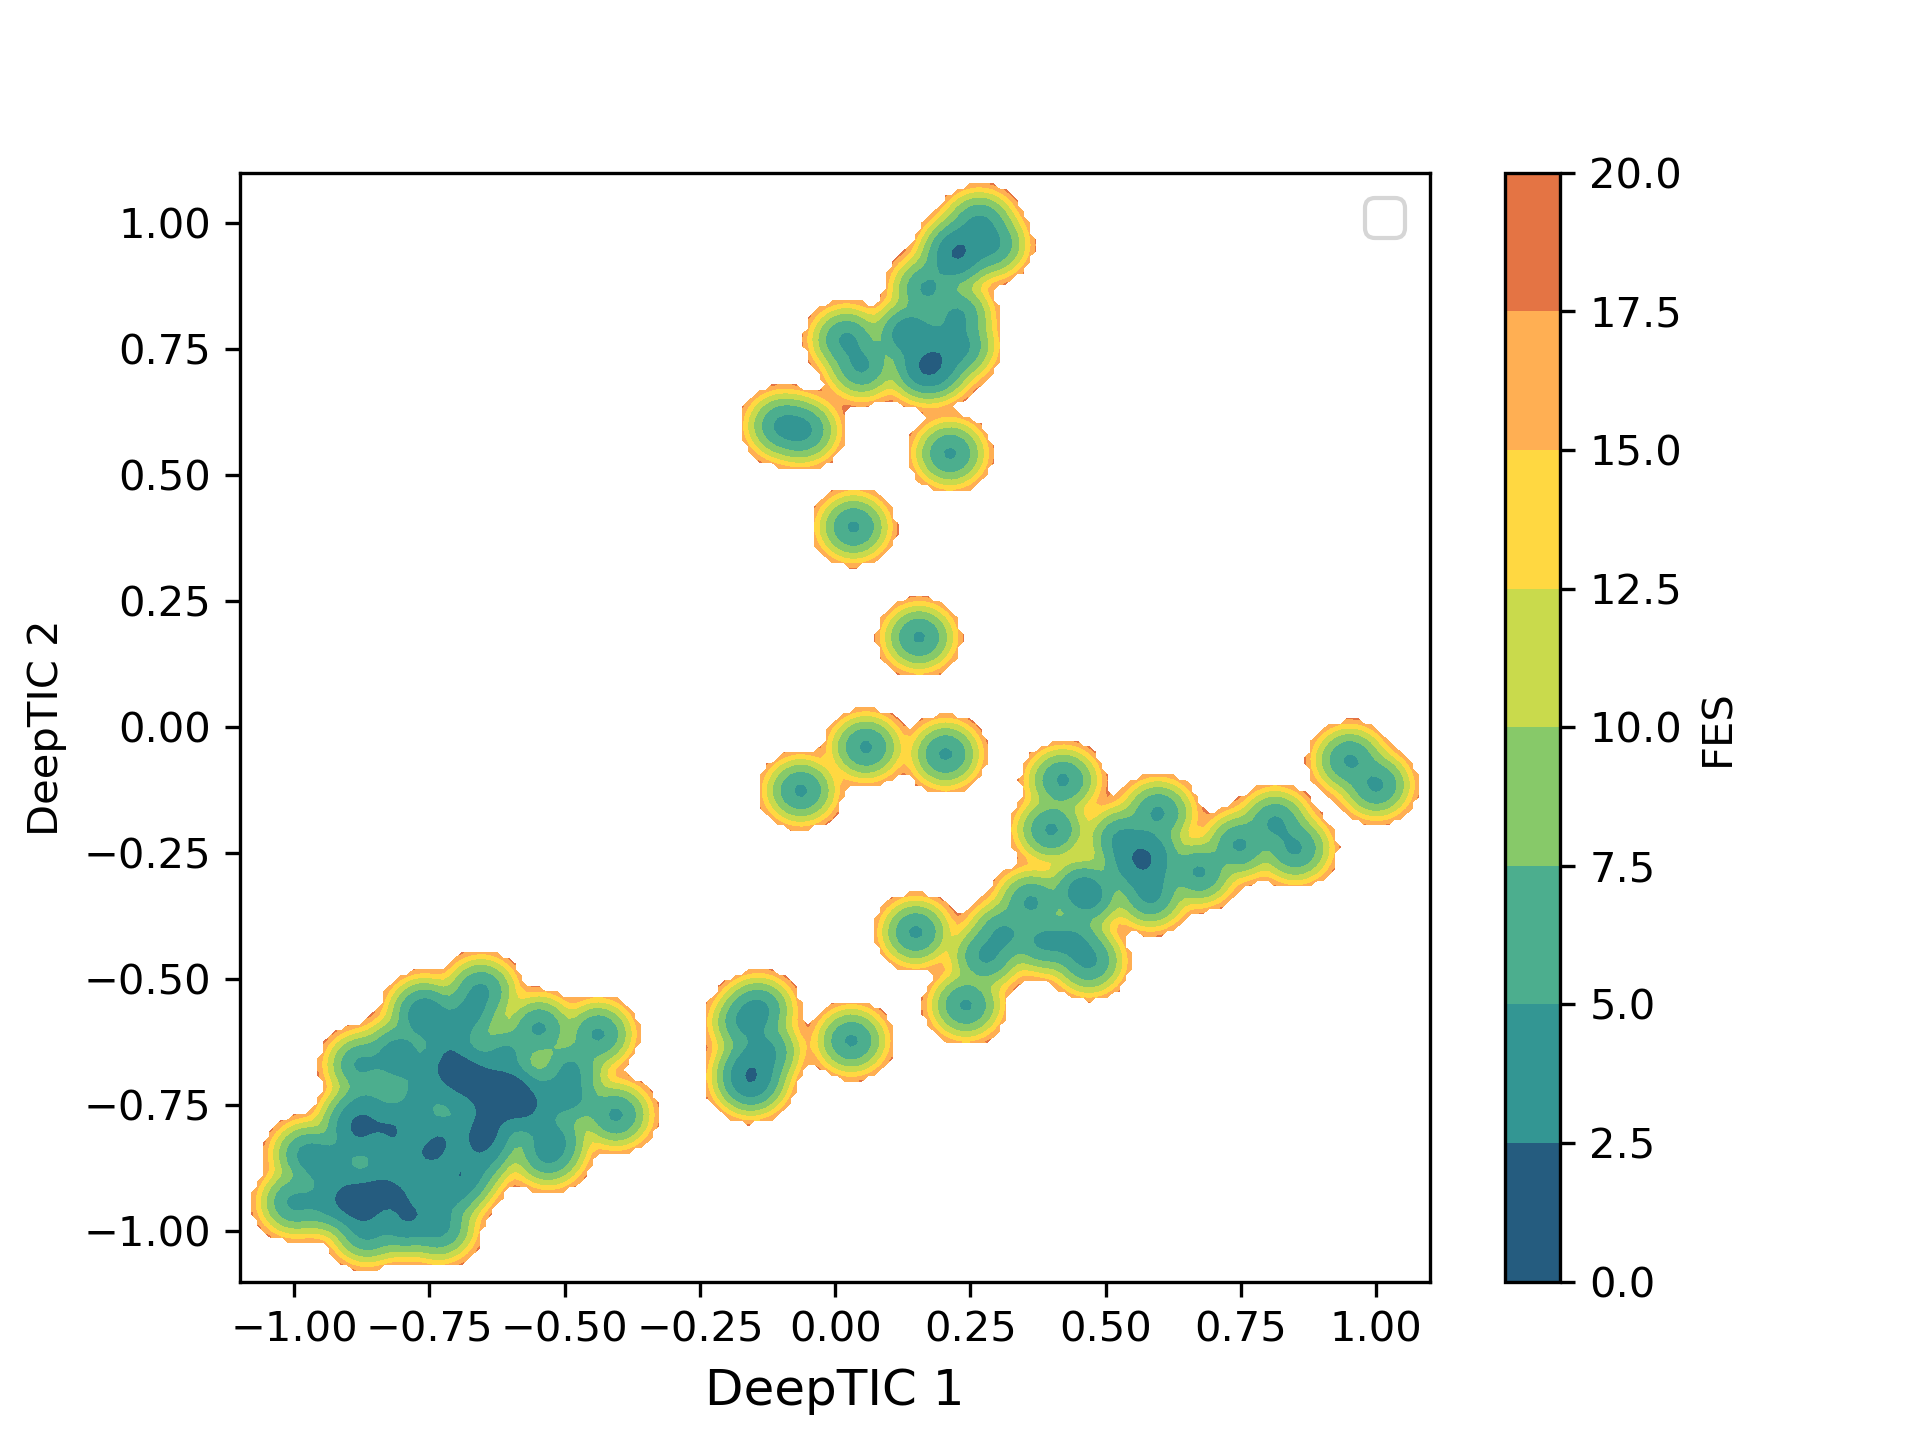

In [41]:
show_results(output_path, model_name = 'deep_tica')

The previous three steps can be run seamlessly using the main API of the package.

In [42]:
from deep_cartograph.run import deep_cartograph 

# Clean all previous steps
for path in [step1_folder, step2_folder, step3_folder]:
    if os.path.exists(path):
        shutil.rmtree(path)

# Output folder for the full workflow
output_folder = os.path.join(output_path, 'torsions')

# Clean output folder
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

################
# Run workflow #
################

deep_cartograph(
    configuration = configuration,
    trajectory = traj_path,
    topology = top_path,
    output_folder = output_folder)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.w

INFO:deep_cartograph.tools.filter_features.filtering:Filtered 148 features.
INFO:deep_cartograph.modules.amino.amino:Skipping AMINO clustering.
INFO:deep_cartograph:Elapsed time (Filter features): 00 h 00 min 00 s
INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of Collective Variables
INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of collective variables using the mlcolvar library.
INFO:deep_cartograph:Creating datasets from colvars...
INFO:deep_cartograph:Number of samples: 164
INFO:deep_cartograph:Number of features: 54
INFO:deep_cartograph.tools.train_colvars.utils:Calculating PCA...
INFO:deep_cartograph.modules.figures.figures:Computing FES(PC 1, PC 2)...
/home/pnavarro/repos/NBDsoftware/CV_learning/deep_cartograph/deep_cartograph/modules/figures/figures.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Using distances as features

In [43]:
# Output folder for the full workflow
output_folder = os.path.join(output_path, 'distances')

# Clean output folder
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Input configuration
config_path = "../../data/calpha_transitions/input/distances_config.yml"

with open(config_path) as config_file:
    configuration = yaml.load(config_file, Loader = yaml.FullLoader)

################
# Run workflow #
################

deep_cartograph(
    configuration = configuration,
    trajectory = traj_path,
    topology = top_path,
    output_folder = output_folder)

trained_colvars_path = os.path.join(output_folder, "train_colvars")

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.w

INFO:deep_cartograph:Elapsed time (Compute features): 00 h 00 min 01 s
INFO:deep_cartograph:==================
INFO:deep_cartograph:Filtering features
INFO:deep_cartograph:==================
INFO:deep_cartograph:Finding the features that contains the most information about the transitions or conformational changes.
INFO:deep_cartograph:The following algorithms are available:
INFO:deep_cartograph:- Hartigan's dip test filter. Keeps features that are not unimodal.
INFO:deep_cartograph:- Shannon entropy filter. Keeps features with entropy greater than a threshold.
INFO:deep_cartograph:- Standard deviation filter. Keeps features with standard deviation greater than a threshold.
INFO:deep_cartograph:- Final Mutual information clustering (AMINO). Clusters filtered features according to a mutual information based distance and selects one feature per cluster minimizing the distorsion.
INFO:deep_cartograph:Note that the all features must be in the same units to apply the entropy and standard de

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### PCA

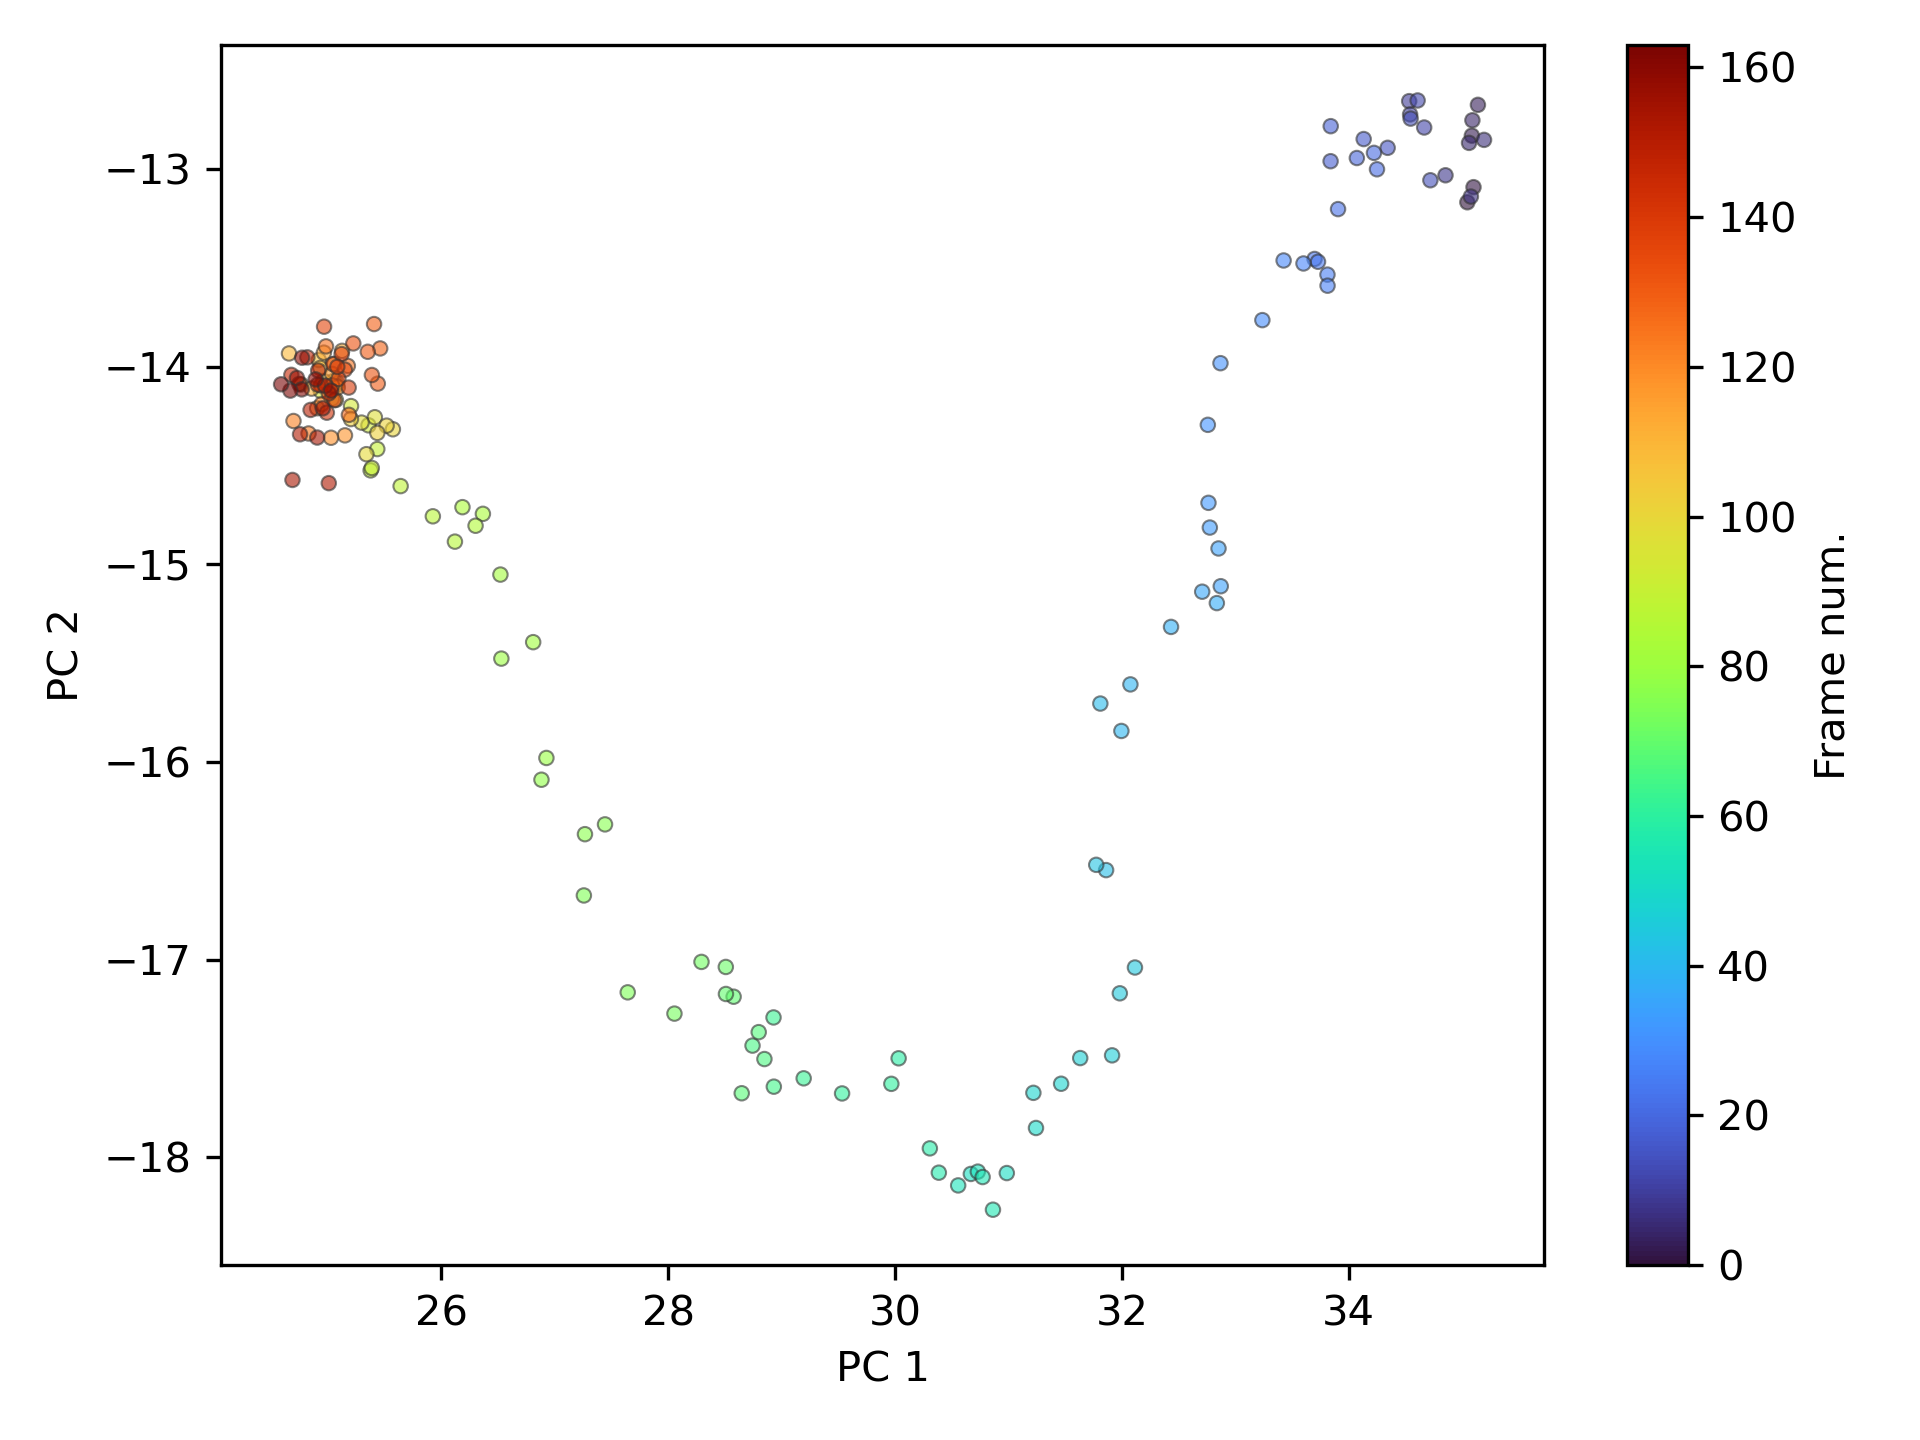

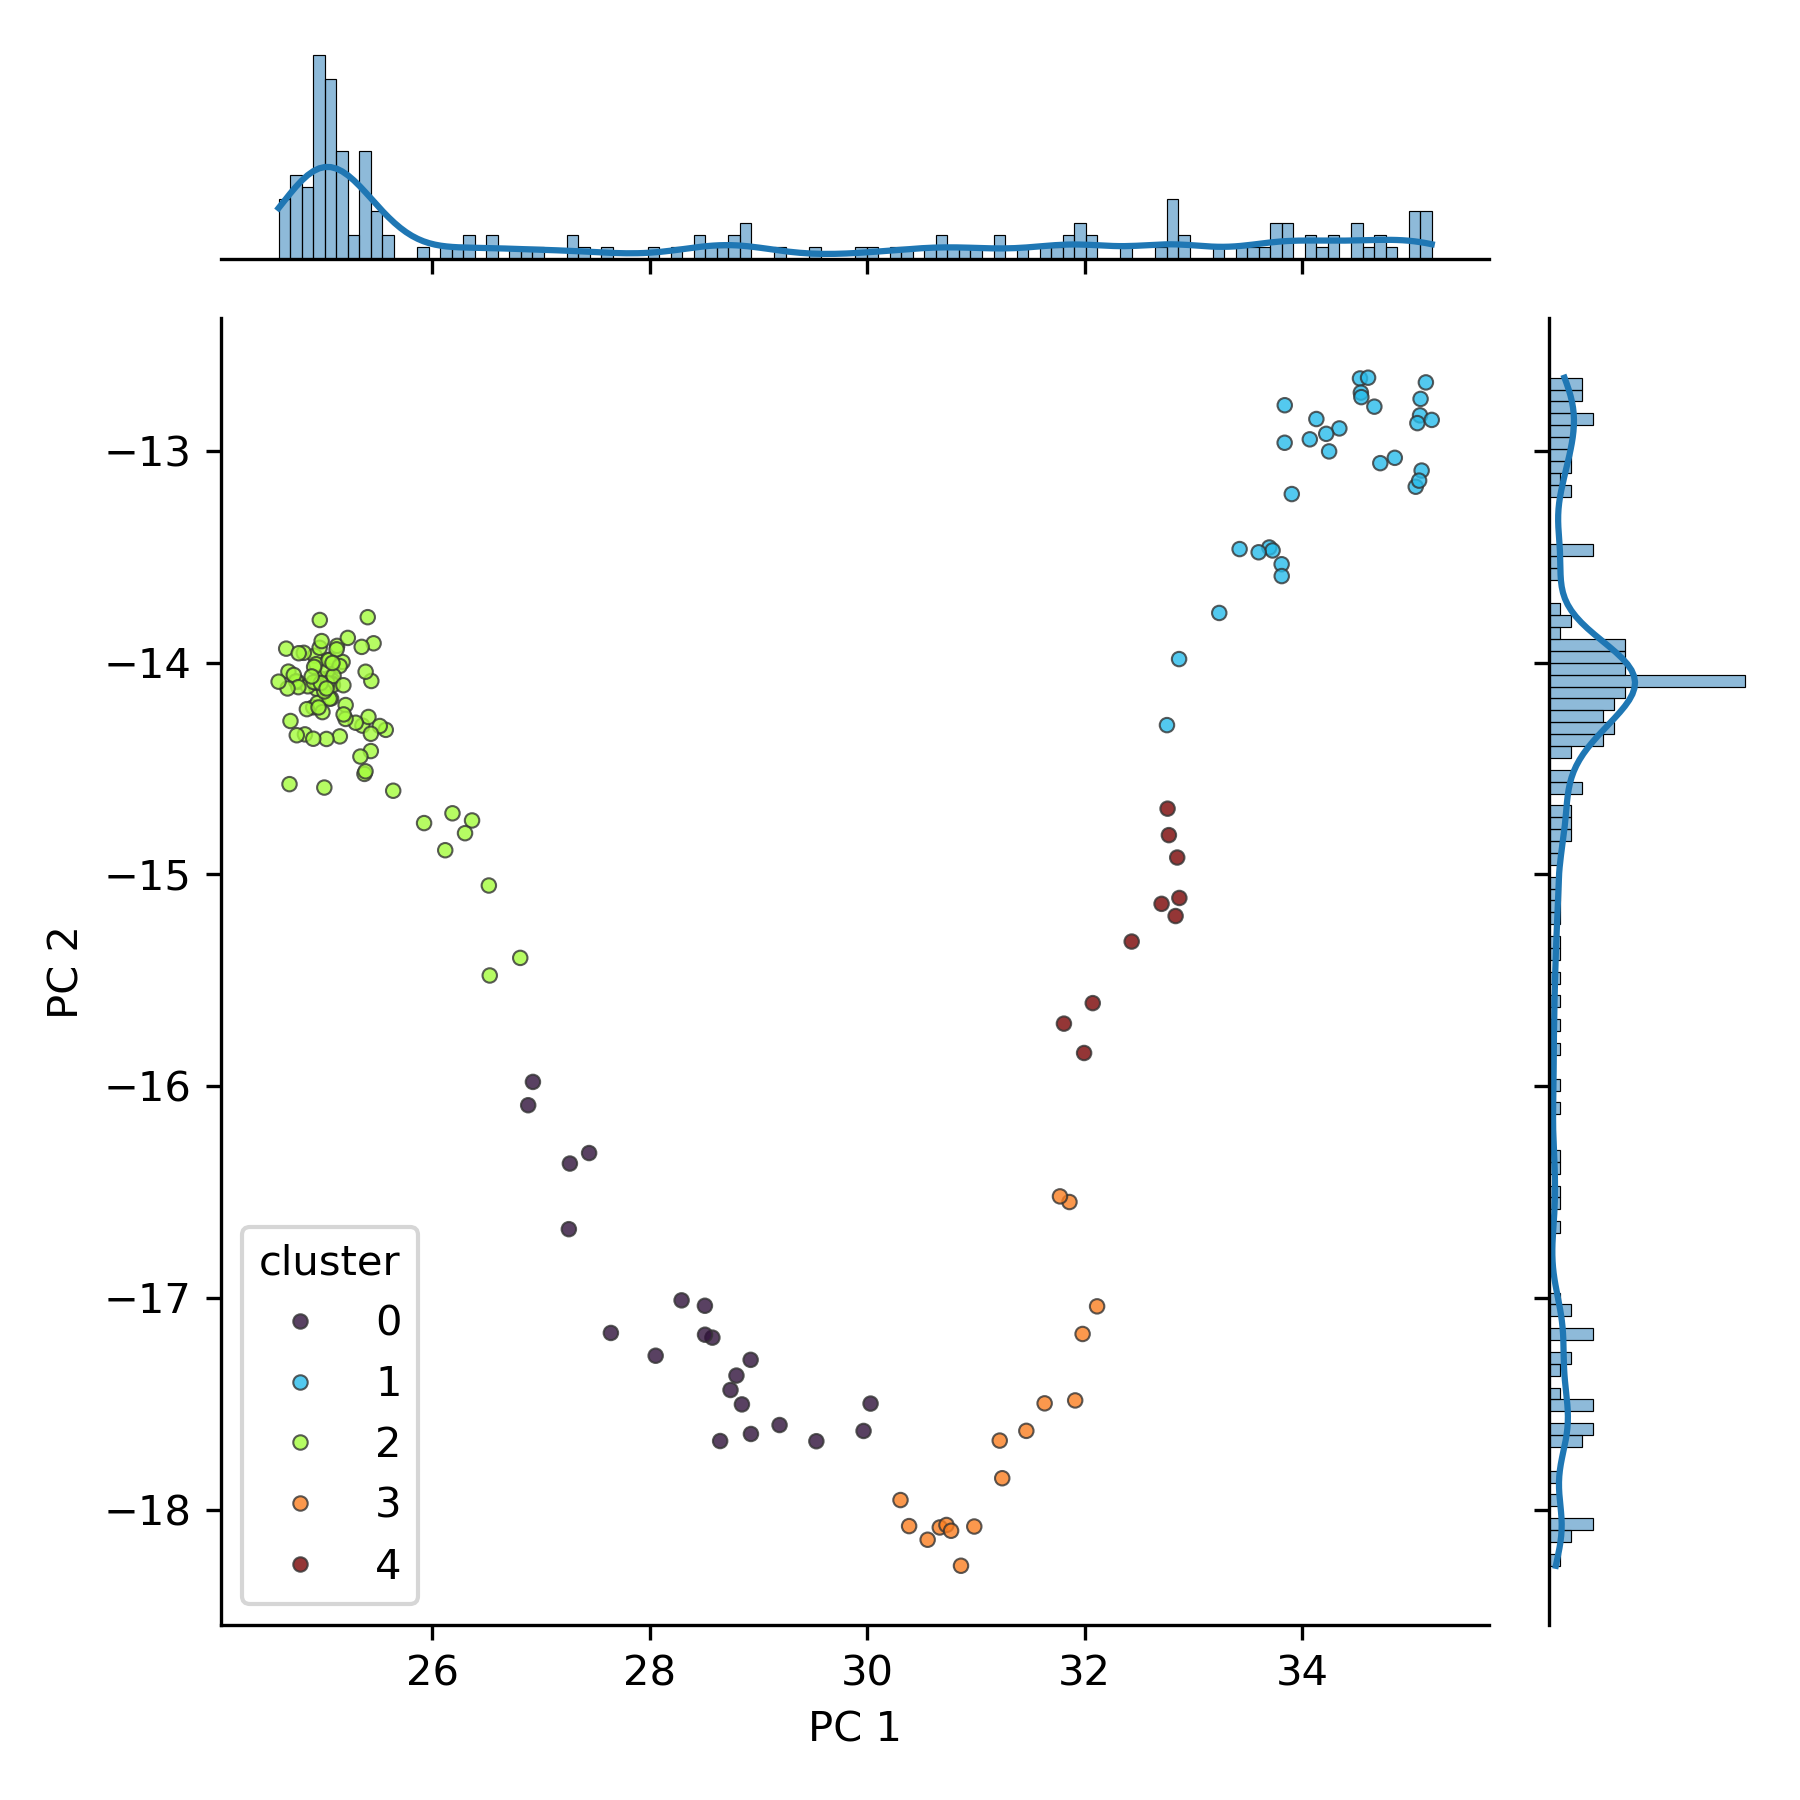

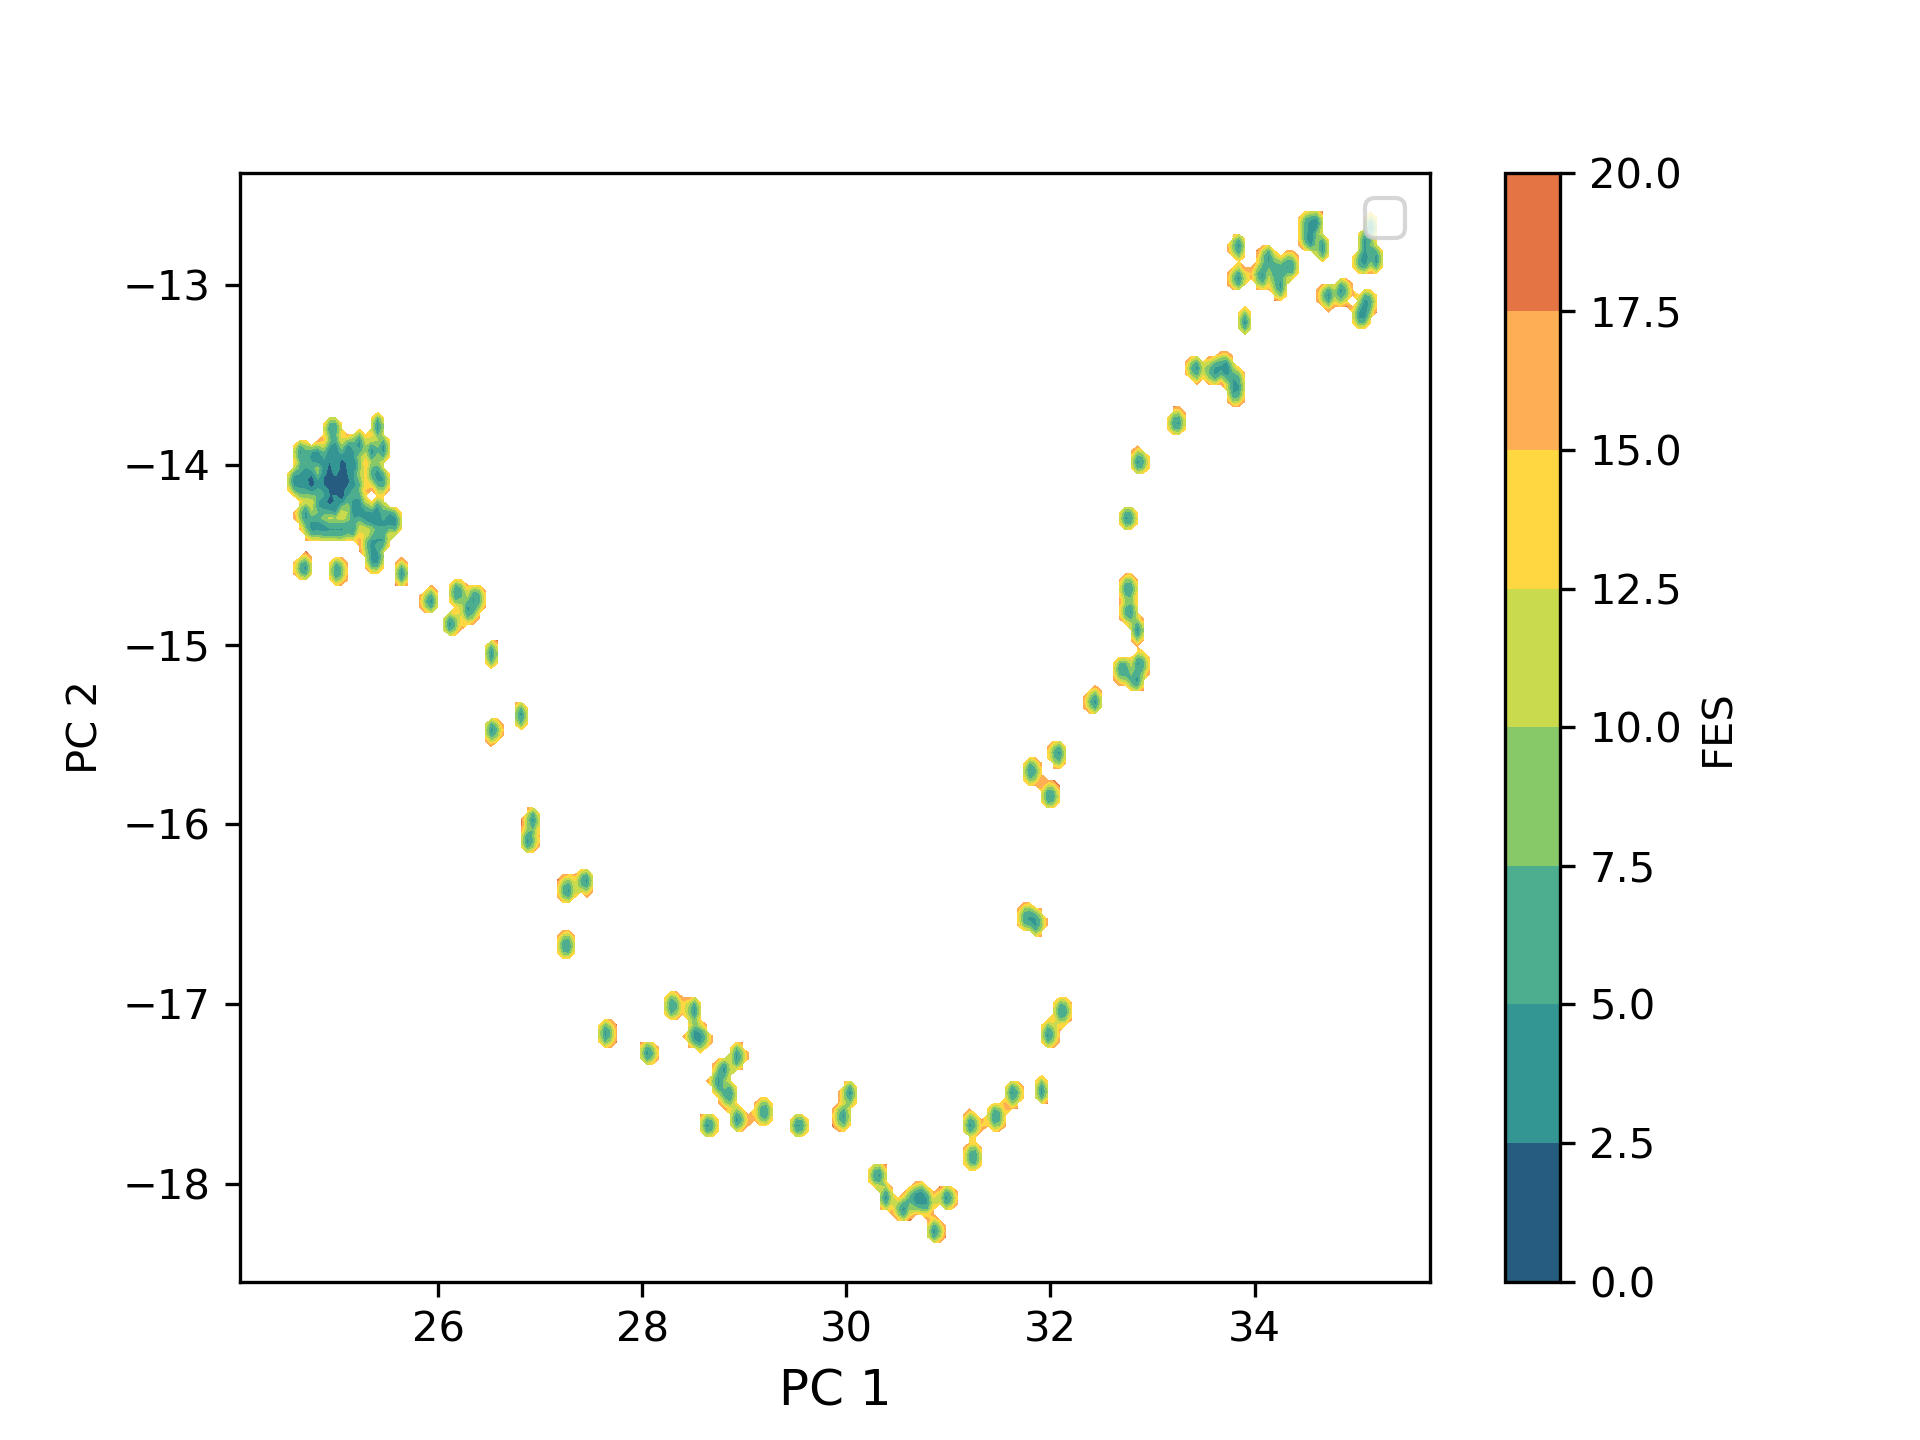

In [44]:
show_results(output_folder, model_name = 'pca')

#### AE

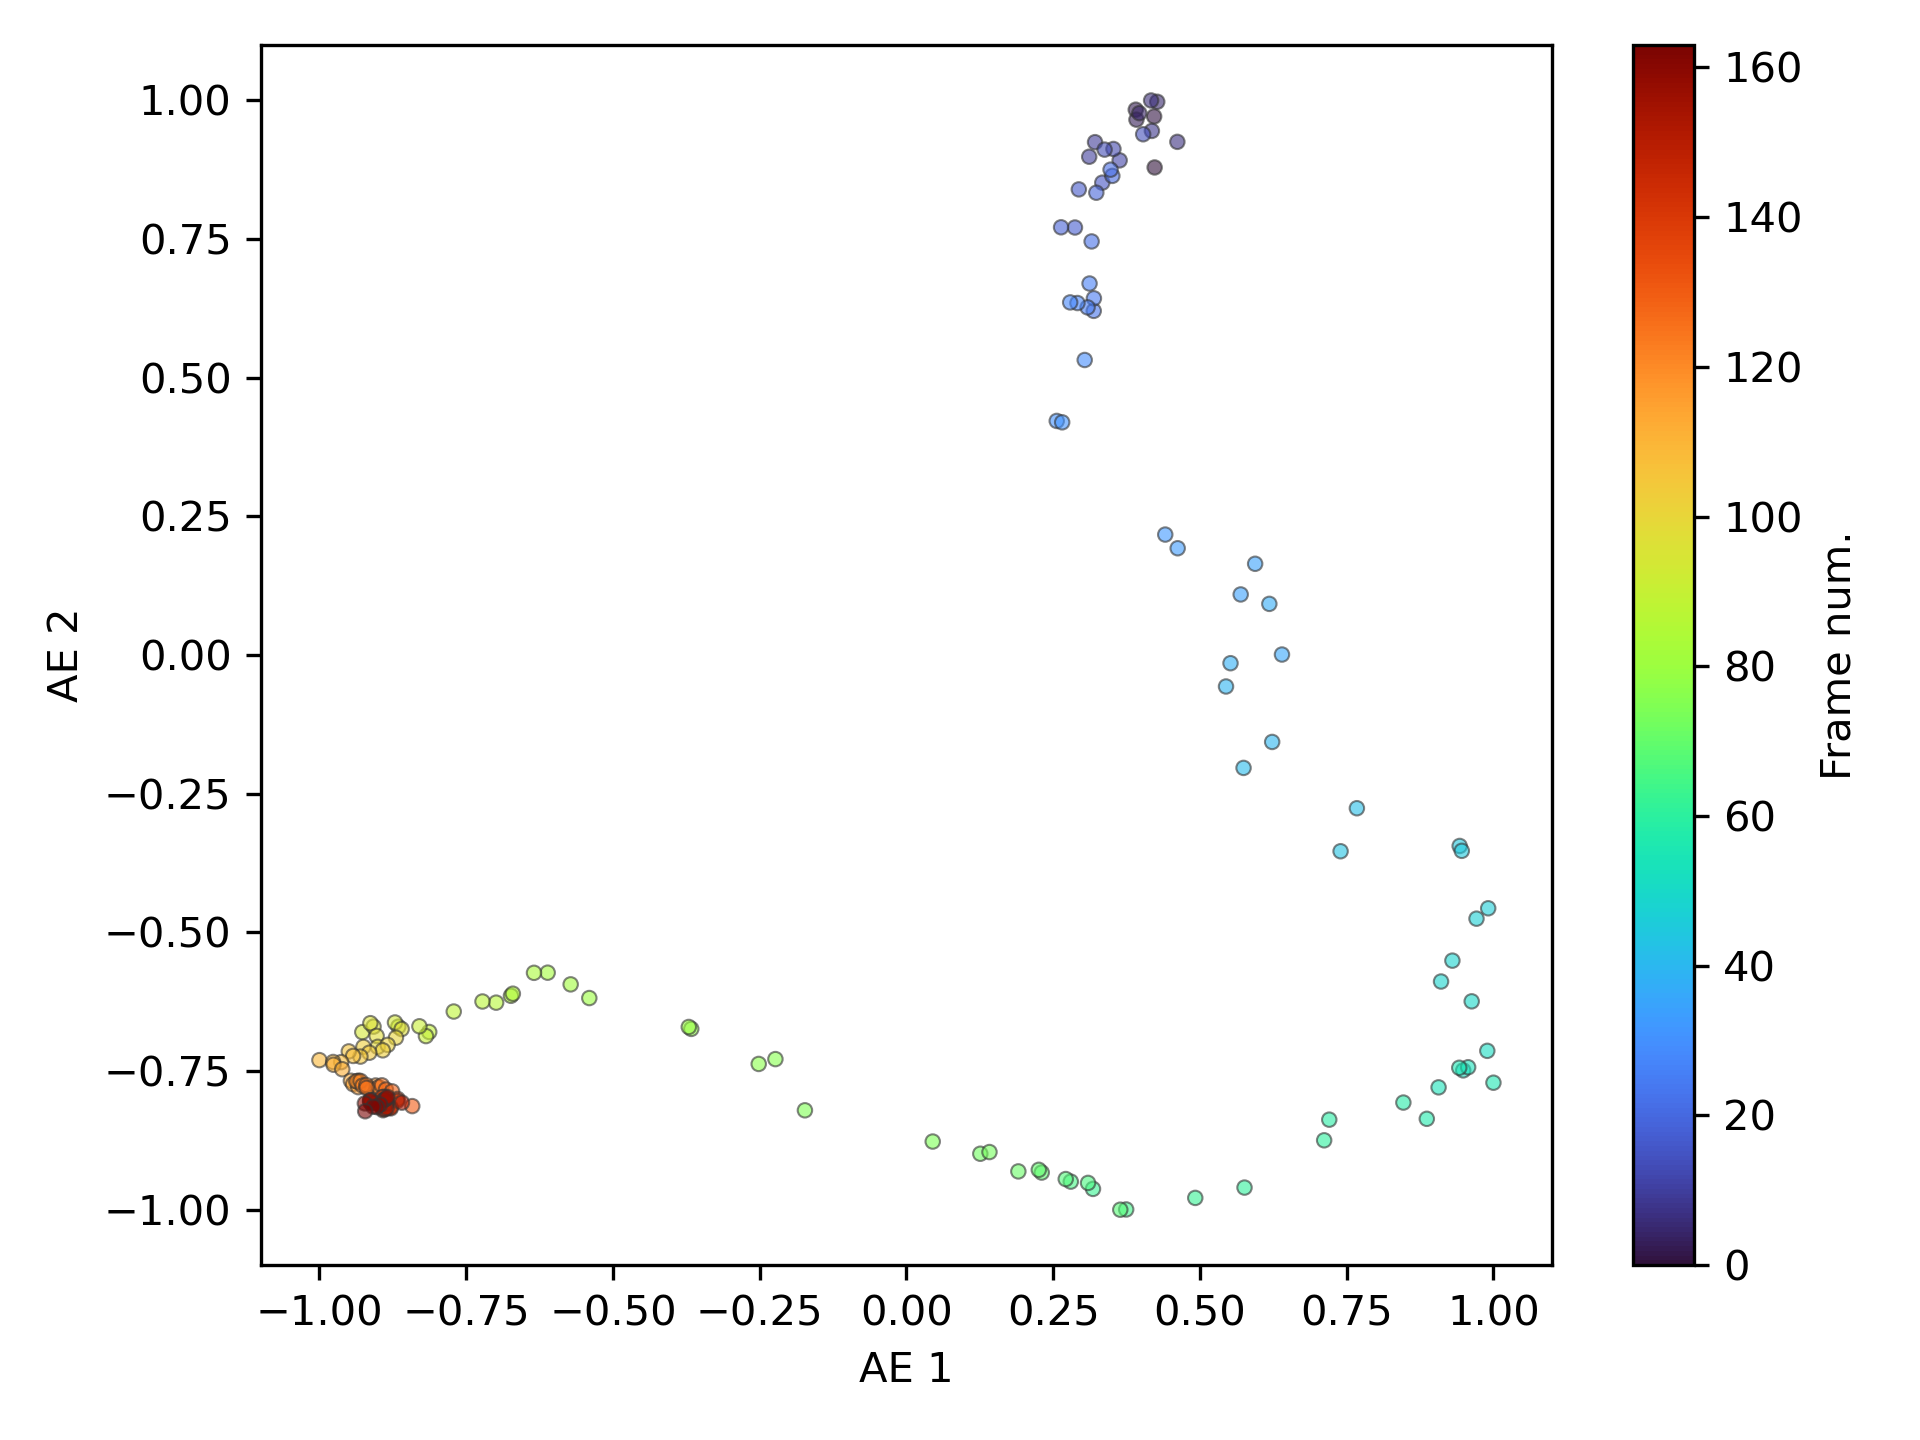

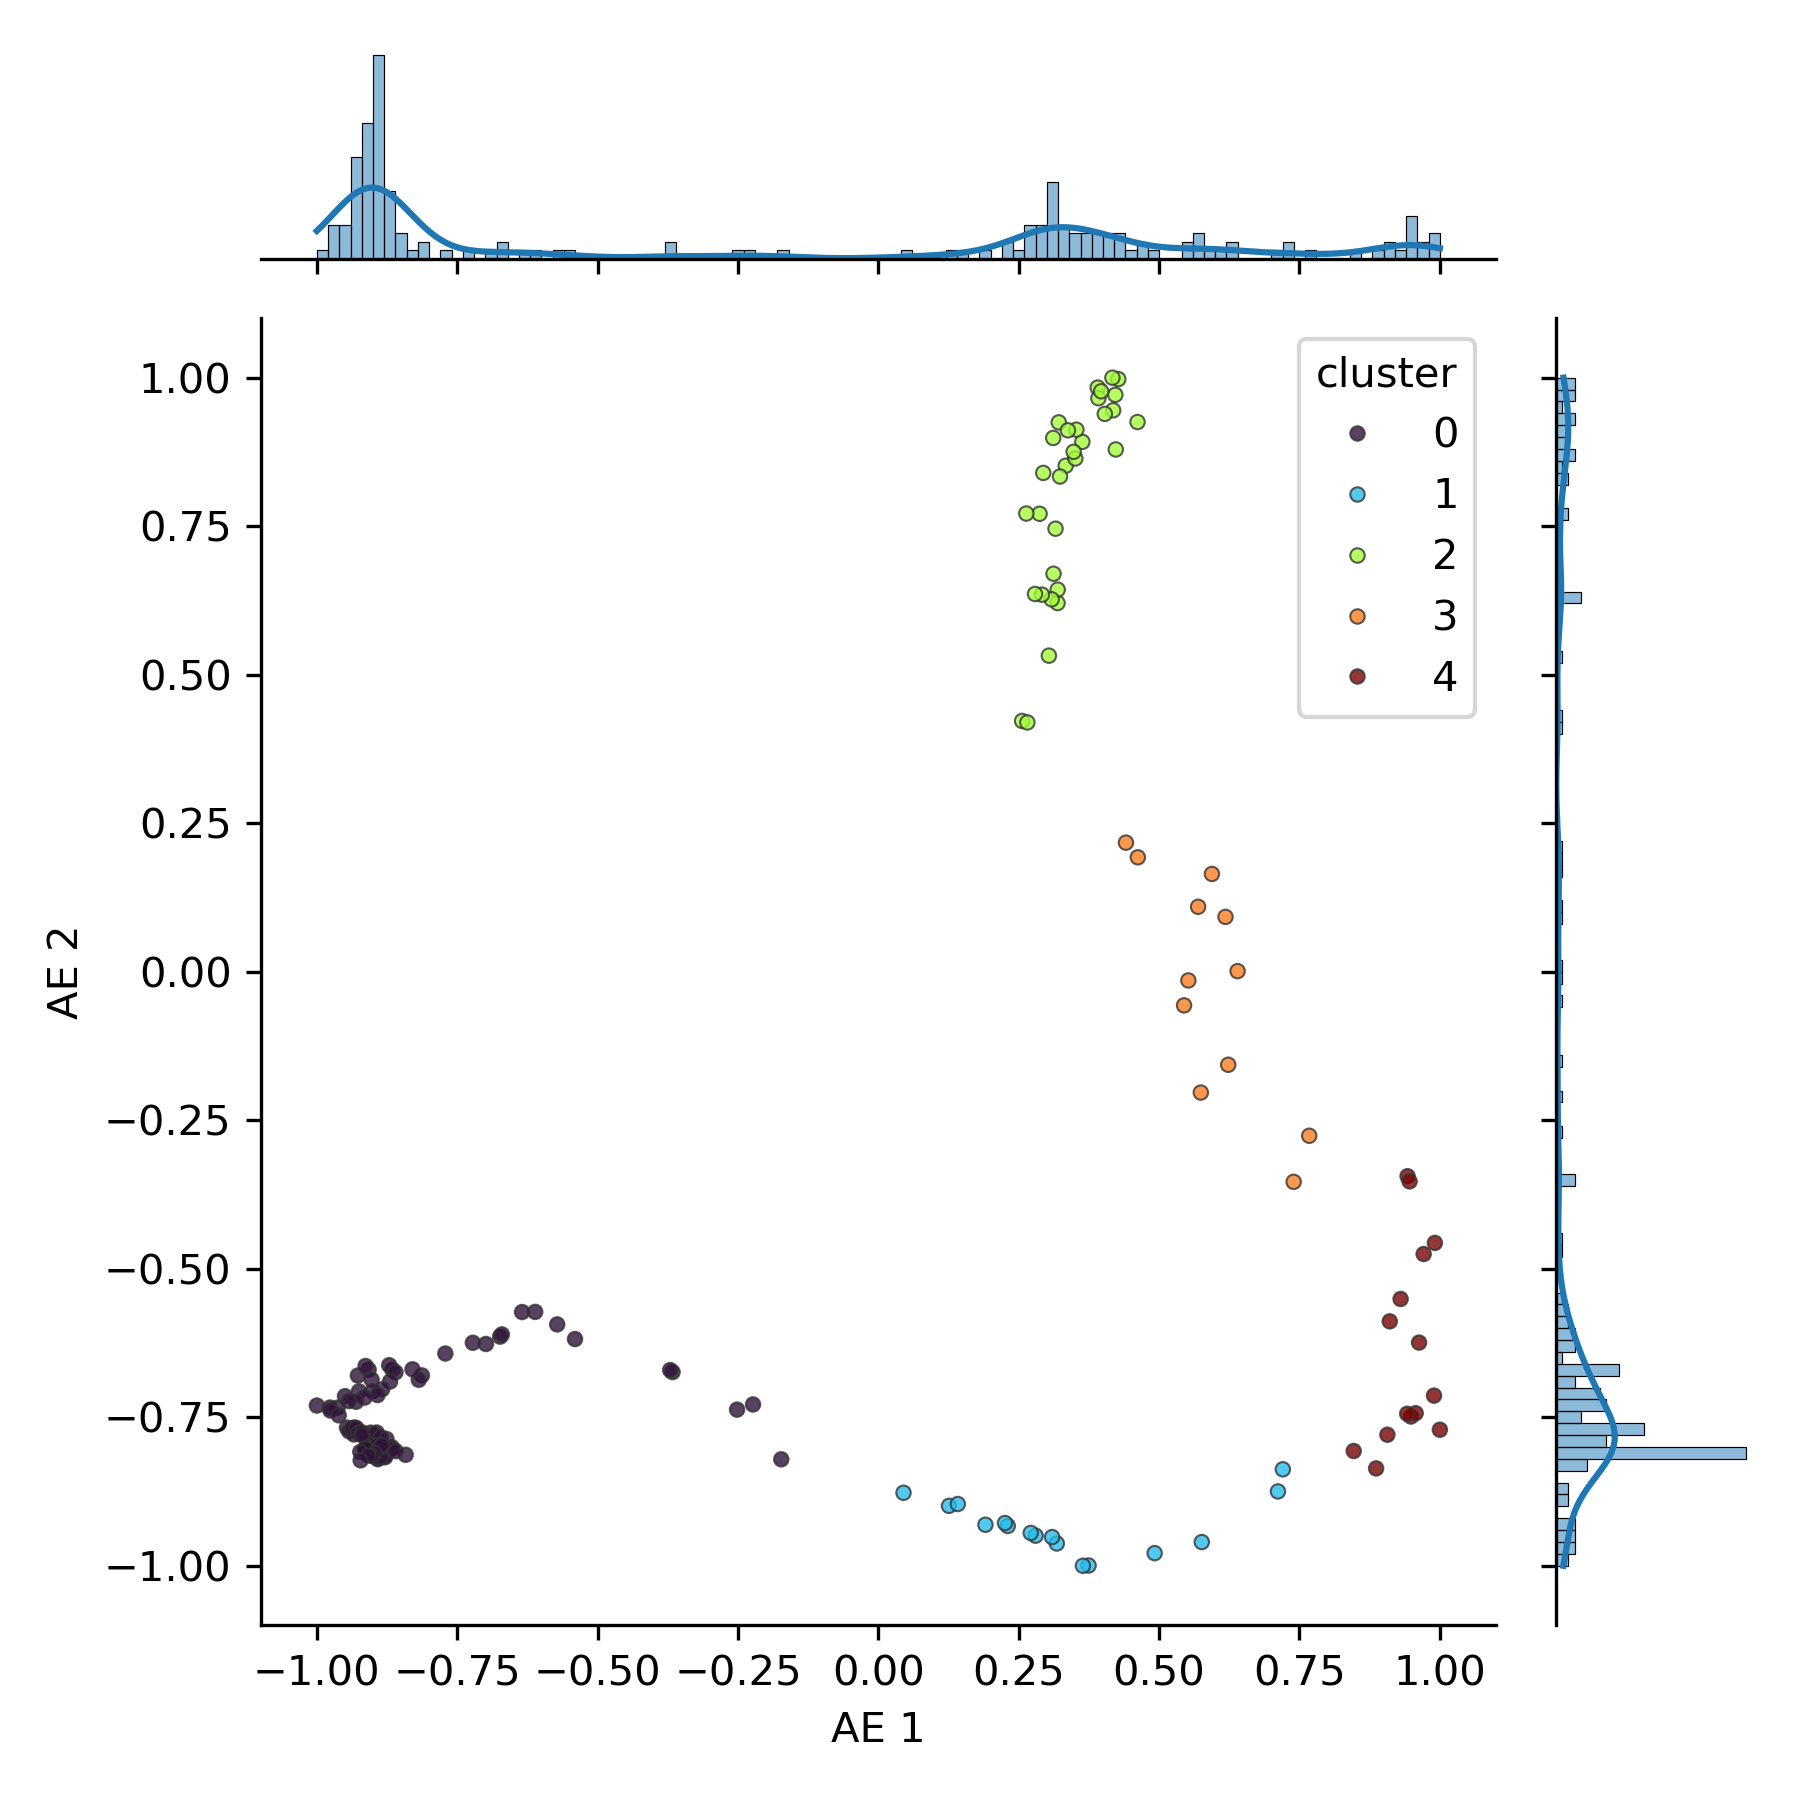

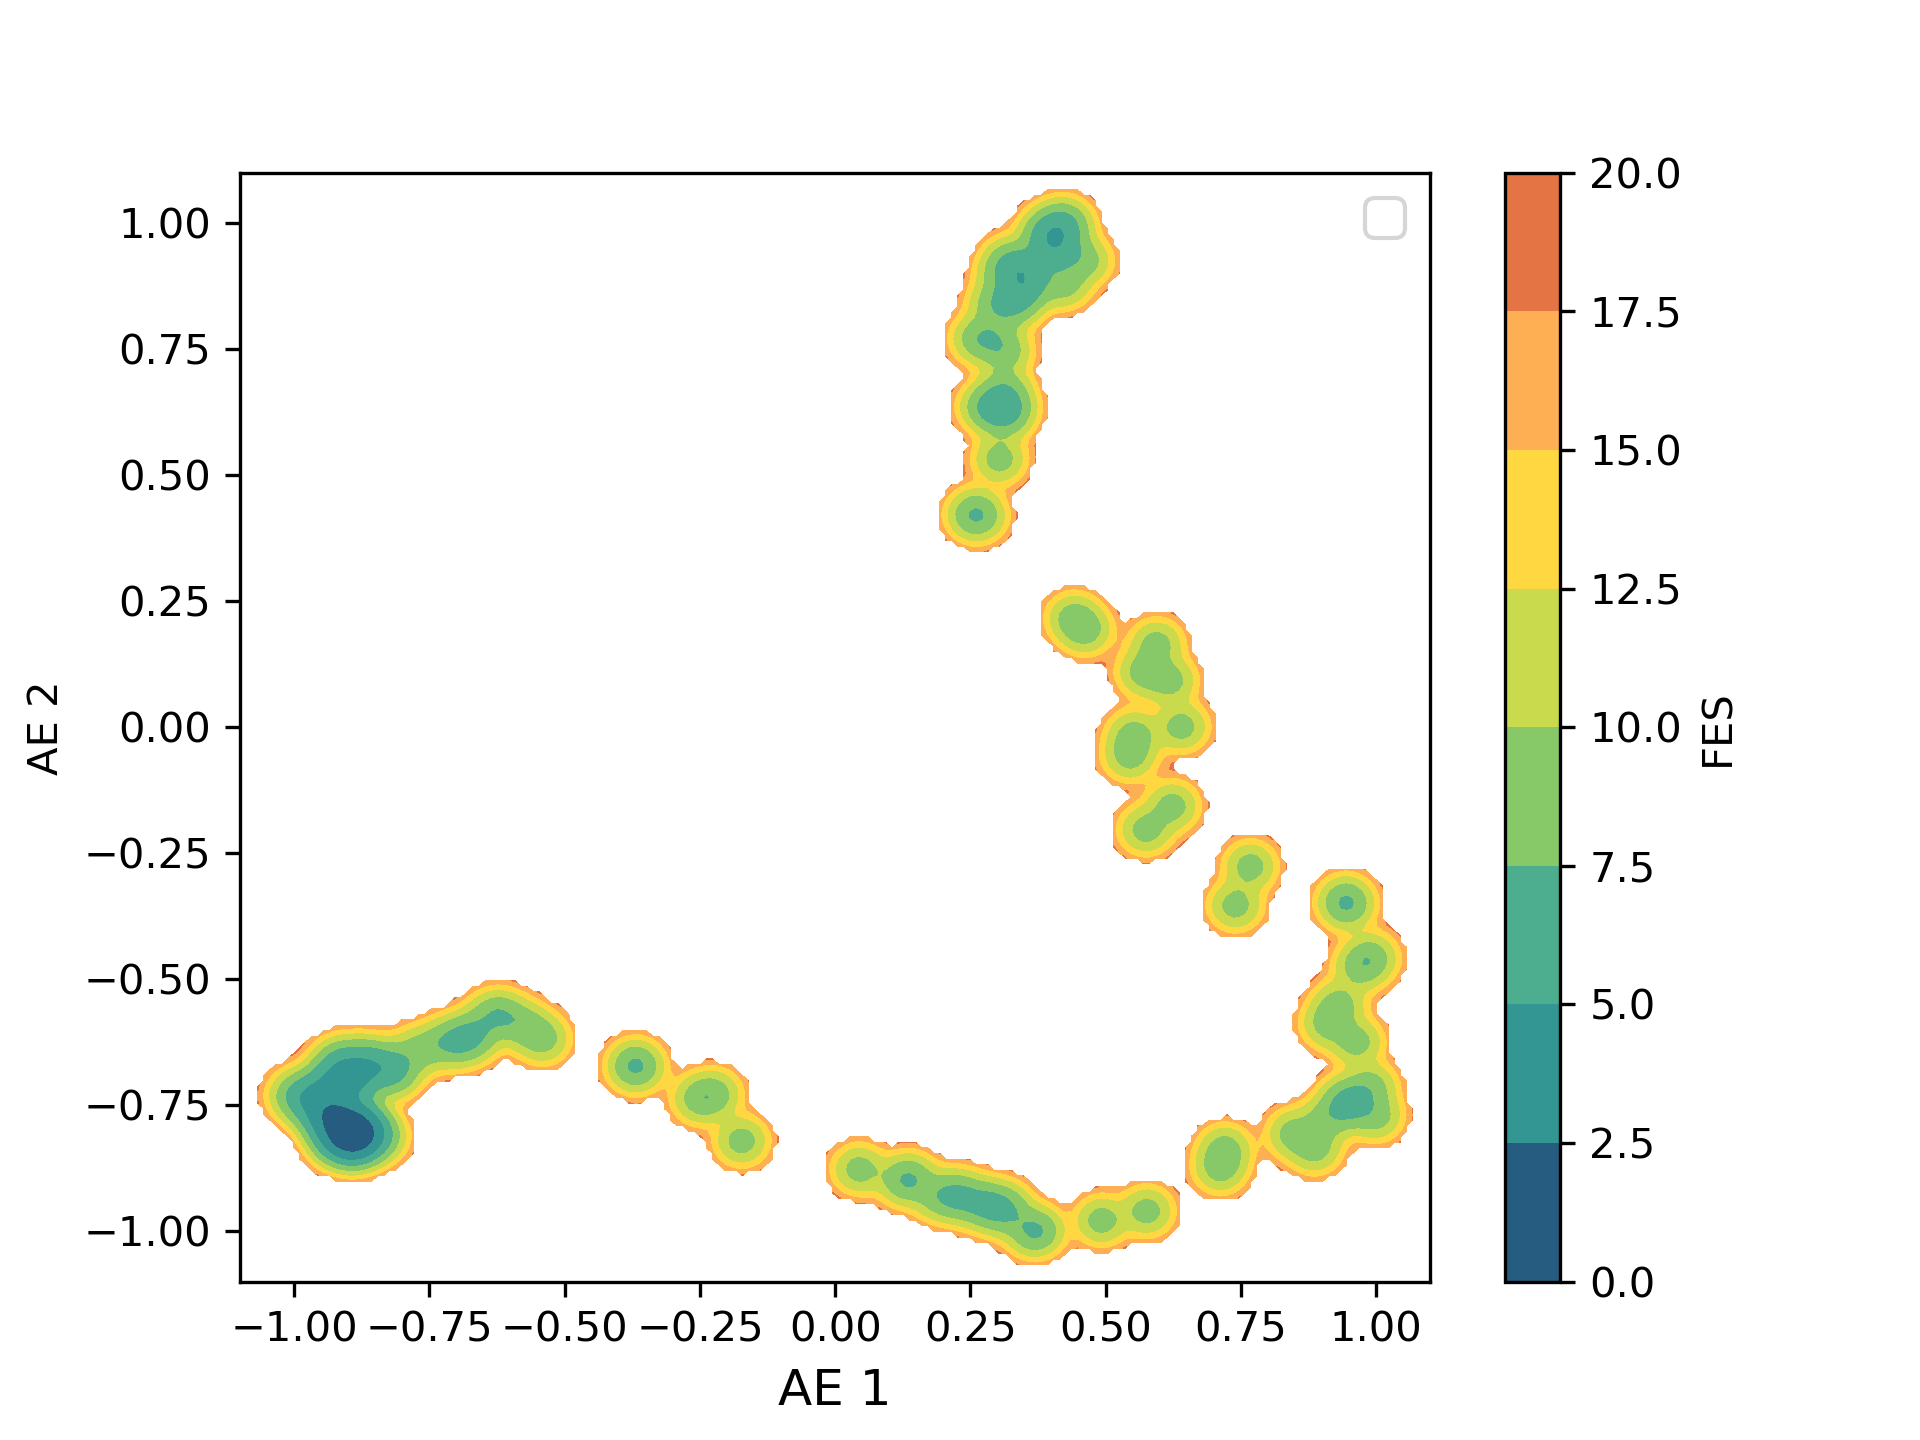

In [45]:
show_results(output_folder, model_name = 'ae')

#### TICA

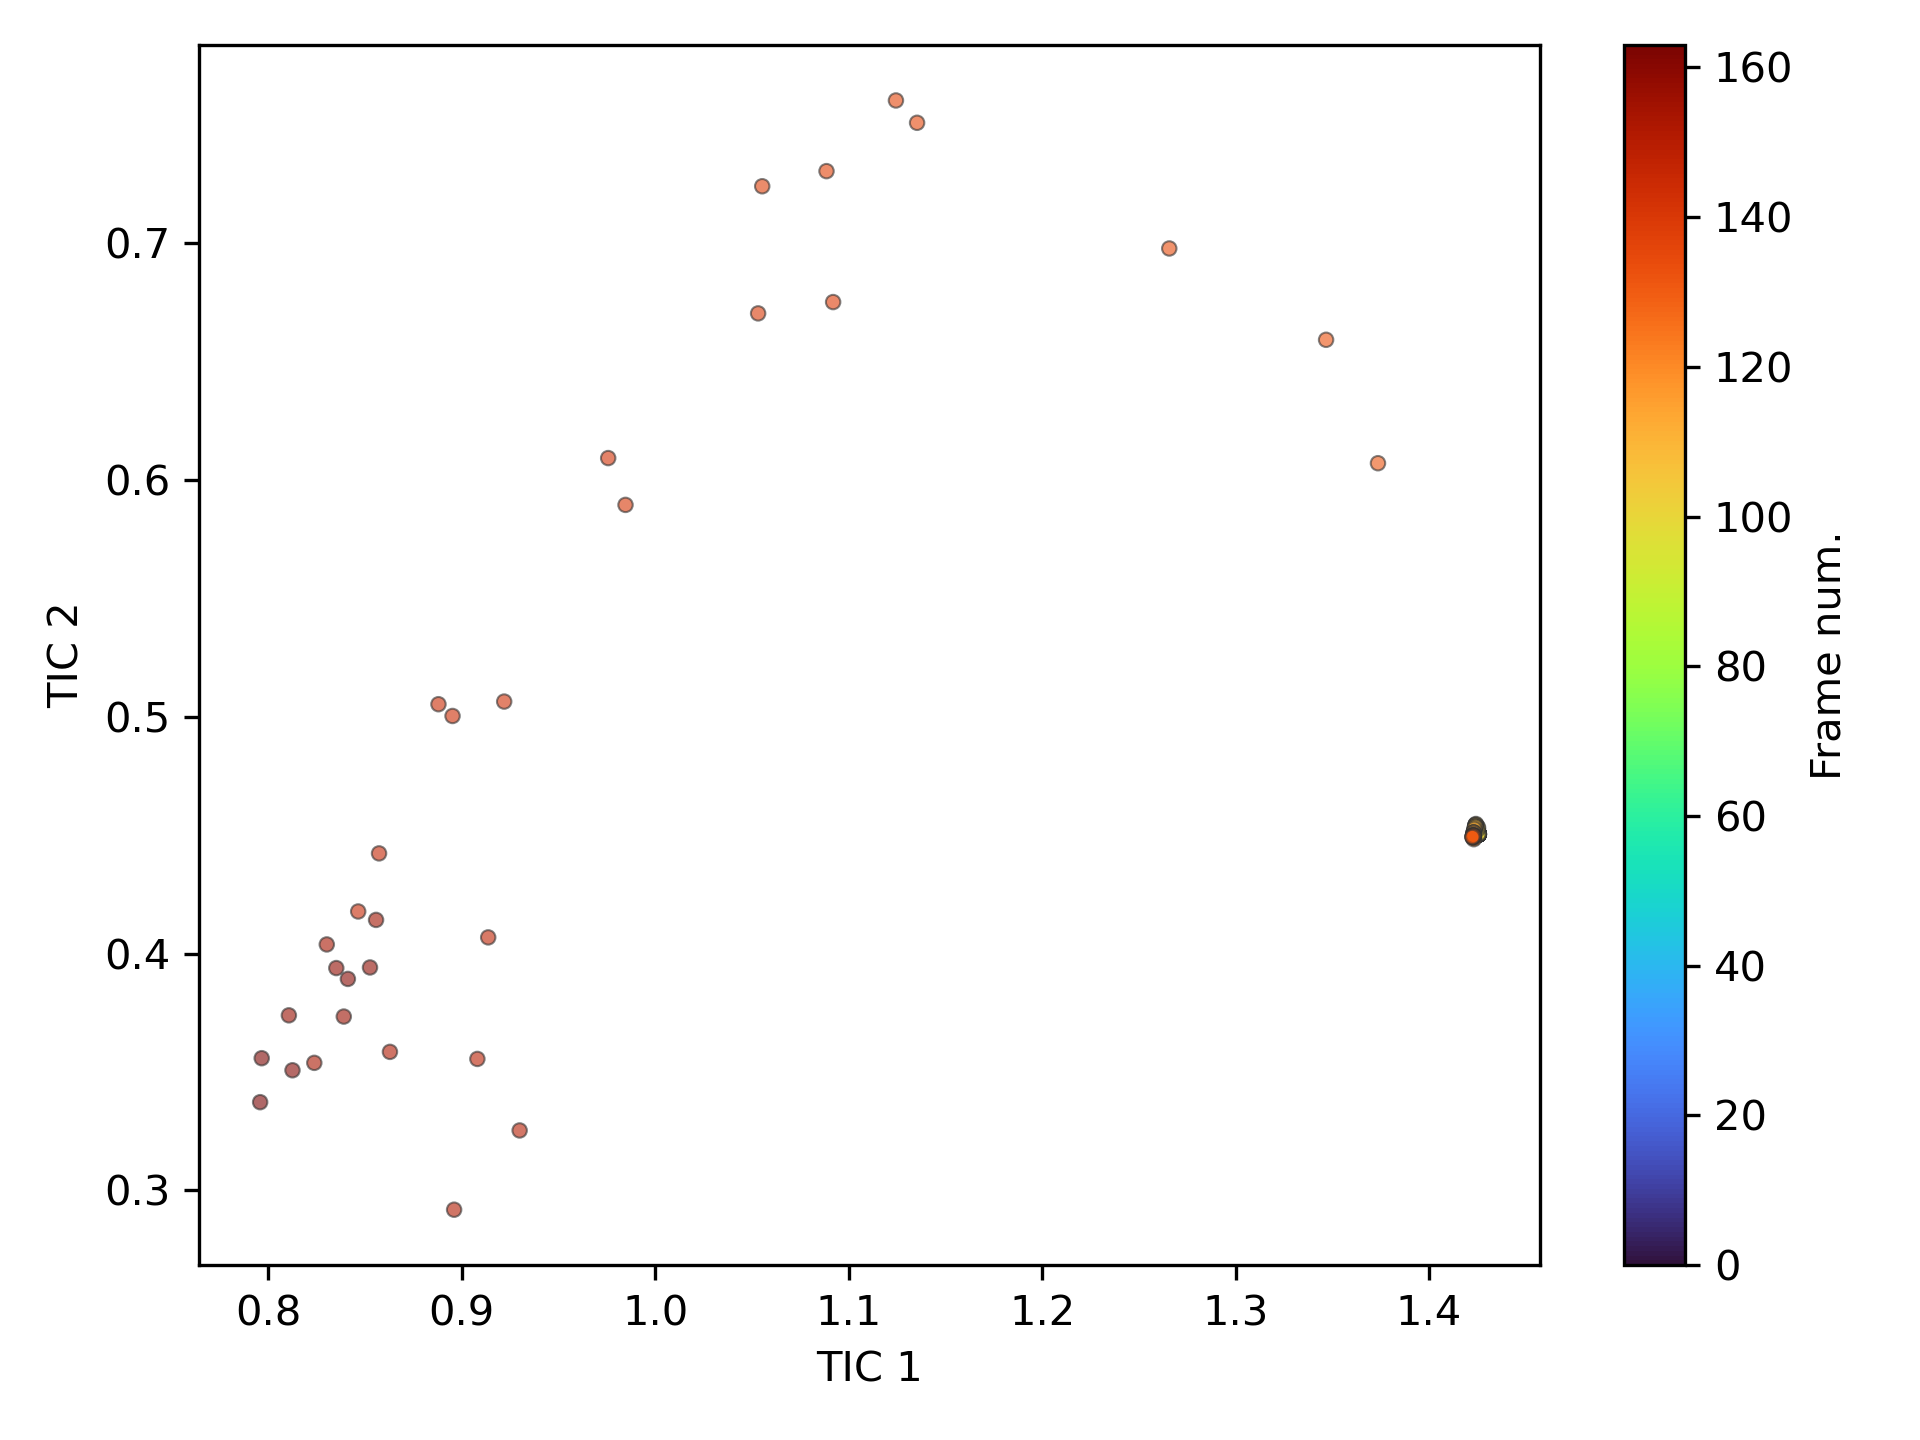

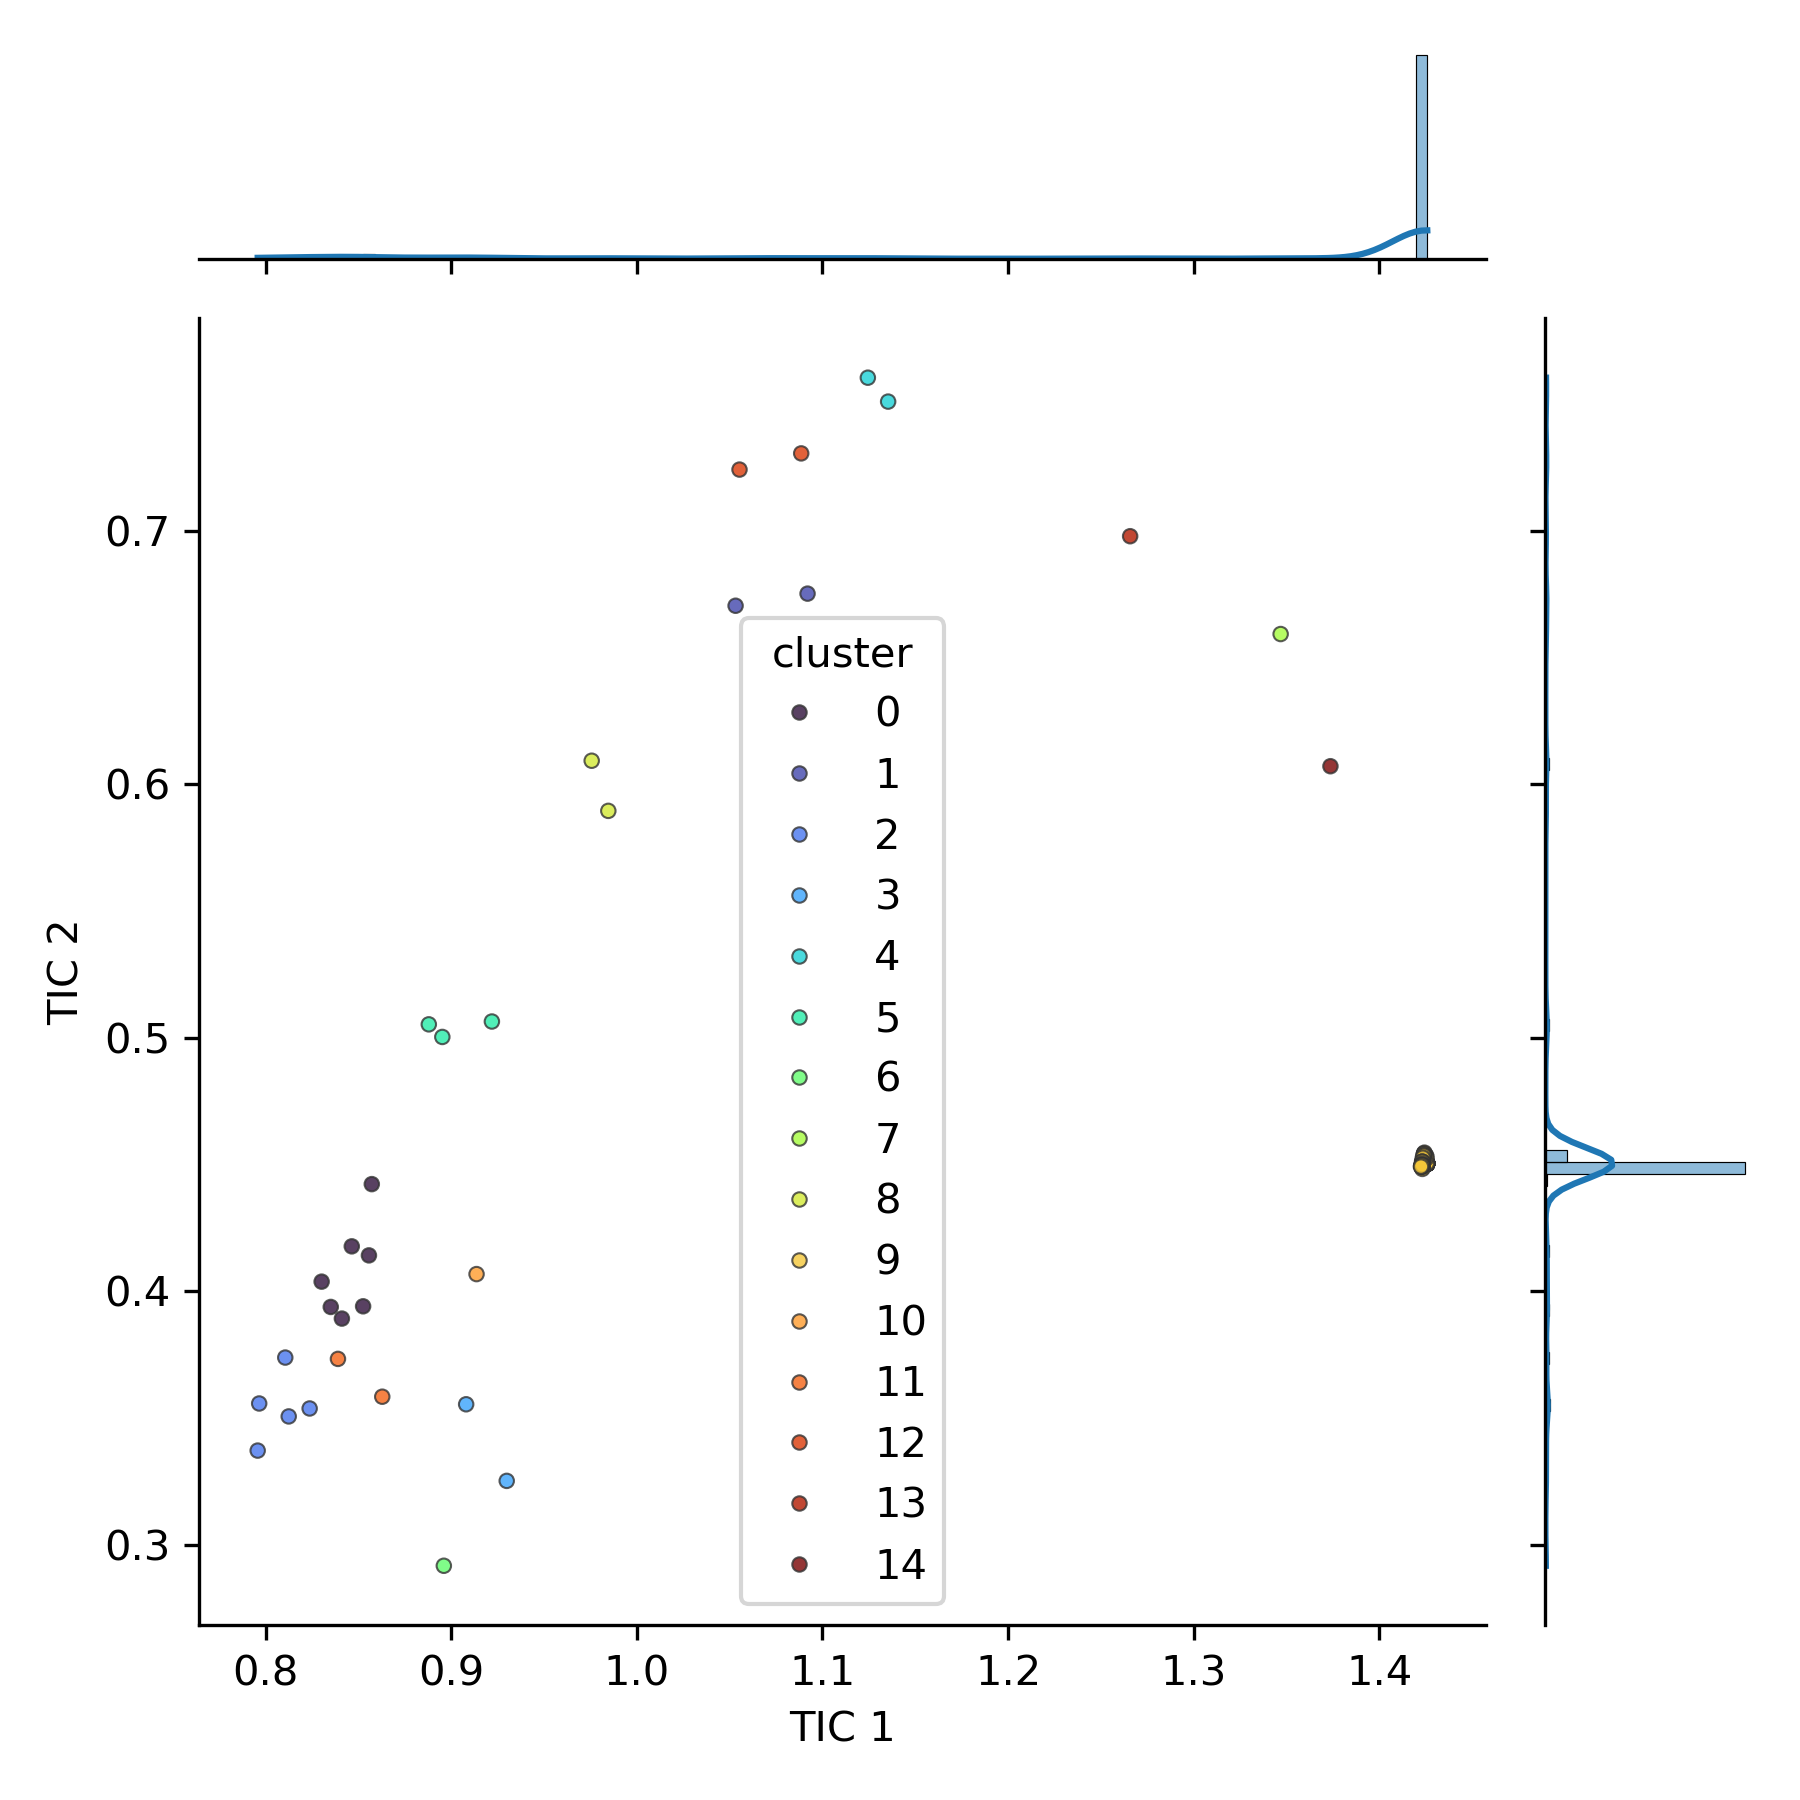

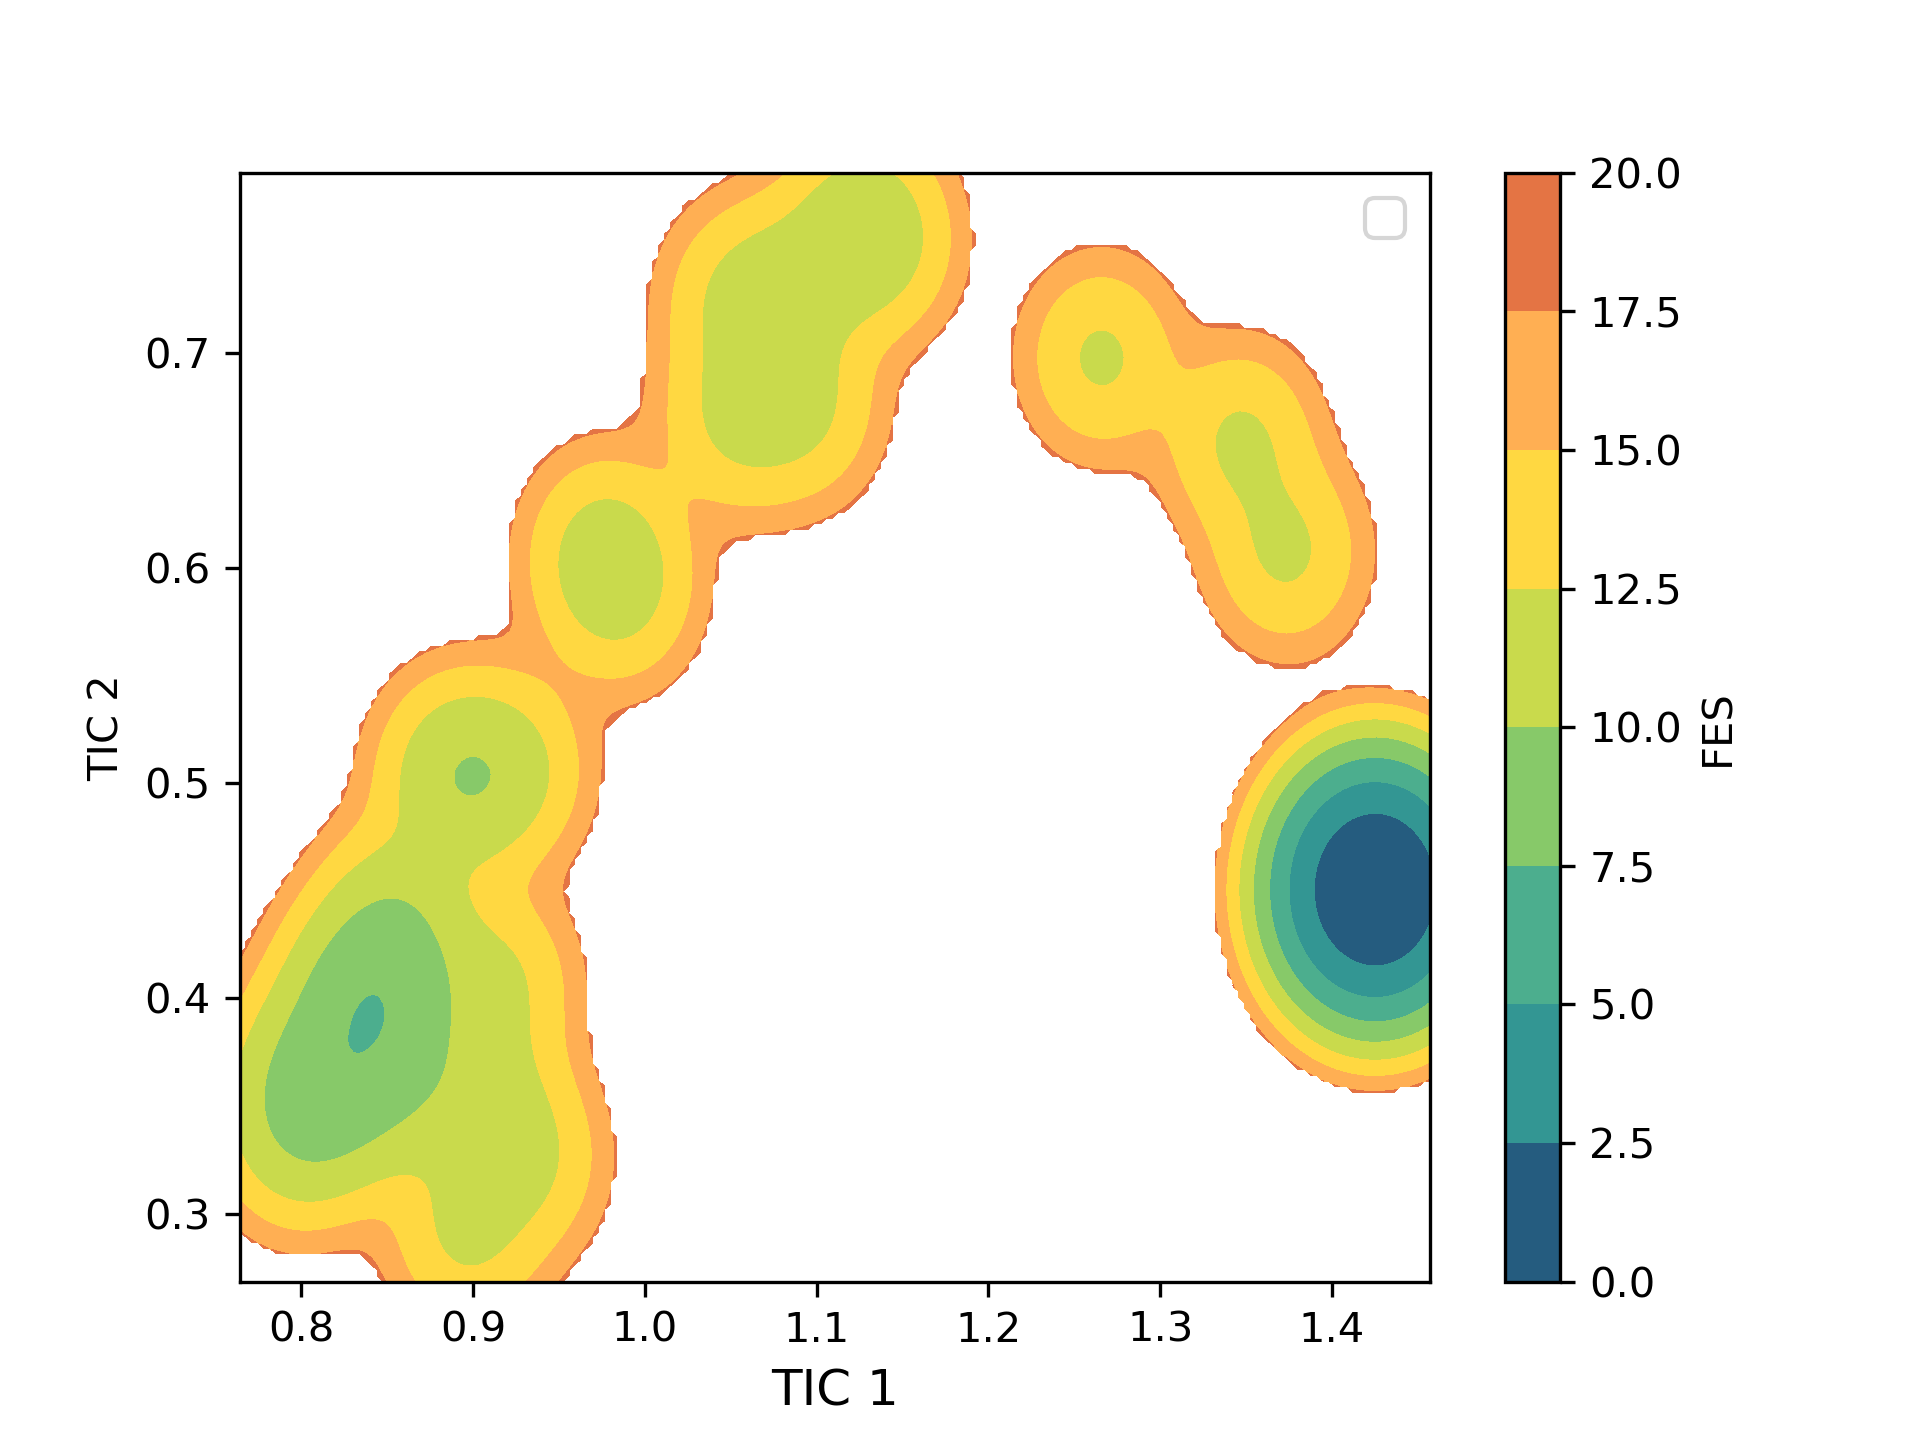

In [46]:
show_results(output_folder, model_name = 'tica')

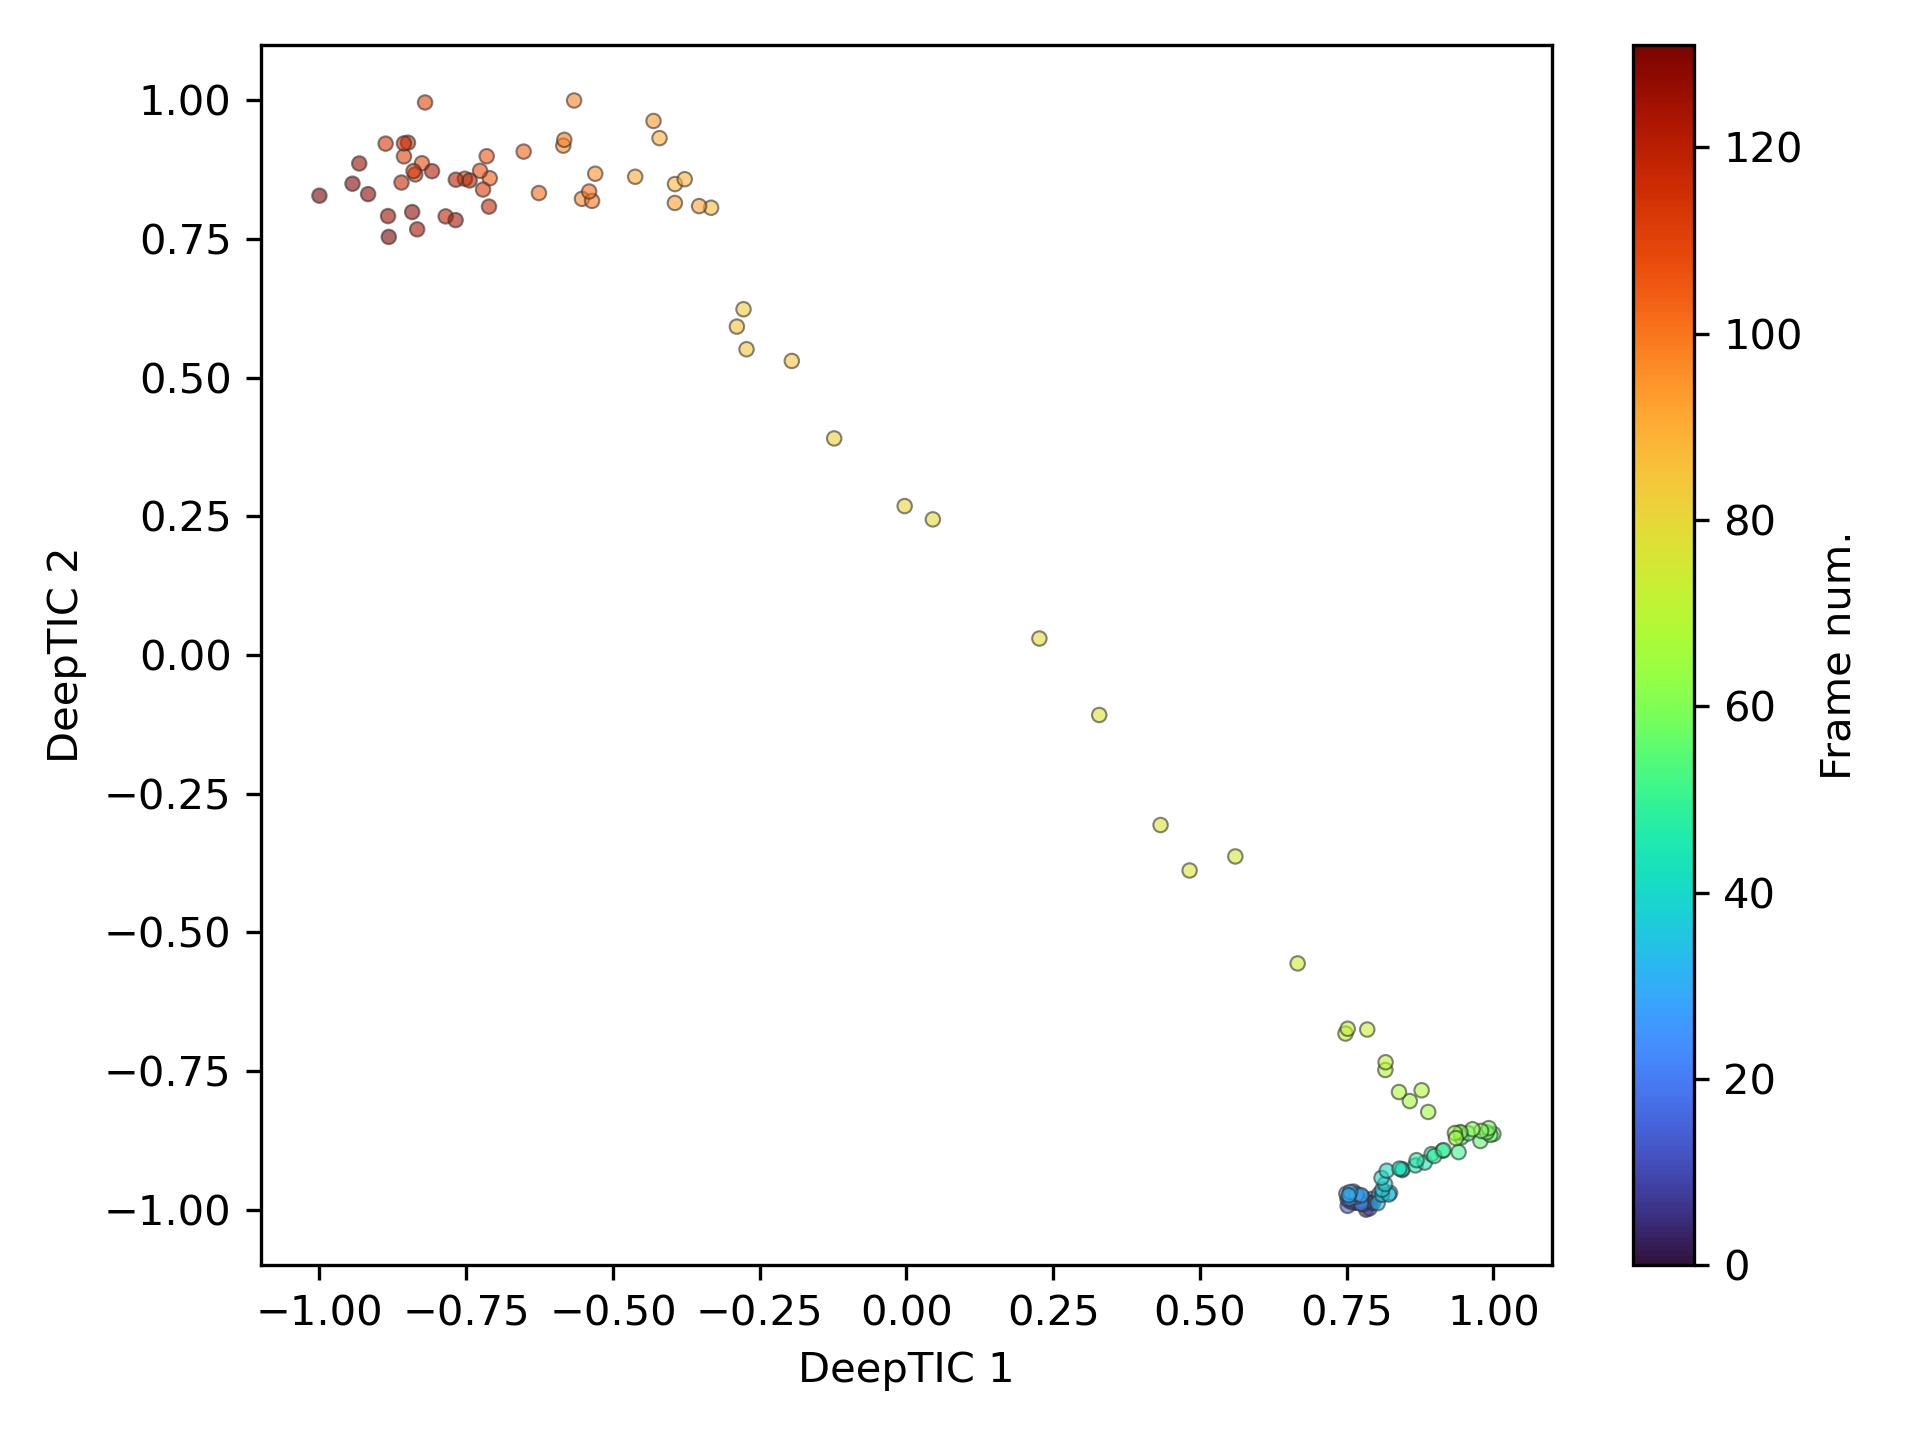

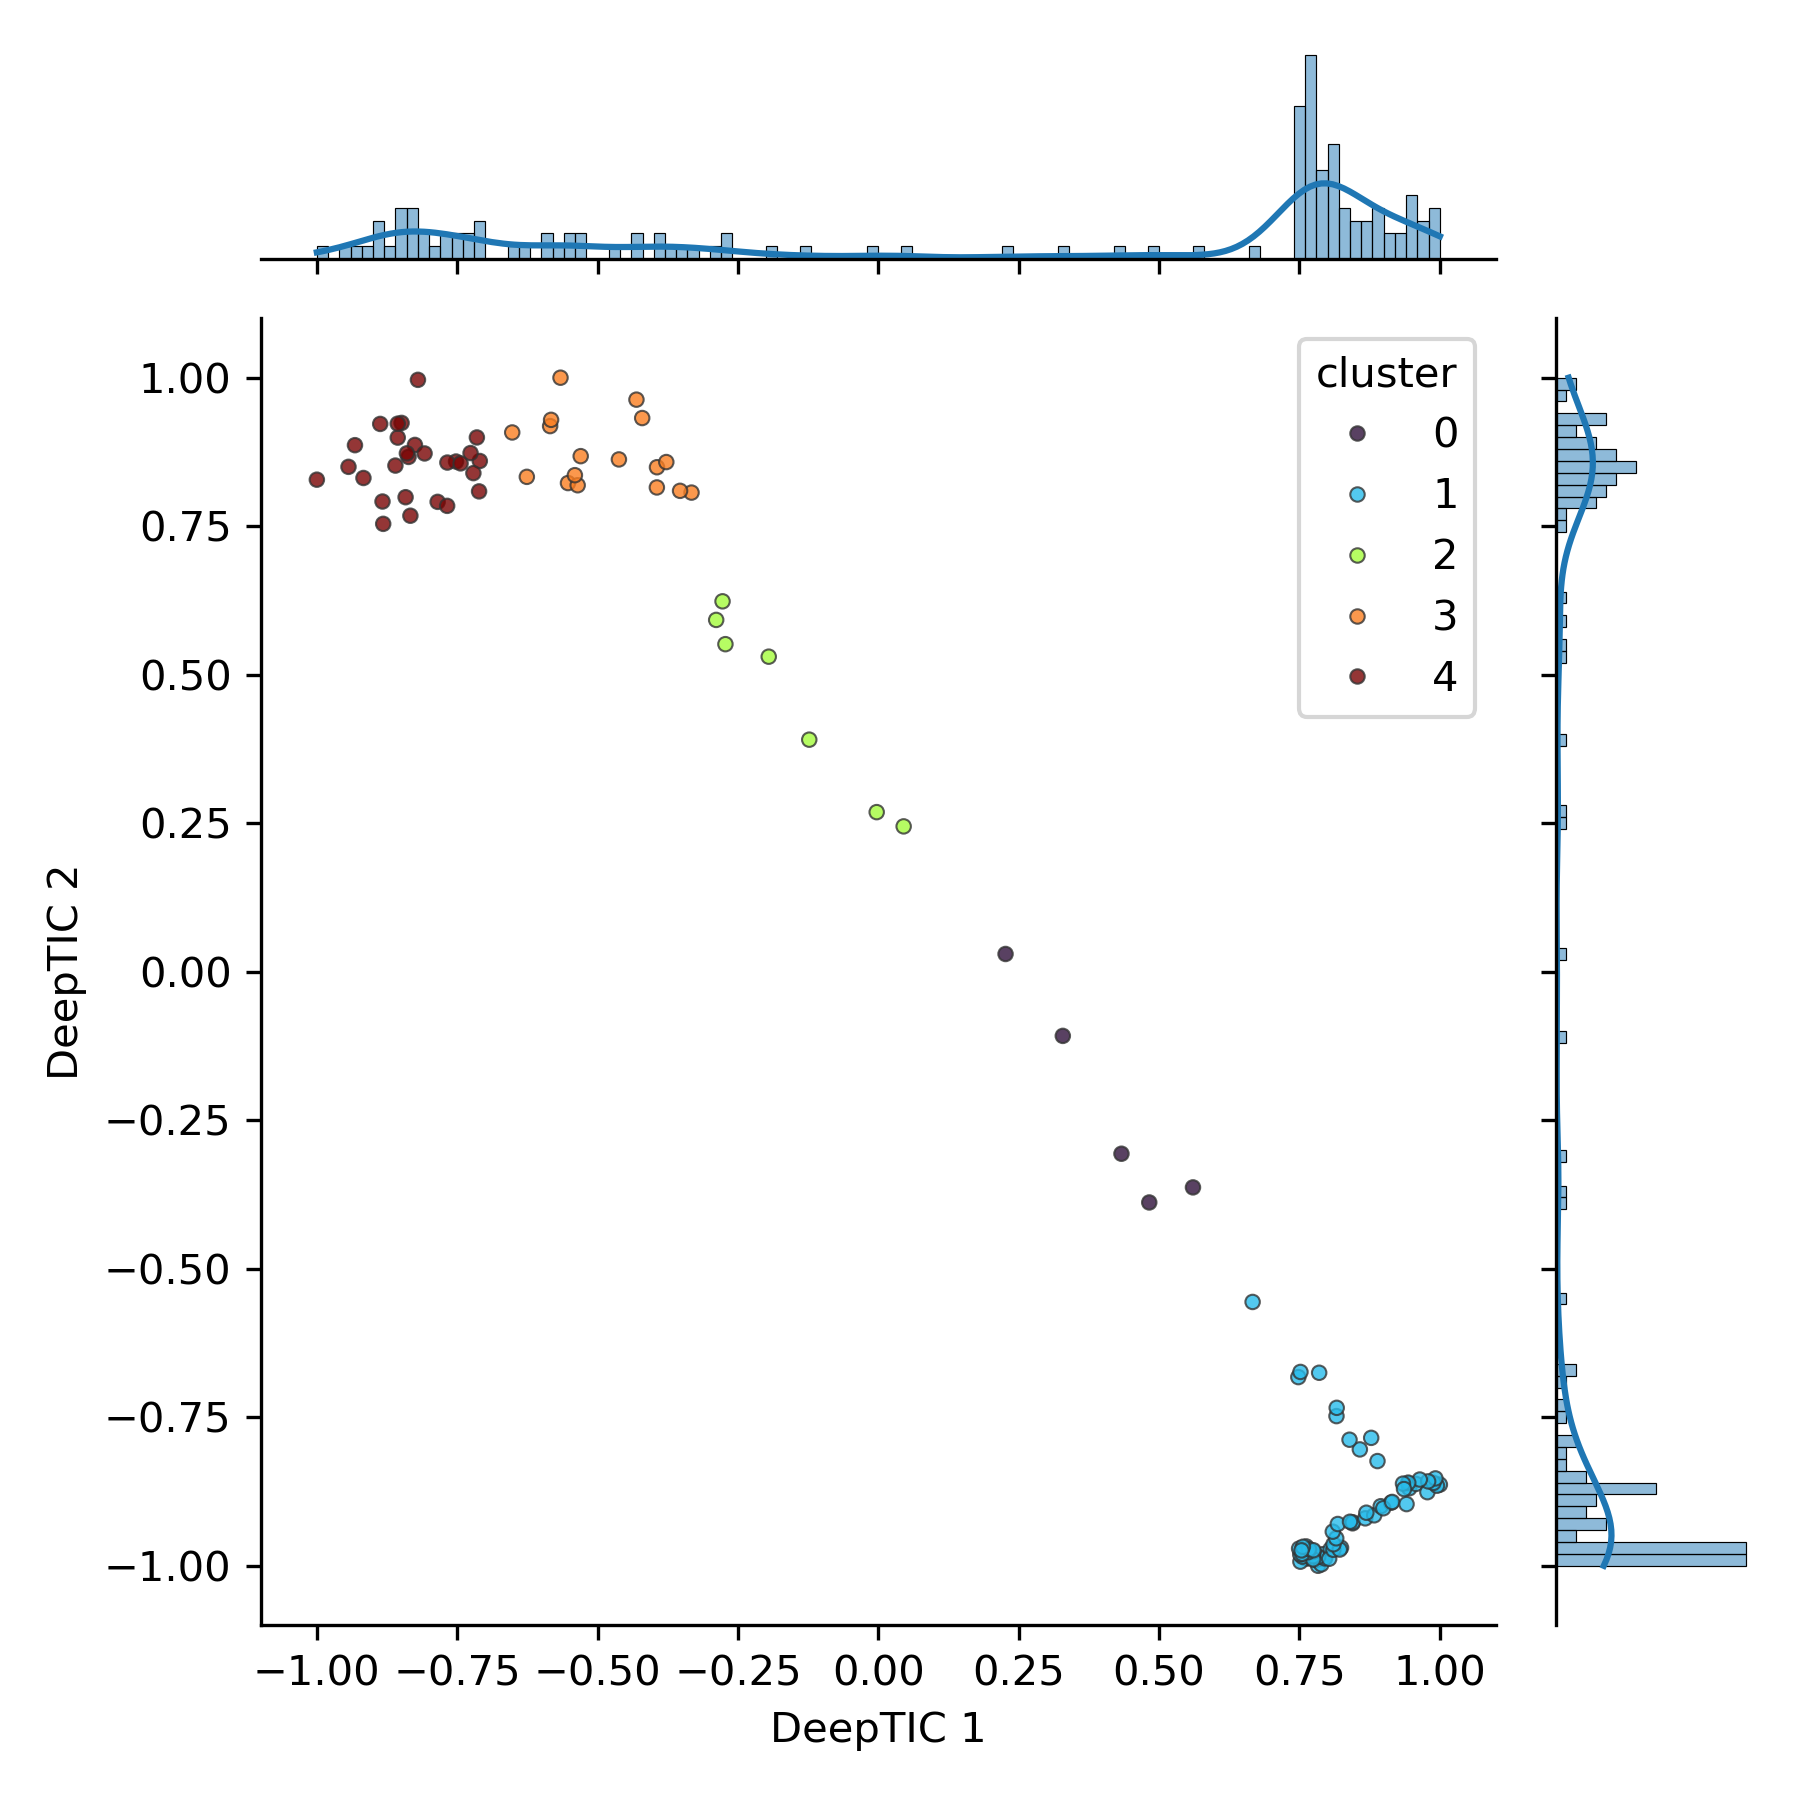

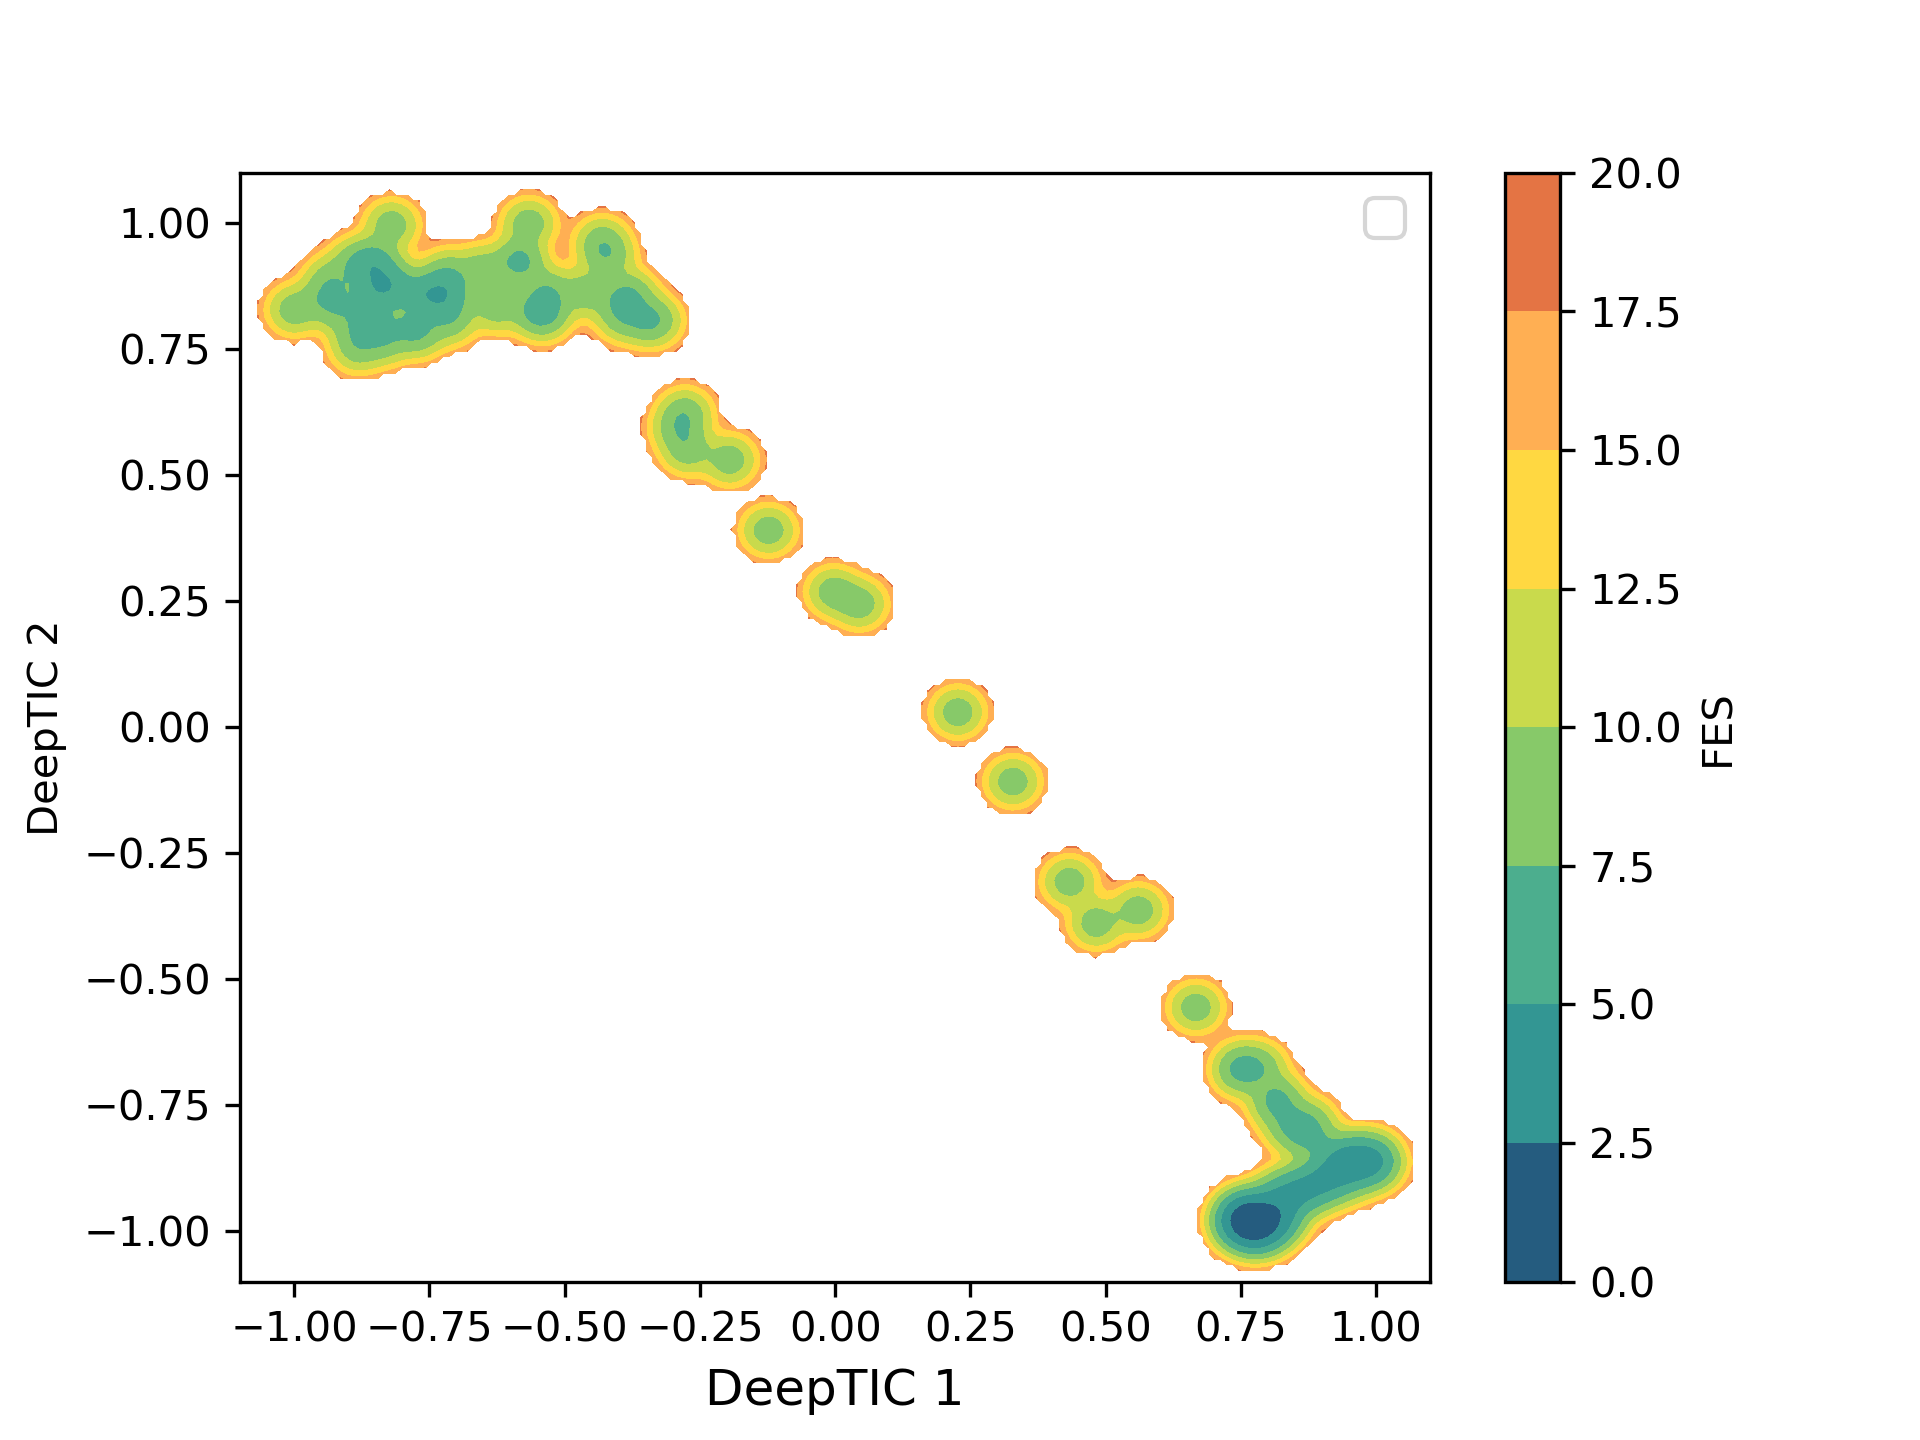

In [47]:
show_results(output_folder, model_name = 'deep_tica')

Play around with the other transitions and see how the different parameters affect the training of the collective variables.

## 2olu_A-2olv_A-1 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/2olu_A-2olv_A-1/trajectory.mp4" controls> </video>
</center>

## 3cw2_E-2qmu_A-3 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3cw2_E-2qmu_A-3/trajectory.mp4" controls> </video>
</center>

## 3hif_B-4bhp_A-3 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3hif_B-4bhp_A-3/trajectory.mp4" controls> </video>
</center>

## 3ts7_B-3ts7_A-1 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3ts7_B-3ts7_A-1/trajectory.mp4" controls> </video>
</center>